In [92]:
from __future__ import division

import os
import random
import multiprocessing as mp
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from scipy.spatial.distance import cosine, cdist

from learning2learn.wrangle import (synthesize_data, get_train_test_parameters, 
                                    build_train_set, build_test_trials_order1,
                                    build_test_trials_order2)
from learning2learn.util import get_hidden_representations, train_test_split, evaluate_generalization, train_model
from learning2learn.images import generate_image, shift_image
from learning2learn.models import build_model

In [2]:
gpu_options = tf.GPUOptions(allow_growth=True, visible_device_list='0')
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

In [40]:
def get_train_data(nb_categories, nb_exemplars, shift_scale=0):
    np.random.seed(0)
    df_train, labels = synthesize_data(nb_categories, nb_exemplars)
    labels = labels.values
    (shape_set_train, shape_set_test), \
    (color_set_train, color_set_test), \
    (texture_set_train, texture_set_test) = \
        get_train_test_parameters()
    if nb_categories < 50:
        shape_set_train, _ = train_test_split(shape_set_train, 50-nb_categories)
        color_set_train, _ = train_test_split(color_set_train, 50-nb_categories)
        texture_set_train, _ = train_test_split(texture_set_train, 50-nb_categories)
    X_train = build_train_set(
        df_train, shape_set_train, color_set_train,
        texture_set_train,
        target_size=(200, 200),
        shift_scale=shift_scale
    )
    ohe = OneHotEncoder(sparse=False)
    Y_train = ohe.fit_transform(labels.reshape(-1, 1))
    return X_train, Y_train

def get_test_data(nb_trials=1000, shift_scale=20):
    np.random.seed(0)
    df_train, _ = synthesize_data(nb_categories, nb_exemplars)
    (shape_set_train, shape_set_test), \
    (color_set_train, color_set_test), \
    (texture_set_train, texture_set_test) = \
        get_train_test_parameters()
    X_test_o1 = build_test_trials_order1(
        df_train, shape_set_train, shape_set_test, color_set_train,
        color_set_test, texture_set_train, texture_set_test,
        nb_trials=nb_trials, shift_scale=shift_scale
    )
    X_test_o2 = build_test_trials_order2(
        shape_set_test, color_set_test, texture_set_test,
        nb_trials=nb_trials, shift_scale=shift_scale
    )
    
    return X_test_o1, X_test_o2

In [128]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.regularizers import l2

def cnn0(input_shape, nb_classes):
    # The baseline CNN
    layers = [
        # Conv, Pool
        Conv2D(32, (5, 5), padding='same', input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(64, (5, 5), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        Dropout(0.5),
        Dense(2048),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

def cnn1(input_shape, nb_classes):
    # Baseline but with dropout removed from last pooling layer
    layers = [
        # Conv, Pool
        Conv2D(32, (5, 5), padding='same', input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(64, (5, 5), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        Dense(2048),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

def cnn2(input_shape, nb_classes):
    # Baseline but with regularization added
    layers = [
        # Conv, Pool
        Conv2D(32, (5, 5), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(64, (5, 5), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        Dropout(0.5),
        Dense(2048, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

def cnn3(input_shape, nb_classes):
    # Many fewer conv filters, smaller FC layer, regularization added
    layers = [
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        Dropout(0.5),
        Dense(100, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

def cnn4(input_shape, nb_classes):
    # Many fewer conv filters, smaller FC layer, regularization added, dropout 
    # removed after last pool layer
    layers = [
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        Dense(100, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

# From here forward we will always use dropout after last pool layer. It works better.

def cnn5(input_shape, nb_classes):
    # Much smaller filters and FC layer, regularization added, dropout 
    # removed after last pool layer, 25 units in FC
    layers = [
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        #Dropout(0.5),
        Dense(25, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

def cnn6(input_shape, nb_classes):
    layers = [
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        #Dropout(0.5),
        Dense(1000, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

def cnn7(input_shape, nb_classes):
    layers = [
        # Conv, Pool
        Conv2D(5, (3, 3), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(5, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        #Dropout(0.5),
        Dense(25, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

def cnn8(input_shape, nb_classes):
    # Much smaller filters and FC layer, regularization added, dropout 
    # removed after last pool layer, 25 units in FC
    layers = [
        # Conv, Pool
        Conv2D(3, (5, 5), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(3, (5, 5), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        Dense(15, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
        Dense(nb_classes),
        Activation('softmax')
    ]

    return build_model(layers)

In [5]:
def shift_images(imgs, shift_scale=20):
    img_size = imgs.shape[1:3]
    imgs_p = imgs
    for i in range(len(imgs)):
        imgs_p[i,:,:,:3] = shift_image(
            imgs[i,:,:,:3], img_size=img_size, scale=shift_scale
        )
        
    return imgs_p

def model_trial(
    model_fn, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=5, nb_epoch=100, burn_period=20
):
    scores_o1 = np.zeros(nb_runs)
    scores_o2 = np.zeros(nb_runs)
    #X_train_shifted = shift_images(X_train)
    for i in range(nb_runs):
        print('Trial #%i' % (i+1))
        model = model_fn(
            input_shape=X_train.shape[1:], 
            nb_classes=Y_train.shape[-1]
        )
        weights_file = '../data/temp.h5'
        if os.path.isfile(weights_file):
            os.remove(weights_file)
        checkpoint = ModelCheckpoint(
            weights_file,
            monitor='loss',
            save_best_only=True,
            save_weights_only=True,
            period=2
        )
        X_train_shifted = shift_images(X_train)
        train_model(
            model, X_train_shifted, Y_train, epochs=nb_epoch,
            validation_data=None, batch_size=32,
            checkpoint=checkpoint, burn_period=burn_period
        )
        model.load_weights(weights_file)
        score_o1 = evaluate_generalization(
            model, X_test_o1, layer_num=-4,
            batch_size=128
        )
        score_o2 = evaluate_generalization(
            model, X_test_o2, layer_num=-4,
            batch_size=128
        )
        print('\nScore O1: %0.4f' % score_o1)
        print('Score O2: %0.4f\n' % score_o2)
        scores_o1[i] = score_o1
        scores_o2[i] = score_o2
    
    print('\nScore O1 avg: %0.4f' % scores_o1.mean())
    print('Score O2 avg: %0.4f' % scores_o2.mean())
    return scores_o1, scores_o2

In [6]:
nb_categories = 5
nb_exemplars = 5

In [7]:
X_train, Y_train = get_train_data(nb_categories, nb_exemplars)
X_test_o1, X_test_o2 = get_test_data(2000)

In [55]:
# baseline

In [11]:
scores_o1, scores_o2 = model_trial(
    cnn0, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 0s 15ms/step - loss: 1.6833 - acc: 0.1600
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 4.6024 - acc: 0.2000
Epoch 3/50
25/25 [==============================] - 0s 1ms/step - loss: 2.9015 - acc: 0.2000
Epoch 4/50
25/25 [==============================] - 0s 1ms/step - loss: 1.6064 - acc: 0.3600
Epoch 5/50
25/25 [==============================] - 0s 1ms/step - loss: 1.5681 - acc: 0.5600
Epoch 6/50
25/25 [==============================] - 0s 1ms/step - loss: 1.4880 - acc: 0.4800
Epoch 7/50
25/25 [==============================] - 0s 1ms/step - loss: 1.3615 - acc: 0.5200
Epoch 8/50
25/25 [==============================] - 0s 1ms/step - loss: 1.2889 - acc: 0.5200
Epoch 9/50
25/25 [==============================] - 0s 1ms/step - loss: 3.0210 - acc: 0.2000
Epoch 10/50
25/25 [==============================] - 0s 1ms/step - loss: 2.0435 - acc: 0.4000
Epoch 11/50
25/25 [==============================] - 0s 1ms

Epoch 38/150
25/25 [==============================] - 1s 22ms/step - loss: 3.7945e-04 - acc: 1.0000
Epoch 39/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 40/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0011 - acc: 1.0000
Epoch 41/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 1.0000
Epoch 42/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0058 - acc: 1.0000
Epoch 43/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5952 - acc: 0.8000
Epoch 44/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3839 - acc: 0.5600
Epoch 45/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2866 - acc: 0.8800
Epoch 46/150
25/25 [==============================] - 0s 1ms/step - loss: 3.1311 - acc: 0.5600
Epoch 47/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6303 - acc: 0.6000
Epoch 48/150
25/25 [=========================

25/25 [==============================] - 1s 21ms/step - loss: 9.8780e-06 - acc: 1.0000
Epoch 123/150
25/25 [==============================] - 0s 1ms/step - loss: 2.1544e-05 - acc: 1.0000
Epoch 124/150
25/25 [==============================] - 0s 1ms/step - loss: 5.2250e-05 - acc: 1.0000
Epoch 125/150
25/25 [==============================] - 0s 1ms/step - loss: 4.1907e-05 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3936e-05 - acc: 1.0000
Epoch 127/150
25/25 [==============================] - 0s 1ms/step - loss: 1.9943e-05 - acc: 1.0000
Epoch 128/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2715e-05 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1104e-05 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 1s 21ms/step - loss: 1.6856e-06 - acc: 1.0000
Epoch 131/150
25/25 [==============================] - 0s 1ms/step - loss: 7.5938e-06 - acc: 1.0000
Epoch 132/15

Epoch 8/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0290 - acc: 1.0000
Epoch 9/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0028 - acc: 1.0000
Epoch 10/150
25/25 [==============================] - 1s 22ms/step - loss: 0.0078 - acc: 1.0000
Epoch 11/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0060 - acc: 1.0000
Epoch 12/150
25/25 [==============================] - 1s 21ms/step - loss: 0.0053 - acc: 1.0000
Epoch 13/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000
Epoch 14/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0054 - acc: 1.0000
Epoch 15/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0036 - acc: 1.0000
Epoch 16/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0107 - acc: 1.0000
Epoch 17/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0042 - acc: 1.0000
Epoch 18/150
25/25 [==============================

Epoch 93/150
25/25 [==============================] - 0s 1ms/step - loss: 8.5255e-04 - acc: 1.0000
Epoch 94/150
25/25 [==============================] - 0s 1ms/step - loss: 3.4136e-04 - acc: 1.0000
Epoch 95/150
25/25 [==============================] - 0s 1ms/step - loss: 9.4425e-05 - acc: 1.0000
Epoch 96/150
25/25 [==============================] - 0s 1ms/step - loss: 9.6399e-05 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 1ms/step - loss: 4.4025e-04 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 0s 1ms/step - loss: 2.1934e-04 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 1ms/step - loss: 3.3401e-05 - acc: 1.0000
Epoch 100/150
25/25 [==============================] - 0s 1ms/step - loss: 2.4075e-04 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 1ms/step - loss: 2.8287e-05 - acc: 1.0000
Epoch 102/150
25/25 [==============================] - 0s 1ms/step - loss: 2.3893e-05 - acc: 1.0000
Epoch 1

25/25 [==============================] - 0s 1ms/step - loss: 0.4525 - acc: 0.8800
Epoch 27/50
25/25 [==============================] - 0s 1ms/step - loss: 0.2318 - acc: 0.9600
Epoch 28/50
25/25 [==============================] - 0s 1ms/step - loss: 0.2243 - acc: 0.9600
Epoch 29/50
25/25 [==============================] - 0s 1ms/step - loss: 0.3012 - acc: 0.8000
Epoch 30/50
25/25 [==============================] - 0s 1ms/step - loss: 0.3465 - acc: 0.8800
Epoch 31/50
25/25 [==============================] - 0s 1ms/step - loss: 0.1413 - acc: 1.0000
Epoch 32/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0554 - acc: 1.0000
Epoch 33/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0951 - acc: 0.9600
Epoch 34/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0920 - acc: 0.9600
Epoch 35/50
25/25 [==============================] - 0s 1ms/step - loss: 0.2032 - acc: 0.9200
Epoch 36/50
25/25 [==============================] - 0s 1ms/step - loss:

Epoch 63/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6583e-04 - acc: 1.0000
Epoch 64/150
25/25 [==============================] - 1s 33ms/step - loss: 8.5289e-05 - acc: 1.0000
Epoch 65/150
25/25 [==============================] - 0s 1ms/step - loss: 3.4932e-04 - acc: 1.0000
Epoch 66/150
25/25 [==============================] - 0s 1ms/step - loss: 3.4962e-04 - acc: 1.0000
Epoch 67/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7103e-04 - acc: 1.0000
Epoch 68/150
25/25 [==============================] - 1s 27ms/step - loss: 7.6762e-05 - acc: 1.0000
Epoch 69/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1373e-04 - acc: 1.0000
Epoch 70/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0041 - acc: 1.0000
Epoch 71/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0049 - acc: 1.0000
Epoch 72/150
25/25 [==============================] - 0s 1ms/step - loss: 3.8461e-04 - acc: 1.0000
Epoch 73/150
25/

Epoch 146/150
25/25 [==============================] - 0s 1ms/step - loss: 6.9548e-06 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 1ms/step - loss: 3.5409e-05 - acc: 1.0000
Epoch 148/150
25/25 [==============================] - 0s 1ms/step - loss: 8.3571e-06 - acc: 1.0000
Epoch 149/150
25/25 [==============================] - 0s 1ms/step - loss: 4.2603e-05 - acc: 1.0000
Epoch 150/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0911e-05 - acc: 1.0000

Score O1: 0.8785
Score O2: 0.4130

Trial #4
Epoch 1/50
25/25 [==============================] - 0s 13ms/step - loss: 1.7446 - acc: 0.2400
Epoch 2/50
25/25 [==============================] - 0s 1ms/step - loss: 4.5373 - acc: 0.1600
Epoch 3/50
25/25 [==============================] - 0s 1ms/step - loss: 7.3029 - acc: 0.2000
Epoch 4/50
25/25 [==============================] - 0s 1ms/step - loss: 2.3469 - acc: 0.2000
Epoch 5/50
25/25 [==============================] - 0s 1ms/step - loss: 1.5232 - a

Epoch 33/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0014 - acc: 1.0000
Epoch 34/150
25/25 [==============================] - 1s 26ms/step - loss: 7.2279e-04 - acc: 1.0000
Epoch 35/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0018 - acc: 1.0000
Epoch 36/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0014 - acc: 1.0000
Epoch 37/150
25/25 [==============================] - 0s 1ms/step - loss: 9.5248e-04 - acc: 1.0000
Epoch 38/150
25/25 [==============================] - 1s 30ms/step - loss: 2.6705e-04 - acc: 1.0000
Epoch 39/150
25/25 [==============================] - 0s 2ms/step - loss: 6.4916e-04 - acc: 1.0000
Epoch 40/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 41/150
25/25 [==============================] - 0s 1ms/step - loss: 8.4305e-04 - acc: 1.0000
Epoch 42/150
25/25 [==============================] - 0s 1ms/step - loss: 2.8246e-04 - acc: 1.0000
Epoch 43/150
25/25 [====

25/25 [==============================] - 0s 1ms/step - loss: 0.0011 - acc: 1.0000
Epoch 118/150
25/25 [==============================] - 0s 1ms/step - loss: 7.1015e-04 - acc: 1.0000
Epoch 119/150
25/25 [==============================] - 0s 1ms/step - loss: 9.8572e-04 - acc: 1.0000
Epoch 120/150
25/25 [==============================] - 0s 1ms/step - loss: 3.5124e-04 - acc: 1.0000
Epoch 121/150
25/25 [==============================] - 0s 1ms/step - loss: 4.1418e-04 - acc: 1.0000
Epoch 122/150
25/25 [==============================] - 0s 1ms/step - loss: 3.1276e-04 - acc: 1.0000
Epoch 123/150
25/25 [==============================] - 0s 1ms/step - loss: 8.7908e-04 - acc: 1.0000
Epoch 124/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7689e-04 - acc: 1.0000
Epoch 125/150
25/25 [==============================] - 0s 1ms/step - loss: 5.2385e-04 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 1ms/step - loss: 7.4691e-04 - acc: 1.0000
Epoch 127/150
25/2

Epoch 2/150
25/25 [==============================] - 1s 25ms/step - loss: 0.0018 - acc: 1.0000
Epoch 3/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0026 - acc: 1.0000
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0033 - acc: 1.0000
Epoch 5/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0033 - acc: 1.0000
Epoch 6/150
25/25 [==============================] - 1s 22ms/step - loss: 0.0017 - acc: 1.0000
Epoch 7/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 8/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0042 - acc: 1.0000
Epoch 9/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0030 - acc: 1.0000
Epoch 10/150
25/25 [==============================] - 1s 21ms/step - loss: 4.0347e-04 - acc: 1.0000
Epoch 11/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0034 - acc: 1.0000
Epoch 12/150
25/25 [==============================]

Epoch 87/150
25/25 [==============================] - 0s 1ms/step - loss: 2.5802e-05 - acc: 1.0000
Epoch 88/150
25/25 [==============================] - 0s 1ms/step - loss: 2.7687e-05 - acc: 1.0000
Epoch 89/150
25/25 [==============================] - 0s 1ms/step - loss: 2.5837e-05 - acc: 1.0000
Epoch 90/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3895e-04 - acc: 1.0000
Epoch 91/150
25/25 [==============================] - 0s 1ms/step - loss: 4.5885e-05 - acc: 1.0000
Epoch 92/150
25/25 [==============================] - 1s 22ms/step - loss: 1.6192e-05 - acc: 1.0000
Epoch 93/150
25/25 [==============================] - 0s 1ms/step - loss: 8.2544e-06 - acc: 1.0000
Epoch 94/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7700e-05 - acc: 1.0000
Epoch 95/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6336e-05 - acc: 1.0000
Epoch 96/150
25/25 [==============================] - 0s 1ms/step - loss: 2.8779e-05 - acc: 1.0000
Epoch 97/

Epoch 20/50
25/25 [==============================] - 0s 1ms/step - loss: 0.2460 - acc: 1.0000
Epoch 21/50
25/25 [==============================] - 0s 1ms/step - loss: 0.1679 - acc: 0.9600
Epoch 22/50
25/25 [==============================] - 0s 1ms/step - loss: 0.2246 - acc: 0.8800
Epoch 23/50
25/25 [==============================] - 0s 1ms/step - loss: 0.7171 - acc: 0.7600
Epoch 24/50
25/25 [==============================] - 0s 1ms/step - loss: 0.6315 - acc: 0.7600
Epoch 25/50
25/25 [==============================] - 0s 1ms/step - loss: 0.1972 - acc: 1.0000
Epoch 26/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0750 - acc: 1.0000
Epoch 27/50
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - acc: 1.0000
Epoch 28/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0271 - acc: 1.0000
Epoch 29/50
25/25 [==============================] - 0s 2ms/step - loss: 0.0194 - acc: 1.0000
Epoch 30/50
25/25 [==============================] - 0s 2ms/

Epoch 56/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0086 - acc: 1.0000
Epoch 57/150
25/25 [==============================] - 0s 1ms/step - loss: 3.4165e-04 - acc: 1.0000
Epoch 58/150
25/25 [==============================] - 0s 1ms/step - loss: 3.2714e-04 - acc: 1.0000
Epoch 59/150
25/25 [==============================] - 0s 1ms/step - loss: 6.7505e-04 - acc: 1.0000
Epoch 60/150
25/25 [==============================] - 0s 1ms/step - loss: 1.4721e-04 - acc: 1.0000
Epoch 61/150
25/25 [==============================] - 0s 1ms/step - loss: 1.8013e-04 - acc: 1.0000
Epoch 62/150
25/25 [==============================] - 1s 23ms/step - loss: 5.0854e-05 - acc: 1.0000
Epoch 63/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6057e-04 - acc: 1.0000
Epoch 64/150
25/25 [==============================] - 0s 1ms/step - loss: 6.1193e-05 - acc: 1.0000
Epoch 65/150
25/25 [==============================] - 0s 1ms/step - loss: 4.9719e-05 - acc: 1.0000
Epoch 66/150


Epoch 139/150
25/25 [==============================] - 0s 1ms/step - loss: 2.7604e-05 - acc: 1.0000
Epoch 140/150
25/25 [==============================] - 0s 1ms/step - loss: 5.7842e-06 - acc: 1.0000
Epoch 141/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0014 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0229 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0060 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 0s 1ms/step - loss: 2.9813e-04 - acc: 1.0000
Epoch 145/150
25/25 [==============================] - 0s 1ms/step - loss: 8.2032e-04 - acc: 1.0000
Epoch 146/150
25/25 [==============================] - 0s 1ms/step - loss: 3.7990e-04 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1149e-04 - acc: 1.0000
Epoch 148/150
25/25 [==============================] - 0s 1ms/step - loss: 7.7793e-05 - acc: 1.0000
Epoch 149/15

Epoch 25/150
25/25 [==============================] - 0s 1ms/step - loss: 5.2804e-04 - acc: 1.0000
Epoch 26/150
25/25 [==============================] - 1s 21ms/step - loss: 5.8155e-04 - acc: 1.0000
Epoch 27/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6213e-04 - acc: 1.0000
Epoch 28/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0010 - acc: 1.0000
Epoch 29/150
25/25 [==============================] - 0s 1ms/step - loss: 4.8669e-04 - acc: 1.0000
Epoch 30/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0053 - acc: 1.0000
Epoch 31/150
25/25 [==============================] - 0s 1ms/step - loss: 5.0255e-04 - acc: 1.0000
Epoch 32/150
25/25 [==============================] - 1s 21ms/step - loss: 4.5950e-04 - acc: 1.0000
Epoch 33/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0017 - acc: 1.0000
Epoch 34/150
25/25 [==============================] - 0s 1ms/step - loss: 4.6272e-04 - acc: 1.0000
Epoch 35/150
25/25 [

Epoch 109/150
25/25 [==============================] - 0s 1ms/step - loss: 8.7591e-04 - acc: 1.0000
Epoch 110/150
25/25 [==============================] - 0s 2ms/step - loss: 6.5405e-04 - acc: 1.0000
Epoch 111/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 1.0000
Epoch 112/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 113/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000
Epoch 114/150
25/25 [==============================] - 0s 1ms/step - loss: 7.0918e-04 - acc: 1.0000
Epoch 115/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0021 - acc: 1.0000
Epoch 116/150
25/25 [==============================] - 0s 1ms/step - loss: 3.4626e-04 - acc: 1.0000
Epoch 117/150
25/25 [==============================] - 0s 1ms/step - loss: 9.9613e-04 - acc: 1.0000
Epoch 118/150
25/25 [==============================] - 0s 1ms/step - loss: 5.6880e-04 - acc: 1.0000
Epoch 119/150
25

Epoch 44/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0111 - acc: 1.0000
Epoch 45/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0200 - acc: 1.0000
Epoch 46/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 1.0000
Epoch 47/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0098 - acc: 1.0000
Epoch 48/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0238 - acc: 1.0000
Epoch 49/50
25/25 [==============================] - 0s 1ms/step - loss: 0.1176 - acc: 0.9200
Epoch 50/50
25/25 [==============================] - 0s 1ms/step - loss: 0.4557 - acc: 0.8800
Epoch 1/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2632 - acc: 0.9200
Epoch 2/150
25/25 [==============================] - 2s 64ms/step - loss: 0.0739 - acc: 1.0000
Epoch 3/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0524 - acc: 1.0000
Epoch 4/150
25/25 [==============================] - 1s 21m

Epoch 79/150
25/25 [==============================] - 0s 1ms/step - loss: 2.2077 - acc: 0.6800
Epoch 80/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3859 - acc: 0.8400
Epoch 81/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0328 - acc: 1.0000
Epoch 82/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2317 - acc: 0.9200
Epoch 83/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2626 - acc: 0.9200
Epoch 84/150
25/25 [==============================] - 0s 1ms/step - loss: 7.5669e-04 - acc: 1.0000
Epoch 85/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0015 - acc: 1.0000
Epoch 86/150
25/25 [==============================] - 0s 1ms/step - loss: 6.5554e-04 - acc: 1.0000
Epoch 87/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0017 - acc: 1.0000
Epoch 88/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0025 - acc: 1.0000
Epoch 89/150
25/25 [======================

Epoch 12/50
25/25 [==============================] - 0s 1ms/step - loss: 1.4957 - acc: 0.4400
Epoch 13/50
25/25 [==============================] - 0s 1ms/step - loss: 1.0991 - acc: 0.6000
Epoch 14/50
25/25 [==============================] - 0s 1ms/step - loss: 1.0255 - acc: 0.6000
Epoch 15/50
25/25 [==============================] - 0s 1ms/step - loss: 0.8544 - acc: 0.7200
Epoch 16/50
25/25 [==============================] - 0s 1ms/step - loss: 0.6895 - acc: 0.7600
Epoch 17/50
25/25 [==============================] - 0s 1ms/step - loss: 0.9411 - acc: 0.7200
Epoch 18/50
25/25 [==============================] - 0s 1ms/step - loss: 1.4686 - acc: 0.5200
Epoch 19/50
25/25 [==============================] - 0s 1ms/step - loss: 1.1159 - acc: 0.6000
Epoch 20/50
25/25 [==============================] - 0s 1ms/step - loss: 0.6562 - acc: 0.8400
Epoch 21/50
25/25 [==============================] - 0s 1ms/step - loss: 0.4281 - acc: 0.8800
Epoch 22/50
25/25 [==============================] - 0s 1ms/

Epoch 49/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0011 - acc: 1.0000
Epoch 50/150
25/25 [==============================] - 0s 1ms/step - loss: 9.4492e-04 - acc: 1.0000
Epoch 51/150
25/25 [==============================] - 0s 1ms/step - loss: 6.0955e-04 - acc: 1.0000
Epoch 52/150
25/25 [==============================] - 0s 1ms/step - loss: 8.4874e-04 - acc: 1.0000
Epoch 53/150
25/25 [==============================] - 0s 1ms/step - loss: 3.4773e-04 - acc: 1.0000
Epoch 54/150
25/25 [==============================] - 1s 27ms/step - loss: 2.0718e-04 - acc: 1.0000
Epoch 55/150
25/25 [==============================] - 0s 1ms/step - loss: 5.6542e-04 - acc: 1.0000
Epoch 56/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0023 - acc: 1.0000
Epoch 57/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0046 - acc: 1.0000
Epoch 58/150
25/25 [==============================] - 0s 1ms/step - loss: 2.6116e-04 - acc: 1.0000
Epoch 59/150
25/25 [=

Epoch 133/150
25/25 [==============================] - 0s 1ms/step - loss: 3.1899e-04 - acc: 1.0000
Epoch 134/150
25/25 [==============================] - 0s 1ms/step - loss: 6.4437e-05 - acc: 1.0000
Epoch 135/150
25/25 [==============================] - 0s 1ms/step - loss: 5.1198e-05 - acc: 1.0000
Epoch 136/150
25/25 [==============================] - 0s 1ms/step - loss: 2.8812e-05 - acc: 1.0000
Epoch 137/150
25/25 [==============================] - 0s 1ms/step - loss: 2.2987e-05 - acc: 1.0000
Epoch 138/150
25/25 [==============================] - 0s 1ms/step - loss: 1.8030e-05 - acc: 1.0000
Epoch 139/150
25/25 [==============================] - 0s 1ms/step - loss: 1.9353e-05 - acc: 1.0000
Epoch 140/150
25/25 [==============================] - 0s 1ms/step - loss: 4.0553e-05 - acc: 1.0000
Epoch 141/150
25/25 [==============================] - 0s 1ms/step - loss: 5.3847e-05 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 1ms/step - loss: 6.4991e-04 - acc: 1.0000


Epoch 19/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0072 - acc: 1.0000
Epoch 20/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0096 - acc: 1.0000
Epoch 21/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0056 - acc: 1.0000
Epoch 22/150
25/25 [==============================] - 2s 69ms/step - loss: 0.0034 - acc: 1.0000
Epoch 23/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0037 - acc: 1.0000
Epoch 24/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0052 - acc: 1.0000
Epoch 25/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0021 - acc: 1.0000
Epoch 26/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0054 - acc: 1.0000
Epoch 27/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0019 - acc: 1.0000
Epoch 28/150
25/25 [==============================] - 1s 32ms/step - loss: 0.0018 - acc: 1.0000
Epoch 29/150
25/25 [============================

Epoch 103/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3488e-05 - acc: 1.0000
Epoch 104/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7984e-05 - acc: 1.0000
Epoch 105/150
25/25 [==============================] - 0s 1ms/step - loss: 3.0882e-05 - acc: 1.0000
Epoch 106/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1209e-05 - acc: 1.0000
Epoch 107/150
25/25 [==============================] - 0s 1ms/step - loss: 2.9398e-06 - acc: 1.0000
Epoch 108/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0245e-04 - acc: 1.0000
Epoch 109/150
25/25 [==============================] - 0s 1ms/step - loss: 4.2414e-04 - acc: 1.0000
Epoch 110/150
25/25 [==============================] - 0s 1ms/step - loss: 0.8782 - acc: 0.8400
Epoch 111/150
25/25 [==============================] - 0s 1ms/step - loss: 1.8807 - acc: 0.7600
Epoch 112/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1501 - acc: 0.7200
Epoch 113/15

In [12]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())

Score O1 avg: 0.7502
Score O2 avg: 0.4268


In [57]:
# model 1

In [13]:
scores_o1, scores_o2 = model_trial(
    cnn1, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 1s 21ms/step - loss: 1.6501 - acc: 0.3200
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 5.5185 - acc: 0.2400
Epoch 3/50
25/25 [==============================] - 0s 1ms/step - loss: 2.4993 - acc: 0.2800
Epoch 4/50
25/25 [==============================] - 0s 1ms/step - loss: 1.5950 - acc: 0.2000
Epoch 5/50
25/25 [==============================] - 0s 1ms/step - loss: 1.5292 - acc: 0.5200
Epoch 6/50
25/25 [==============================] - 0s 1ms/step - loss: 1.4510 - acc: 0.3600
Epoch 7/50
25/25 [==============================] - 0s 1ms/step - loss: 1.4682 - acc: 0.2000
Epoch 8/50
25/25 [==============================] - 0s 1ms/step - loss: 1.3271 - acc: 0.5600
Epoch 9/50
25/25 [==============================] - 0s 1ms/step - loss: 1.1116 - acc: 0.5200
Epoch 10/50
25/25 [==============================] - 0s 1ms/step - loss: 1.3321 - acc: 0.4400
Epoch 11/50
25/25 [==============================] - 0s 1ms

Epoch 38/150
25/25 [==============================] - 0s 1ms/step - loss: 4.2090e-04 - acc: 1.0000
Epoch 39/150
25/25 [==============================] - 0s 1ms/step - loss: 4.1534e-04 - acc: 1.0000
Epoch 40/150
25/25 [==============================] - 0s 1ms/step - loss: 3.7375e-04 - acc: 1.0000
Epoch 41/150
25/25 [==============================] - 0s 1ms/step - loss: 3.0175e-04 - acc: 1.0000
Epoch 42/150
25/25 [==============================] - 1s 28ms/step - loss: 3.3084e-04 - acc: 1.0000
Epoch 43/150
25/25 [==============================] - 0s 1ms/step - loss: 2.4680e-04 - acc: 1.0000
Epoch 44/150
25/25 [==============================] - 1s 28ms/step - loss: 3.0074e-04 - acc: 1.0000
Epoch 45/150
25/25 [==============================] - 0s 1ms/step - loss: 2.5606e-04 - acc: 1.0000
Epoch 46/150
25/25 [==============================] - 1s 26ms/step - loss: 1.2320e-04 - acc: 1.0000
Epoch 47/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2927e-04 - acc: 1.0000
Epoch 4

Epoch 121/150
25/25 [==============================] - 0s 1ms/step - loss: 9.0599e-07 - acc: 1.0000
Epoch 122/150
25/25 [==============================] - 0s 1ms/step - loss: 2.6846e-06 - acc: 1.0000
Epoch 123/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7643e-06 - acc: 1.0000
Epoch 124/150
25/25 [==============================] - 0s 1ms/step - loss: 5.1524e-06 - acc: 1.0000
Epoch 125/150
25/25 [==============================] - 0s 1ms/step - loss: 2.7180e-06 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 1ms/step - loss: 2.7538e-06 - acc: 1.0000
Epoch 127/150
25/25 [==============================] - 0s 1ms/step - loss: 2.2912e-06 - acc: 1.0000
Epoch 128/150
25/25 [==============================] - 0s 1ms/step - loss: 5.8558e-06 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 1ms/step - loss: 9.7470e-06 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 1s 27ms/step - loss: 1.0228e-06 - acc: 1.0000

Epoch 6/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0186 - acc: 1.0000
Epoch 7/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2145 - acc: 0.8400
Epoch 8/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7912 - acc: 0.7600
Epoch 9/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7307 - acc: 0.7600
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3981 - acc: 0.9200
Epoch 11/150
25/25 [==============================] - 0s 1ms/step - loss: 0.1855 - acc: 0.9200
Epoch 12/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2168 - acc: 0.9600
Epoch 13/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0621 - acc: 1.0000
Epoch 14/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0126 - acc: 1.0000
Epoch 15/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0074 - acc: 1.0000
Epoch 16/150
25/25 [==============================] - 

Epoch 90/150
25/25 [==============================] - 1s 26ms/step - loss: 6.4445e-06 - acc: 1.0000
Epoch 91/150
25/25 [==============================] - 0s 1ms/step - loss: 5.5218e-06 - acc: 1.0000
Epoch 92/150
25/25 [==============================] - 0s 1ms/step - loss: 6.5494e-06 - acc: 1.0000
Epoch 93/150
25/25 [==============================] - 0s 1ms/step - loss: 4.3416e-06 - acc: 1.0000
Epoch 94/150
25/25 [==============================] - 0s 1ms/step - loss: 6.6925e-06 - acc: 1.0000
Epoch 95/150
25/25 [==============================] - 0s 1ms/step - loss: 5.1117e-06 - acc: 1.0000
Epoch 96/150
25/25 [==============================] - 1s 27ms/step - loss: 4.9043e-06 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0310e-05 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 0s 1ms/step - loss: 1.9483e-05 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6490e-05 - acc: 1.0000
Epoch 10

Epoch 24/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0331 - acc: 1.0000
Epoch 25/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0352 - acc: 1.0000
Epoch 26/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0355 - acc: 1.0000
Epoch 27/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0137 - acc: 1.0000
Epoch 28/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0089 - acc: 1.0000
Epoch 29/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0105 - acc: 1.0000
Epoch 30/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0048 - acc: 1.0000
Epoch 31/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0046 - acc: 1.0000
Epoch 32/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0073 - acc: 1.0000
Epoch 33/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0060 - acc: 1.0000
Epoch 34/50
25/25 [==============================] - 0s 1ms/

Epoch 59/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1765e-04 - acc: 1.0000
Epoch 60/150
25/25 [==============================] - 1s 26ms/step - loss: 1.0446e-04 - acc: 1.0000
Epoch 61/150
25/25 [==============================] - 0s 1ms/step - loss: 1.4439e-04 - acc: 1.0000
Epoch 62/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0859e-04 - acc: 1.0000
Epoch 63/150
25/25 [==============================] - 0s 1ms/step - loss: 9.3636e-05 - acc: 1.0000
Epoch 64/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3223e-04 - acc: 1.0000
Epoch 65/150
25/25 [==============================] - 0s 1ms/step - loss: 7.2336e-05 - acc: 1.0000
Epoch 66/150
25/25 [==============================] - 1s 29ms/step - loss: 5.6766e-05 - acc: 1.0000
Epoch 67/150
25/25 [==============================] - 0s 1ms/step - loss: 3.9966e-05 - acc: 1.0000
Epoch 68/150
25/25 [==============================] - 1s 29ms/step - loss: 2.9357e-05 - acc: 1.0000
Epoch 6

Epoch 142/150
25/25 [==============================] - 1s 27ms/step - loss: 4.6730e-07 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 1ms/step - loss: 4.3631e-07 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 1s 26ms/step - loss: 3.1233e-07 - acc: 1.0000
Epoch 145/150
25/25 [==============================] - 0s 2ms/step - loss: 2.7418e-07 - acc: 1.0000
Epoch 146/150
25/25 [==============================] - 0s 1ms/step - loss: 3.8147e-07 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 1ms/step - loss: 3.4332e-07 - acc: 1.0000
Epoch 148/150
25/25 [==============================] - 1s 28ms/step - loss: 2.8372e-07 - acc: 1.0000
Epoch 149/150
25/25 [==============================] - 0s 1ms/step - loss: 3.9339e-07 - acc: 1.0000
Epoch 150/150
25/25 [==============================] - 0s 1ms/step - loss: 1.4901e-06 - acc: 1.0000

Score O1: 0.7875
Score O2: 0.3765

Trial #4
Epoch 1/50
25/25 [==============================] - 

Epoch 28/150
25/25 [==============================] - 0s 1ms/step - loss: 3.6608e-04 - acc: 1.0000
Epoch 29/150
25/25 [==============================] - 0s 1ms/step - loss: 9.8204e-05 - acc: 1.0000
Epoch 30/150
25/25 [==============================] - 0s 1ms/step - loss: 3.8015e-04 - acc: 1.0000
Epoch 31/150
25/25 [==============================] - 0s 1ms/step - loss: 9.2344e-05 - acc: 1.0000
Epoch 32/150
25/25 [==============================] - 0s 1ms/step - loss: 2.3328e-04 - acc: 1.0000
Epoch 33/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1056e-04 - acc: 1.0000
Epoch 34/150
25/25 [==============================] - 0s 2ms/step - loss: 1.9979e-04 - acc: 1.0000
Epoch 35/150
25/25 [==============================] - 0s 1ms/step - loss: 4.9258e-05 - acc: 1.0000
Epoch 36/150
25/25 [==============================] - 1s 58ms/step - loss: 6.0423e-05 - acc: 1.0000
Epoch 37/150
25/25 [==============================] - 0s 1ms/step - loss: 1.4032e-04 - acc: 1.0000
Epoch 38/

Epoch 112/150
25/25 [==============================] - 0s 1ms/step - loss: 2.6072e-05 - acc: 1.0000
Epoch 113/150
25/25 [==============================] - 0s 1ms/step - loss: 1.9327e-05 - acc: 1.0000
Epoch 114/150
25/25 [==============================] - 0s 1ms/step - loss: 2.1971e-05 - acc: 1.0000
Epoch 115/150
25/25 [==============================] - 0s 1ms/step - loss: 2.0955e-05 - acc: 1.0000
Epoch 116/150
25/25 [==============================] - 0s 1ms/step - loss: 2.4454e-05 - acc: 1.0000
Epoch 117/150
25/25 [==============================] - 0s 1ms/step - loss: 1.9866e-05 - acc: 1.0000
Epoch 118/150
25/25 [==============================] - 0s 1ms/step - loss: 2.8821e-05 - acc: 1.0000
Epoch 119/150
25/25 [==============================] - 0s 1ms/step - loss: 3.1934e-05 - acc: 1.0000
Epoch 120/150
25/25 [==============================] - 1s 27ms/step - loss: 1.3600e-05 - acc: 1.0000
Epoch 121/150
25/25 [==============================] - 0s 1ms/step - loss: 1.5121e-05 - acc: 1.0000

Epoch 47/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0103 - acc: 1.0000
Epoch 48/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0298 - acc: 1.0000
Epoch 49/50
25/25 [==============================] - 0s 1ms/step - loss: 0.1600 - acc: 0.8800
Epoch 50/50
25/25 [==============================] - 0s 1ms/step - loss: 0.6646 - acc: 0.8400
Epoch 1/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1847 - acc: 0.5200
Epoch 2/150
25/25 [==============================] - 1s 33ms/step - loss: 0.1368 - acc: 0.9600
Epoch 3/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3249 - acc: 0.9200
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2237 - acc: 0.9600
Epoch 5/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0124 - acc: 1.0000
Epoch 6/150
25/25 [==============================] - 1s 27ms/step - loss: 0.0059 - acc: 1.0000
Epoch 7/150
25/25 [==============================] - 0s 1m

Epoch 81/150
25/25 [==============================] - 0s 1ms/step - loss: 3.0798e-05 - acc: 1.0000
Epoch 82/150
25/25 [==============================] - 1s 30ms/step - loss: 1.4411e-05 - acc: 1.0000
Epoch 83/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1187e-05 - acc: 1.0000
Epoch 84/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6707e-05 - acc: 1.0000
Epoch 85/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1862e-05 - acc: 1.0000
Epoch 86/150
25/25 [==============================] - 0s 1ms/step - loss: 1.9861e-05 - acc: 1.0000
Epoch 87/150
25/25 [==============================] - 0s 1ms/step - loss: 5.3788e-06 - acc: 1.0000
Epoch 88/150
25/25 [==============================] - 1s 32ms/step - loss: 1.3585e-05 - acc: 1.0000
Epoch 89/150
25/25 [==============================] - 0s 1ms/step - loss: 1.5770e-05 - acc: 1.0000
Epoch 90/150
25/25 [==============================] - 0s 1ms/step - loss: 2.3845e-05 - acc: 1.0000
Epoch 91

25/25 [==============================] - 0s 1ms/step - loss: 0.9126 - acc: 0.7600
Epoch 15/50
25/25 [==============================] - 0s 1ms/step - loss: 0.7268 - acc: 0.8400
Epoch 16/50
25/25 [==============================] - 0s 1ms/step - loss: 0.5245 - acc: 0.8800
Epoch 17/50
25/25 [==============================] - 0s 1ms/step - loss: 0.4042 - acc: 0.8800
Epoch 18/50
25/25 [==============================] - 0s 1ms/step - loss: 0.8910 - acc: 0.7600
Epoch 19/50
25/25 [==============================] - 0s 1ms/step - loss: 0.7788 - acc: 0.7600
Epoch 20/50
25/25 [==============================] - 0s 1ms/step - loss: 0.4812 - acc: 0.9200
Epoch 21/50
25/25 [==============================] - 0s 1ms/step - loss: 0.2465 - acc: 0.9600
Epoch 22/50
25/25 [==============================] - 0s 1ms/step - loss: 0.2318 - acc: 1.0000
Epoch 23/50
25/25 [==============================] - 0s 1ms/step - loss: 0.4340 - acc: 0.8400
Epoch 24/50
25/25 [==============================] - 0s 1ms/step - loss:

Epoch 50/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0193 - acc: 1.0000
Epoch 51/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0112 - acc: 1.0000
Epoch 52/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0100 - acc: 1.0000
Epoch 53/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0063 - acc: 1.0000
Epoch 54/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0057 - acc: 1.0000
Epoch 55/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0043 - acc: 1.0000
Epoch 56/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0032 - acc: 1.0000
Epoch 57/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0046 - acc: 1.0000
Epoch 58/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0056 - acc: 1.0000
Epoch 59/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0047 - acc: 1.0000
Epoch 60/150
25/25 [==============================

25/25 [==============================] - 0s 1ms/step - loss: 1.4775e-05 - acc: 1.0000
Epoch 134/150
25/25 [==============================] - 0s 1ms/step - loss: 1.9742e-05 - acc: 1.0000
Epoch 135/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1650e-05 - acc: 1.0000
Epoch 136/150
25/25 [==============================] - 1s 27ms/step - loss: 5.8175e-06 - acc: 1.0000
Epoch 137/150
25/25 [==============================] - 0s 1ms/step - loss: 3.5024e-06 - acc: 1.0000
Epoch 138/150
25/25 [==============================] - 1s 26ms/step - loss: 5.7460e-06 - acc: 1.0000
Epoch 139/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3429e-05 - acc: 1.0000
Epoch 140/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3419e-05 - acc: 1.0000
Epoch 141/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2174e-05 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 1ms/step - loss: 3.6386e-05 - acc: 1.0000
Epoch 143/15

Epoch 18/150
25/25 [==============================] - 1s 23ms/step - loss: 1.0550e-04 - acc: 1.0000
Epoch 19/150
25/25 [==============================] - 0s 1ms/step - loss: 9.7026e-05 - acc: 1.0000
Epoch 20/150
25/25 [==============================] - 0s 2ms/step - loss: 1.4946e-04 - acc: 1.0000
Epoch 21/150
25/25 [==============================] - 0s 1ms/step - loss: 9.4311e-05 - acc: 1.0000
Epoch 22/150
25/25 [==============================] - 1s 25ms/step - loss: 9.6063e-05 - acc: 1.0000
Epoch 23/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3247e-04 - acc: 1.0000
Epoch 24/150
25/25 [==============================] - 1s 24ms/step - loss: 8.9084e-05 - acc: 1.0000
Epoch 25/150
25/25 [==============================] - 0s 1ms/step - loss: 6.6026e-05 - acc: 1.0000
Epoch 26/150
25/25 [==============================] - 1s 26ms/step - loss: 8.7025e-05 - acc: 1.0000
Epoch 27/150
25/25 [==============================] - 0s 1ms/step - loss: 6.5587e-04 - acc: 1.0000
Epoch 

Epoch 102/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6592e-05 - acc: 1.0000
Epoch 103/150
25/25 [==============================] - 0s 1ms/step - loss: 1.4923e-05 - acc: 1.0000
Epoch 104/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2255e-05 - acc: 1.0000
Epoch 105/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1430e-05 - acc: 1.0000
Epoch 106/150
25/25 [==============================] - 0s 1ms/step - loss: 1.5552e-05 - acc: 1.0000
Epoch 107/150
25/25 [==============================] - 0s 1ms/step - loss: 9.7610e-06 - acc: 1.0000
Epoch 108/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6327e-05 - acc: 1.0000
Epoch 109/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7212e-05 - acc: 1.0000
Epoch 110/150
25/25 [==============================] - 0s 1ms/step - loss: 4.4609e-05 - acc: 1.0000
Epoch 111/150
25/25 [==============================] - 0s 1ms/step - loss: 4.1631e-05 - acc: 1.0000


Epoch 36/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0158 - acc: 1.0000
Epoch 37/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0152 - acc: 1.0000
Epoch 38/50
25/25 [==============================] - 0s 2ms/step - loss: 0.0124 - acc: 1.0000
Epoch 39/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0070 - acc: 1.0000
Epoch 40/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0050 - acc: 1.0000
Epoch 41/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0099 - acc: 1.0000
Epoch 42/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0143 - acc: 1.0000
Epoch 43/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0142 - acc: 1.0000
Epoch 44/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 1.0000
Epoch 45/50
25/25 [==============================] - 0s 1ms/step - loss: 0.0105 - acc: 1.0000
Epoch 46/50
25/25 [==============================] - 0s 1ms/

Epoch 71/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0622 - acc: 0.6000
Epoch 72/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2461 - acc: 0.9200
Epoch 73/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0998 - acc: 1.0000
Epoch 74/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2368 - acc: 0.8800
Epoch 75/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0726 - acc: 0.9600
Epoch 76/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0063 - acc: 1.0000
Epoch 77/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0034 - acc: 1.0000
Epoch 78/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0027 - acc: 1.0000
Epoch 79/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000
Epoch 80/150
25/25 [==============================] - 0s 1ms/step - loss: 7.7953e-04 - acc: 1.0000
Epoch 81/150
25/25 [==========================

Epoch 4/50
25/25 [==============================] - 0s 1ms/step - loss: 1.6548 - acc: 0.2000
Epoch 5/50
25/25 [==============================] - 0s 1ms/step - loss: 1.4811 - acc: 0.5200
Epoch 6/50
25/25 [==============================] - 0s 1ms/step - loss: 1.5305 - acc: 0.2800
Epoch 7/50
25/25 [==============================] - 0s 1ms/step - loss: 1.6732 - acc: 0.2800
Epoch 8/50
25/25 [==============================] - 0s 1ms/step - loss: 1.4473 - acc: 0.4400
Epoch 9/50
25/25 [==============================] - 0s 1ms/step - loss: 1.2504 - acc: 0.4400
Epoch 10/50
25/25 [==============================] - 0s 1ms/step - loss: 1.0467 - acc: 0.6400
Epoch 11/50
25/25 [==============================] - 0s 1ms/step - loss: 0.8150 - acc: 0.6800
Epoch 12/50
25/25 [==============================] - 0s 1ms/step - loss: 1.4510 - acc: 0.6000
Epoch 13/50
25/25 [==============================] - 0s 1ms/step - loss: 1.1861 - acc: 0.6400
Epoch 14/50
25/25 [==============================] - 0s 1ms/step -

Epoch 41/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0057 - acc: 1.0000
Epoch 42/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0062 - acc: 1.0000
Epoch 43/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0040 - acc: 1.0000
Epoch 44/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0059 - acc: 1.0000
Epoch 45/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0041 - acc: 1.0000
Epoch 46/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0027 - acc: 1.0000
Epoch 47/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0027 - acc: 1.0000
Epoch 48/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0028 - acc: 1.0000
Epoch 49/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0034 - acc: 1.0000
Epoch 50/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0024 - acc: 1.0000
Epoch 51/150
25/25 [==============================

Epoch 125/150
25/25 [==============================] - 0s 1ms/step - loss: 8.9719e-06 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 1ms/step - loss: 2.4936e-05 - acc: 1.0000
Epoch 127/150
25/25 [==============================] - 0s 1ms/step - loss: 4.9526e-05 - acc: 1.0000
Epoch 128/150
25/25 [==============================] - 0s 1ms/step - loss: 3.4882e-05 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 1ms/step - loss: 2.1227e-05 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 1ms/step - loss: 9.8397e-06 - acc: 1.0000
Epoch 131/150
25/25 [==============================] - 0s 1ms/step - loss: 2.8634e-06 - acc: 1.0000
Epoch 132/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3636e-05 - acc: 1.0000
Epoch 133/150
25/25 [==============================] - 0s 1ms/step - loss: 2.5916e-06 - acc: 1.0000
Epoch 134/150
25/25 [==============================] - 1s 24ms/step - loss: 4.7851e-06 - acc: 1.0000

25/25 [==============================] - 0s 1ms/step - loss: 0.0208 - acc: 1.0000
Epoch 11/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0157 - acc: 1.0000
Epoch 12/150
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - acc: 1.0000
Epoch 13/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0069 - acc: 1.0000
Epoch 14/150
25/25 [==============================] - 1s 22ms/step - loss: 0.0076 - acc: 1.0000
Epoch 15/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0075 - acc: 1.0000
Epoch 16/150
25/25 [==============================] - 1s 22ms/step - loss: 0.0074 - acc: 1.0000
Epoch 17/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0041 - acc: 1.0000
Epoch 18/150
25/25 [==============================] - 1s 21ms/step - loss: 0.0042 - acc: 1.0000
Epoch 19/150
25/25 [==============================] - 0s 1ms/step - loss: 0.0096 - acc: 1.0000
Epoch 20/150
25/25 [==============================] - 0s 1m

Epoch 94/150
25/25 [==============================] - 0s 1ms/step - loss: 1.8235e-05 - acc: 1.0000
Epoch 95/150
25/25 [==============================] - 0s 1ms/step - loss: 3.2305e-05 - acc: 1.0000
Epoch 96/150
25/25 [==============================] - 0s 1ms/step - loss: 2.3066e-05 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 1ms/step - loss: 7.7511e-06 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 1s 23ms/step - loss: 9.3962e-06 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 1ms/step - loss: 2.3210e-05 - acc: 1.0000
Epoch 100/150
25/25 [==============================] - 1s 26ms/step - loss: 5.7913e-06 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 1ms/step - loss: 7.2123e-06 - acc: 1.0000
Epoch 102/150
25/25 [==============================] - 0s 1ms/step - loss: 7.4483e-06 - acc: 1.0000
Epoch 103/150
25/25 [==============================] - 0s 1ms/step - loss: 7.3410e-06 - acc: 1.0000
Epoc

In [14]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())

Score O1 avg: 0.6519
Score O2 avg: 0.3482


In [ ]:
# model 2

In [36]:
scores_o1, scores_o2 = model_trial(
    cnn2, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 4s 154ms/step - loss: 29.5026 - acc: 0.2000
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 31.1789 - acc: 0.2000
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 23.8954 - acc: 0.2400
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 20.4680 - acc: 0.3200
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 18.6449 - acc: 0.3200
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 17.1415 - acc: 0.3200
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 15.7944 - acc: 0.6000
Epoch 8/50
25/25 [==============================] - 0s 2ms/step - loss: 14.6469 - acc: 0.3600
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 14.0653 - acc: 0.5600
Epoch 10/50
25/25 [==============================] - 0s 2ms/step - loss: 13.1282 - acc: 0.2800
Epoch 11/50
25/25 [=============================

Epoch 38/150
25/25 [==============================] - 0s 2ms/step - loss: 1.6986 - acc: 0.7600
Epoch 39/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0899 - acc: 0.8800
Epoch 40/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7896 - acc: 0.9200
Epoch 41/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6750 - acc: 1.0000
Epoch 42/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7117 - acc: 0.8800
Epoch 43/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7436 - acc: 0.9200
Epoch 44/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9191 - acc: 0.9200
Epoch 45/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6444 - acc: 1.0000
Epoch 46/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5809 - acc: 1.0000
Epoch 47/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5456 - acc: 1.0000
Epoch 48/150
25/25 [==============================

Epoch 124/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6210 - acc: 0.9200
Epoch 125/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4076 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3751 - acc: 1.0000
Epoch 127/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3762 - acc: 1.0000
Epoch 128/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3496 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3381 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3258 - acc: 1.0000
Epoch 131/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3169 - acc: 1.0000
Epoch 132/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3073 - acc: 1.0000
Epoch 133/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3064 - acc: 1.0000
Epoch 134/150
25/25 [===================

Epoch 10/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2071 - acc: 0.8800
Epoch 11/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2042 - acc: 0.8800
Epoch 12/150
25/25 [==============================] - 2s 62ms/step - loss: 1.0184 - acc: 1.0000
Epoch 13/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9284 - acc: 1.0000
Epoch 14/150
25/25 [==============================] - 1s 21ms/step - loss: 0.9025 - acc: 1.0000
Epoch 15/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8870 - acc: 0.9600
Epoch 16/150
25/25 [==============================] - 1s 21ms/step - loss: 0.8762 - acc: 0.9600
Epoch 17/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8207 - acc: 1.0000
Epoch 18/150
25/25 [==============================] - 1s 21ms/step - loss: 0.7821 - acc: 1.0000
Epoch 19/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7598 - acc: 1.0000
Epoch 20/150
25/25 [==========================

25/25 [==============================] - 1s 21ms/step - loss: 0.3283 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3161 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3122 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3124 - acc: 1.0000
Epoch 100/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3082 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4285 - acc: 0.9200
Epoch 102/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6792 - acc: 0.8000
Epoch 103/150
25/25 [==============================] - 0s 2ms/step - loss: 1.7797 - acc: 0.7600
Epoch 104/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6332 - acc: 0.9200
Epoch 105/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6235 - acc: 0.9200
Epoch 106/150
25/25 [==============================] -

Epoch 32/50
25/25 [==============================] - 0s 2ms/step - loss: 4.1438 - acc: 0.5200
Epoch 33/50
25/25 [==============================] - 0s 2ms/step - loss: 3.1930 - acc: 0.6800
Epoch 34/50
25/25 [==============================] - 0s 2ms/step - loss: 2.8660 - acc: 0.9200
Epoch 35/50
25/25 [==============================] - 0s 1ms/step - loss: 2.5578 - acc: 0.8800
Epoch 36/50
25/25 [==============================] - 0s 2ms/step - loss: 2.5559 - acc: 0.8400
Epoch 37/50
25/25 [==============================] - 0s 2ms/step - loss: 2.5100 - acc: 0.8000
Epoch 38/50
25/25 [==============================] - 0s 1ms/step - loss: 2.2723 - acc: 0.8400
Epoch 39/50
25/25 [==============================] - 0s 2ms/step - loss: 1.9765 - acc: 0.9600
Epoch 40/50
25/25 [==============================] - 0s 2ms/step - loss: 1.8624 - acc: 1.0000
Epoch 41/50
25/25 [==============================] - 0s 2ms/step - loss: 1.8173 - acc: 0.9200
Epoch 42/50
25/25 [==============================] - 0s 2ms/

Epoch 69/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8385 - acc: 0.8800
Epoch 70/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5007 - acc: 1.0000
Epoch 71/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4263 - acc: 1.0000
Epoch 72/150
25/25 [==============================] - 1s 21ms/step - loss: 0.4034 - acc: 1.0000
Epoch 73/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3916 - acc: 1.0000
Epoch 74/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3882 - acc: 1.0000
Epoch 75/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3850 - acc: 1.0000
Epoch 76/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3776 - acc: 1.0000
Epoch 77/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3606 - acc: 1.0000
Epoch 78/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3438 - acc: 1.0000
Epoch 79/150
25/25 [==========================

Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 18.2448 - acc: 0.3200
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 16.6439 - acc: 0.3600
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 15.2340 - acc: 0.3200
Epoch 8/50
25/25 [==============================] - 0s 1ms/step - loss: 14.2525 - acc: 0.3200
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 13.1826 - acc: 0.5200
Epoch 10/50
25/25 [==============================] - 0s 2ms/step - loss: 12.1448 - acc: 0.4400
Epoch 11/50
25/25 [==============================] - 0s 2ms/step - loss: 11.1326 - acc: 0.6800
Epoch 12/50
25/25 [==============================] - 0s 2ms/step - loss: 10.1480 - acc: 0.7600
Epoch 13/50
25/25 [==============================] - 0s 2ms/step - loss: 9.8213 - acc: 0.5200
Epoch 14/50
25/25 [==============================] - 0s 2ms/step - loss: 9.9487 - acc: 0.5600
Epoch 15/50
25/25 [==============================] - 0s 2

Epoch 42/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5399 - acc: 1.0000
Epoch 43/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4513 - acc: 1.0000
Epoch 44/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6319 - acc: 0.9600
Epoch 45/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6497 - acc: 0.9200
Epoch 46/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5684 - acc: 0.9600
Epoch 47/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4458 - acc: 1.0000
Epoch 48/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4061 - acc: 1.0000
Epoch 49/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3904 - acc: 1.0000
Epoch 50/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3766 - acc: 1.0000
Epoch 51/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3727 - acc: 1.0000
Epoch 52/150
25/25 [==============================

Epoch 128/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2884 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2928 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2981 - acc: 1.0000
Epoch 131/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3130 - acc: 1.0000
Epoch 132/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2767 - acc: 1.0000
Epoch 133/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2587 - acc: 1.0000
Epoch 134/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2562 - acc: 1.0000
Epoch 135/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2530 - acc: 1.0000
Epoch 136/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2394 - acc: 1.0000
Epoch 137/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2400 - acc: 1.0000
Epoch 138/150
25/25 [===================

Epoch 15/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8653 - acc: 0.9600
Epoch 16/150
25/25 [==============================] - 1s 22ms/step - loss: 0.8702 - acc: 0.9200
Epoch 17/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9561 - acc: 0.9200
Epoch 18/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0474 - acc: 0.8400
Epoch 19/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0694 - acc: 0.8800
Epoch 20/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8914 - acc: 0.9600
Epoch 21/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7284 - acc: 1.0000
Epoch 22/150
25/25 [==============================] - 1s 22ms/step - loss: 0.6882 - acc: 1.0000
Epoch 23/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6479 - acc: 1.0000
Epoch 24/150
25/25 [==============================] - 1s 23ms/step - loss: 0.6204 - acc: 1.0000
Epoch 25/150
25/25 [===========================

Epoch 102/150
25/25 [==============================] - 1s 21ms/step - loss: 0.2760 - acc: 1.0000
Epoch 103/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2727 - acc: 1.0000
Epoch 104/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2824 - acc: 1.0000
Epoch 105/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0138 - acc: 0.7200
Epoch 106/150
25/25 [==============================] - 0s 2ms/step - loss: 1.5544 - acc: 0.6400
Epoch 107/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0000 - acc: 0.8000
Epoch 108/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5259 - acc: 0.9600
Epoch 109/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4257 - acc: 1.0000
Epoch 110/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3854 - acc: 1.0000
Epoch 111/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3751 - acc: 1.0000
Epoch 112/150
25/25 [==================

Epoch 38/50
25/25 [==============================] - 0s 1ms/step - loss: 1.9798 - acc: 0.8800
Epoch 39/50
25/25 [==============================] - 0s 2ms/step - loss: 2.7060 - acc: 0.8000
Epoch 40/50
25/25 [==============================] - 0s 2ms/step - loss: 2.1158 - acc: 0.8000
Epoch 41/50
25/25 [==============================] - 0s 2ms/step - loss: 1.7673 - acc: 1.0000
Epoch 42/50
25/25 [==============================] - 0s 2ms/step - loss: 1.5786 - acc: 1.0000
Epoch 43/50
25/25 [==============================] - 0s 2ms/step - loss: 1.4348 - acc: 1.0000
Epoch 44/50
25/25 [==============================] - 0s 2ms/step - loss: 1.3343 - acc: 1.0000
Epoch 45/50
25/25 [==============================] - 0s 2ms/step - loss: 1.2704 - acc: 1.0000
Epoch 46/50
25/25 [==============================] - 0s 2ms/step - loss: 1.1914 - acc: 1.0000
Epoch 47/50
25/25 [==============================] - 0s 2ms/step - loss: 1.1412 - acc: 1.0000
Epoch 48/50
25/25 [==============================] - 0s 2ms/

Epoch 75/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3835 - acc: 0.9600
Epoch 76/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4268 - acc: 0.9600
Epoch 77/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5719 - acc: 0.8800
Epoch 78/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8562 - acc: 0.8400
Epoch 79/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5373 - acc: 1.0000
Epoch 80/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4579 - acc: 0.9600
Epoch 81/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4284 - acc: 0.9600
Epoch 82/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3764 - acc: 1.0000
Epoch 83/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3874 - acc: 1.0000
Epoch 84/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3641 - acc: 1.0000
Epoch 85/150
25/25 [==============================

Epoch 11/50
25/25 [==============================] - 0s 1ms/step - loss: 13.1872 - acc: 0.3200
Epoch 12/50
25/25 [==============================] - 0s 1ms/step - loss: 12.4460 - acc: 0.4400
Epoch 13/50
25/25 [==============================] - 0s 2ms/step - loss: 11.5880 - acc: 0.6000
Epoch 14/50
25/25 [==============================] - 0s 2ms/step - loss: 10.9499 - acc: 0.6400
Epoch 15/50
25/25 [==============================] - 0s 2ms/step - loss: 10.6874 - acc: 0.4800
Epoch 16/50
25/25 [==============================] - 0s 2ms/step - loss: 10.1529 - acc: 0.6400
Epoch 17/50
25/25 [==============================] - 0s 2ms/step - loss: 9.3716 - acc: 0.5600
Epoch 18/50
25/25 [==============================] - 0s 2ms/step - loss: 8.7533 - acc: 0.8400
Epoch 19/50
25/25 [==============================] - 0s 2ms/step - loss: 8.9063 - acc: 0.6400
Epoch 20/50
25/25 [==============================] - 0s 2ms/step - loss: 9.3680 - acc: 0.2800
Epoch 21/50
25/25 [==============================] - 0

Epoch 48/150
25/25 [==============================] - 1s 21ms/step - loss: 0.5400 - acc: 1.0000
Epoch 49/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4995 - acc: 1.0000
Epoch 50/150
25/25 [==============================] - 1s 21ms/step - loss: 0.5005 - acc: 1.0000
Epoch 51/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4717 - acc: 1.0000
Epoch 52/150
25/25 [==============================] - 1s 22ms/step - loss: 0.4726 - acc: 1.0000
Epoch 53/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4952 - acc: 0.9600
Epoch 54/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5093 - acc: 1.0000
Epoch 55/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5151 - acc: 0.9600
Epoch 56/150
25/25 [==============================] - 1s 22ms/step - loss: 0.4646 - acc: 1.0000
Epoch 57/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4471 - acc: 1.0000
Epoch 58/150
25/25 [==========================

Epoch 134/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3880 - acc: 1.0000
Epoch 135/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3743 - acc: 1.0000
Epoch 136/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3950 - acc: 0.9600
Epoch 137/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3668 - acc: 1.0000
Epoch 138/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3781 - acc: 0.9600
Epoch 139/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3439 - acc: 1.0000
Epoch 140/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3302 - acc: 1.0000
Epoch 141/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3419 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3293 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3143 - acc: 1.0000
Epoch 144/150
25/25 [===================

25/25 [==============================] - 1s 22ms/step - loss: 0.5645 - acc: 1.0000
Epoch 21/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5362 - acc: 1.0000
Epoch 22/150
25/25 [==============================] - 1s 21ms/step - loss: 0.5215 - acc: 1.0000
Epoch 23/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5852 - acc: 0.9600
Epoch 24/150
25/25 [==============================] - 0s 2ms/step - loss: 2.3046 - acc: 0.8000
Epoch 25/150
25/25 [==============================] - 0s 2ms/step - loss: 1.6013 - acc: 0.7200
Epoch 26/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8929 - acc: 0.9600
Epoch 27/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6379 - acc: 1.0000
Epoch 28/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6644 - acc: 0.9200
Epoch 29/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7923 - acc: 0.9200
Epoch 30/150
25/25 [==============================] - 0s 2ms/

Epoch 107/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3607 - acc: 1.0000
Epoch 108/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3498 - acc: 1.0000
Epoch 109/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3487 - acc: 1.0000
Epoch 110/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3670 - acc: 1.0000
Epoch 111/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3588 - acc: 1.0000
Epoch 112/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3385 - acc: 1.0000
Epoch 113/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3281 - acc: 1.0000
Epoch 114/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3117 - acc: 1.0000
Epoch 115/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3016 - acc: 1.0000
Epoch 116/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2962 - acc: 1.0000
Epoch 117/150
25/25 [==================

Epoch 43/50
25/25 [==============================] - 0s 2ms/step - loss: 1.9693 - acc: 1.0000
Epoch 44/50
25/25 [==============================] - 0s 2ms/step - loss: 1.8587 - acc: 1.0000
Epoch 45/50
25/25 [==============================] - 0s 2ms/step - loss: 1.7581 - acc: 1.0000
Epoch 46/50
25/25 [==============================] - 0s 2ms/step - loss: 1.7051 - acc: 0.9600
Epoch 47/50
25/25 [==============================] - 0s 2ms/step - loss: 1.8869 - acc: 0.8800
Epoch 48/50
25/25 [==============================] - 0s 2ms/step - loss: 2.3511 - acc: 0.7600
Epoch 49/50
25/25 [==============================] - 0s 2ms/step - loss: 2.0056 - acc: 0.9200
Epoch 50/50
25/25 [==============================] - 0s 2ms/step - loss: 1.6120 - acc: 0.9200
Epoch 1/150
25/25 [==============================] - 0s 2ms/step - loss: 1.4474 - acc: 1.0000
Epoch 2/150
25/25 [==============================] - 2s 72ms/step - loss: 1.3659 - acc: 0.9600
Epoch 3/150
25/25 [==============================] - 0s 2ms

Epoch 80/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4442 - acc: 1.0000
Epoch 81/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3957 - acc: 1.0000
Epoch 82/150
25/25 [==============================] - 1s 24ms/step - loss: 0.3954 - acc: 1.0000
Epoch 83/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4053 - acc: 1.0000
Epoch 84/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5038 - acc: 0.9600
Epoch 85/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5964 - acc: 0.9200
Epoch 86/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5121 - acc: 1.0000
Epoch 87/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4543 - acc: 0.9600
Epoch 88/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4062 - acc: 1.0000
Epoch 89/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3913 - acc: 1.0000
Epoch 90/150
25/25 [=============================

Epoch 16/50
25/25 [==============================] - 0s 2ms/step - loss: 9.1273 - acc: 0.4400
Epoch 17/50
25/25 [==============================] - 0s 2ms/step - loss: 8.3823 - acc: 0.5600
Epoch 18/50
25/25 [==============================] - 0s 1ms/step - loss: 7.7822 - acc: 0.7600
Epoch 19/50
25/25 [==============================] - 0s 2ms/step - loss: 7.1425 - acc: 0.7600
Epoch 20/50
25/25 [==============================] - 0s 2ms/step - loss: 6.6865 - acc: 0.8400
Epoch 21/50
25/25 [==============================] - 0s 2ms/step - loss: 7.3818 - acc: 0.6000
Epoch 22/50
25/25 [==============================] - 0s 2ms/step - loss: 6.7337 - acc: 0.7200
Epoch 23/50
25/25 [==============================] - 0s 2ms/step - loss: 6.1256 - acc: 0.7200
Epoch 24/50
25/25 [==============================] - 0s 1ms/step - loss: 5.6268 - acc: 0.8400
Epoch 25/50
25/25 [==============================] - 0s 1ms/step - loss: 5.1294 - acc: 0.9600
Epoch 26/50
25/25 [==============================] - 0s 2ms/

Epoch 53/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4559 - acc: 1.0000
Epoch 54/150
25/25 [==============================] - 1s 22ms/step - loss: 0.4504 - acc: 1.0000
Epoch 55/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4446 - acc: 1.0000
Epoch 56/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4694 - acc: 1.0000
Epoch 57/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4731 - acc: 1.0000
Epoch 58/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5153 - acc: 1.0000
Epoch 59/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5477 - acc: 0.9600
Epoch 60/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8249 - acc: 0.9200
Epoch 61/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6195 - acc: 0.9600
Epoch 62/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4799 - acc: 1.0000
Epoch 63/150
25/25 [=============================

Epoch 139/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4795 - acc: 0.9600
Epoch 140/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3600 - acc: 1.0000
Epoch 141/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3408 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3308 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3220 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3553 - acc: 1.0000
Epoch 145/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4518 - acc: 0.8800
Epoch 146/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3833 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3313 - acc: 1.0000
Epoch 148/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3108 - acc: 1.0000
Epoch 149/150
25/25 [===================

In [37]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())

Score O1 avg: 0.6564
Score O2 avg: 0.5161


In [15]:
scores_o1, scores_o2 = model_trial(
    cnn2, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 1s 52ms/step - loss: 30.0059 - acc: 0.0800
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 30.4356 - acc: 0.2000
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 24.7551 - acc: 0.2400
Epoch 4/50
25/25 [==============================] - 0s 1ms/step - loss: 21.0355 - acc: 0.2800
Epoch 5/50
25/25 [==============================] - 0s 1ms/step - loss: 19.3410 - acc: 0.2000
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 17.8432 - acc: 0.4000
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 16.5268 - acc: 0.5200
Epoch 8/50
25/25 [==============================] - 0s 1ms/step - loss: 15.5516 - acc: 0.2400
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 15.3087 - acc: 0.2400
Epoch 10/50
25/25 [==============================] - 0s 2ms/step - loss: 13.7041 - acc: 0.4000
Epoch 11/50
25/25 [==============================

Epoch 38/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5513 - acc: 0.9600
Epoch 39/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8999 - acc: 0.8000
Epoch 40/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9638 - acc: 0.7600
Epoch 41/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8180 - acc: 0.9600
Epoch 42/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4831 - acc: 1.0000
Epoch 43/150
25/25 [==============================] - 0s 1ms/step - loss: 0.4647 - acc: 1.0000
Epoch 44/150
25/25 [==============================] - 1s 21ms/step - loss: 0.4568 - acc: 1.0000
Epoch 45/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4433 - acc: 1.0000
Epoch 46/150
25/25 [==============================] - 1s 22ms/step - loss: 0.4268 - acc: 1.0000
Epoch 47/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4313 - acc: 1.0000
Epoch 48/150
25/25 [============================

Epoch 124/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2742 - acc: 1.0000
Epoch 125/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3206 - acc: 0.9600
Epoch 126/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5435 - acc: 0.8800
Epoch 127/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6359 - acc: 0.8000
Epoch 128/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4772 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3379 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3080 - acc: 1.0000
Epoch 131/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2933 - acc: 1.0000
Epoch 132/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2794 - acc: 1.0000
Epoch 133/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2748 - acc: 1.0000
Epoch 134/150
25/25 [===================

Epoch 10/150
25/25 [==============================] - 1s 24ms/step - loss: 0.9495 - acc: 1.0000
Epoch 11/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9062 - acc: 1.0000
Epoch 12/150
25/25 [==============================] - 1s 22ms/step - loss: 0.8576 - acc: 1.0000
Epoch 13/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8447 - acc: 1.0000
Epoch 14/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1118 - acc: 0.8000
Epoch 15/150
25/25 [==============================] - 0s 2ms/step - loss: 2.1509 - acc: 0.6800
Epoch 16/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2567 - acc: 0.9600
Epoch 17/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8798 - acc: 1.0000
Epoch 18/150
25/25 [==============================] - 1s 21ms/step - loss: 0.8319 - acc: 1.0000
Epoch 19/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7830 - acc: 1.0000
Epoch 20/150
25/25 [===========================

25/25 [==============================] - 1s 22ms/step - loss: 0.3491 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3426 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3269 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 3ms/step - loss: 0.3431 - acc: 1.0000
Epoch 100/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3330 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3275 - acc: 1.0000
Epoch 102/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3169 - acc: 1.0000
Epoch 103/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3572 - acc: 0.9600
Epoch 104/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7924 - acc: 0.8400
Epoch 105/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4812 - acc: 1.0000
Epoch 106/150
25/25 [==============================] -

Epoch 32/50
25/25 [==============================] - 0s 1ms/step - loss: 4.4956 - acc: 0.7200
Epoch 33/50
25/25 [==============================] - 0s 2ms/step - loss: 3.7478 - acc: 0.7200
Epoch 34/50
25/25 [==============================] - 0s 2ms/step - loss: 3.3623 - acc: 0.8800
Epoch 35/50
25/25 [==============================] - 0s 2ms/step - loss: 3.1023 - acc: 0.9200
Epoch 36/50
25/25 [==============================] - 0s 2ms/step - loss: 2.8333 - acc: 1.0000
Epoch 37/50
25/25 [==============================] - 0s 2ms/step - loss: 2.6472 - acc: 1.0000
Epoch 38/50
25/25 [==============================] - 0s 2ms/step - loss: 2.5354 - acc: 1.0000
Epoch 39/50
25/25 [==============================] - 0s 2ms/step - loss: 2.5202 - acc: 0.9200
Epoch 40/50
25/25 [==============================] - 0s 2ms/step - loss: 2.5216 - acc: 0.9200
Epoch 41/50
25/25 [==============================] - 0s 2ms/step - loss: 2.3974 - acc: 0.9600
Epoch 42/50
25/25 [==============================] - 0s 1ms/

Epoch 69/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3551 - acc: 1.0000
Epoch 70/150
25/25 [==============================] - 1s 22ms/step - loss: 0.3425 - acc: 1.0000
Epoch 71/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3363 - acc: 1.0000
Epoch 72/150
25/25 [==============================] - 1s 22ms/step - loss: 0.3405 - acc: 1.0000
Epoch 73/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4864 - acc: 0.9200
Epoch 74/150
25/25 [==============================] - 0s 2ms/step - loss: 1.4501 - acc: 0.8000
Epoch 75/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6038 - acc: 1.0000
Epoch 76/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4265 - acc: 1.0000
Epoch 77/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3924 - acc: 1.0000
Epoch 78/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4088 - acc: 1.0000
Epoch 79/150
25/25 [============================

Epoch 5/50
25/25 [==============================] - 0s 1ms/step - loss: 18.4753 - acc: 0.4000
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 16.9064 - acc: 0.4800
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 15.5271 - acc: 0.5600
Epoch 8/50
25/25 [==============================] - 0s 1ms/step - loss: 14.2928 - acc: 0.5200
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 13.6310 - acc: 0.3600
Epoch 10/50
25/25 [==============================] - 0s 2ms/step - loss: 13.8025 - acc: 0.4400
Epoch 11/50
25/25 [==============================] - 0s 2ms/step - loss: 11.9708 - acc: 0.4000
Epoch 12/50
25/25 [==============================] - 0s 2ms/step - loss: 11.0473 - acc: 0.5200
Epoch 13/50
25/25 [==============================] - 0s 1ms/step - loss: 10.2668 - acc: 0.4400
Epoch 14/50
25/25 [==============================] - 0s 2ms/step - loss: 9.5341 - acc: 0.6400
Epoch 15/50
25/25 [==============================] - 0s 

Epoch 42/150
25/25 [==============================] - 1s 21ms/step - loss: 0.4771 - acc: 1.0000
Epoch 43/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4735 - acc: 1.0000
Epoch 44/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5070 - acc: 1.0000
Epoch 45/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1735 - acc: 0.8000
Epoch 46/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0520 - acc: 0.8800
Epoch 47/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6402 - acc: 1.0000
Epoch 48/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5498 - acc: 1.0000
Epoch 49/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5033 - acc: 1.0000
Epoch 50/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4934 - acc: 1.0000
Epoch 51/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4958 - acc: 1.0000
Epoch 52/150
25/25 [=============================

Epoch 128/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3345 - acc: 0.9600
Epoch 129/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5209 - acc: 0.9200
Epoch 130/150
25/25 [==============================] - 0s 2ms/step - loss: 2.0404 - acc: 0.5200
Epoch 131/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8398 - acc: 0.8800
Epoch 132/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4133 - acc: 1.0000
Epoch 133/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3677 - acc: 1.0000
Epoch 134/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3661 - acc: 1.0000
Epoch 135/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3525 - acc: 1.0000
Epoch 136/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3371 - acc: 1.0000
Epoch 137/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3412 - acc: 1.0000
Epoch 138/150
25/25 [===================

25/25 [==============================] - 1s 21ms/step - loss: 0.8118 - acc: 1.0000
Epoch 15/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7763 - acc: 1.0000
Epoch 16/150
25/25 [==============================] - 1s 22ms/step - loss: 0.7361 - acc: 1.0000
Epoch 17/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7031 - acc: 1.0000
Epoch 18/150
25/25 [==============================] - 1s 22ms/step - loss: 0.6894 - acc: 1.0000
Epoch 19/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7095 - acc: 1.0000
Epoch 20/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8304 - acc: 0.8800
Epoch 21/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1181 - acc: 0.8000
Epoch 22/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7197 - acc: 1.0000
Epoch 23/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6748 - acc: 1.0000
Epoch 24/150
25/25 [==============================] - 1s 21m

Epoch 101/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2893 - acc: 1.0000
Epoch 102/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2772 - acc: 1.0000
Epoch 103/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2727 - acc: 1.0000
Epoch 104/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2649 - acc: 1.0000
Epoch 105/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2580 - acc: 1.0000
Epoch 106/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2540 - acc: 1.0000
Epoch 107/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2477 - acc: 1.0000
Epoch 108/150
25/25 [==============================] - 1s 23ms/step - loss: 0.2469 - acc: 1.0000
Epoch 109/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2582 - acc: 1.0000
Epoch 110/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3740 - acc: 0.9600
Epoch 111/150
25/25 [===============

Epoch 37/50
25/25 [==============================] - 0s 2ms/step - loss: 2.2964 - acc: 1.0000
Epoch 38/50
25/25 [==============================] - 0s 2ms/step - loss: 2.2102 - acc: 1.0000
Epoch 39/50
25/25 [==============================] - 0s 2ms/step - loss: 2.3597 - acc: 0.8800
Epoch 40/50
25/25 [==============================] - 0s 2ms/step - loss: 2.4290 - acc: 0.8000
Epoch 41/50
25/25 [==============================] - 0s 2ms/step - loss: 2.2466 - acc: 0.8800
Epoch 42/50
25/25 [==============================] - 0s 1ms/step - loss: 1.8785 - acc: 1.0000
Epoch 43/50
25/25 [==============================] - 0s 2ms/step - loss: 1.7297 - acc: 1.0000
Epoch 44/50
25/25 [==============================] - 0s 2ms/step - loss: 1.6564 - acc: 1.0000
Epoch 45/50
25/25 [==============================] - 0s 1ms/step - loss: 1.5585 - acc: 1.0000
Epoch 46/50
25/25 [==============================] - 0s 2ms/step - loss: 1.4630 - acc: 1.0000
Epoch 47/50
25/25 [==============================] - 0s 2ms/

Epoch 74/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2607 - acc: 1.0000
Epoch 75/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5124 - acc: 0.9200
Epoch 76/150
25/25 [==============================] - 0s 2ms/step - loss: 1.9816 - acc: 0.5600
Epoch 77/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1109 - acc: 0.8800
Epoch 78/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6253 - acc: 0.9600
Epoch 79/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3910 - acc: 1.0000
Epoch 80/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3652 - acc: 1.0000
Epoch 81/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4167 - acc: 0.9600
Epoch 82/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3909 - acc: 1.0000
Epoch 83/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3478 - acc: 1.0000
Epoch 84/150
25/25 [==============================

Epoch 10/50
25/25 [==============================] - 0s 1ms/step - loss: 12.0925 - acc: 0.7200
Epoch 11/50
25/25 [==============================] - 0s 1ms/step - loss: 11.0378 - acc: 0.7600
Epoch 12/50
25/25 [==============================] - 0s 2ms/step - loss: 10.6364 - acc: 0.4800
Epoch 13/50
25/25 [==============================] - 0s 1ms/step - loss: 11.2540 - acc: 0.4000
Epoch 14/50
25/25 [==============================] - 0s 1ms/step - loss: 9.4917 - acc: 0.6400
Epoch 15/50
25/25 [==============================] - 0s 2ms/step - loss: 8.6569 - acc: 0.8000
Epoch 16/50
25/25 [==============================] - 0s 1ms/step - loss: 7.8730 - acc: 0.8400
Epoch 17/50
25/25 [==============================] - 0s 1ms/step - loss: 7.3472 - acc: 0.8000
Epoch 18/50
25/25 [==============================] - 0s 1ms/step - loss: 7.0286 - acc: 0.6800
Epoch 19/50
25/25 [==============================] - 0s 2ms/step - loss: 7.7546 - acc: 0.5200
Epoch 20/50
25/25 [==============================] - 0s 

Epoch 47/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4409 - acc: 0.9600
Epoch 48/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5532 - acc: 0.9200
Epoch 49/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6564 - acc: 0.9200
Epoch 50/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6205 - acc: 0.8800
Epoch 51/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4553 - acc: 1.0000
Epoch 52/150
25/25 [==============================] - 1s 23ms/step - loss: 0.4083 - acc: 1.0000
Epoch 53/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3875 - acc: 1.0000
Epoch 54/150
25/25 [==============================] - 1s 22ms/step - loss: 0.3796 - acc: 1.0000
Epoch 55/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3635 - acc: 1.0000
Epoch 56/150
25/25 [==============================] - 1s 22ms/step - loss: 0.3532 - acc: 1.0000
Epoch 57/150
25/25 [===========================

Epoch 133/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2736 - acc: 1.0000
Epoch 134/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2677 - acc: 1.0000
Epoch 135/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2539 - acc: 1.0000
Epoch 136/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2625 - acc: 1.0000
Epoch 137/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2531 - acc: 1.0000
Epoch 138/150
25/25 [==============================] - 1s 23ms/step - loss: 0.2424 - acc: 1.0000
Epoch 139/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2356 - acc: 1.0000
Epoch 140/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2286 - acc: 1.0000
Epoch 141/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2367 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 1s 23ms/step - loss: 0.2244 - acc: 1.0000
Epoch 143/150
25/25 [================

Epoch 20/150
25/25 [==============================] - 1s 24ms/step - loss: 0.6557 - acc: 0.9600
Epoch 21/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6123 - acc: 1.0000
Epoch 22/150
25/25 [==============================] - 1s 25ms/step - loss: 0.5773 - acc: 1.0000
Epoch 23/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5526 - acc: 1.0000
Epoch 24/150
25/25 [==============================] - 1s 27ms/step - loss: 0.5422 - acc: 1.0000
Epoch 25/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5258 - acc: 1.0000
Epoch 26/150
25/25 [==============================] - 1s 27ms/step - loss: 0.5092 - acc: 1.0000
Epoch 27/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5074 - acc: 1.0000
Epoch 28/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5758 - acc: 0.9600
Epoch 29/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0606 - acc: 0.8000
Epoch 30/150
25/25 [==========================

Epoch 106/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2208 - acc: 1.0000
Epoch 107/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2274 - acc: 1.0000
Epoch 108/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2983 - acc: 0.9600
Epoch 109/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4190 - acc: 0.8800
Epoch 110/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6698 - acc: 0.8800
Epoch 111/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3977 - acc: 0.9200
Epoch 112/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2692 - acc: 1.0000
Epoch 113/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2562 - acc: 1.0000
Epoch 114/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2468 - acc: 1.0000
Epoch 115/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2423 - acc: 1.0000
Epoch 116/150
25/25 [==================

Epoch 42/50
25/25 [==============================] - 0s 2ms/step - loss: 2.0248 - acc: 0.9200
Epoch 43/50
25/25 [==============================] - 0s 2ms/step - loss: 2.0693 - acc: 0.8800
Epoch 44/50
25/25 [==============================] - 0s 2ms/step - loss: 2.0275 - acc: 0.8000
Epoch 45/50
25/25 [==============================] - 0s 2ms/step - loss: 1.9320 - acc: 0.8000
Epoch 46/50
25/25 [==============================] - 0s 2ms/step - loss: 1.8362 - acc: 0.8400
Epoch 47/50
25/25 [==============================] - 0s 2ms/step - loss: 1.7632 - acc: 0.8800
Epoch 48/50
25/25 [==============================] - 0s 2ms/step - loss: 1.5140 - acc: 1.0000
Epoch 49/50
25/25 [==============================] - 0s 1ms/step - loss: 1.3682 - acc: 1.0000
Epoch 50/50
25/25 [==============================] - 0s 2ms/step - loss: 1.2924 - acc: 1.0000
Epoch 1/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2307 - acc: 1.0000
Epoch 2/150
25/25 [==============================] - 1s 34ms

Epoch 79/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3488 - acc: 1.0000
Epoch 80/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3522 - acc: 1.0000
Epoch 81/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3428 - acc: 1.0000
Epoch 82/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3738 - acc: 1.0000
Epoch 83/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4300 - acc: 0.9600
Epoch 84/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3659 - acc: 1.0000
Epoch 85/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3355 - acc: 1.0000
Epoch 86/150
25/25 [==============================] - 1s 25ms/step - loss: 0.3212 - acc: 1.0000
Epoch 87/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3293 - acc: 1.0000
Epoch 88/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3587 - acc: 0.9600
Epoch 89/150
25/25 [=============================

Epoch 15/50
25/25 [==============================] - 0s 2ms/step - loss: 9.4311 - acc: 0.4800
Epoch 16/50
25/25 [==============================] - 0s 2ms/step - loss: 8.6548 - acc: 0.6000
Epoch 17/50
25/25 [==============================] - 0s 2ms/step - loss: 7.8059 - acc: 0.7600
Epoch 18/50
25/25 [==============================] - 0s 2ms/step - loss: 7.1583 - acc: 0.9200
Epoch 19/50
25/25 [==============================] - 0s 2ms/step - loss: 6.6353 - acc: 0.8400
Epoch 20/50
25/25 [==============================] - 0s 2ms/step - loss: 6.3781 - acc: 0.7600
Epoch 21/50
25/25 [==============================] - 0s 2ms/step - loss: 6.5705 - acc: 0.7200
Epoch 22/50
25/25 [==============================] - 0s 2ms/step - loss: 6.0872 - acc: 0.7200
Epoch 23/50
25/25 [==============================] - 0s 2ms/step - loss: 5.4195 - acc: 0.8800
Epoch 24/50
25/25 [==============================] - 0s 2ms/step - loss: 4.9080 - acc: 0.9600
Epoch 25/50
25/25 [==============================] - 0s 2ms/

Epoch 52/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9573 - acc: 0.8000
Epoch 53/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7697 - acc: 0.8400
Epoch 54/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4692 - acc: 1.0000
Epoch 55/150
25/25 [==============================] - 0s 1ms/step - loss: 0.4302 - acc: 1.0000
Epoch 56/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4273 - acc: 1.0000
Epoch 57/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4118 - acc: 1.0000
Epoch 58/150
25/25 [==============================] - 1s 22ms/step - loss: 0.3874 - acc: 1.0000
Epoch 59/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3826 - acc: 1.0000
Epoch 60/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3688 - acc: 1.0000
Epoch 61/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3567 - acc: 1.0000
Epoch 62/150
25/25 [============================

Epoch 138/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3105 - acc: 0.9600
Epoch 139/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0356 - acc: 0.8400
Epoch 140/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0270 - acc: 0.8000
Epoch 141/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5046 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3301 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3196 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3068 - acc: 1.0000
Epoch 145/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2939 - acc: 1.0000
Epoch 146/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2803 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2820 - acc: 1.0000
Epoch 148/150
25/25 [===================

In [16]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())

Score O1 avg: 0.6003
Score O2 avg: 0.6465


In [9]:
# model 3

In [38]:
scores_o1, scores_o2 = model_trial(
    cnn3, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 4s 144ms/step - loss: 3.7230 - acc: 0.3600
Epoch 2/50
25/25 [==============================] - 0s 783us/step - loss: 3.2366 - acc: 0.3200
Epoch 3/50
25/25 [==============================] - 0s 788us/step - loss: 3.1149 - acc: 0.2400
Epoch 4/50
25/25 [==============================] - 0s 783us/step - loss: 3.2756 - acc: 0.1600
Epoch 5/50
25/25 [==============================] - 0s 751us/step - loss: 3.1821 - acc: 0.2800
Epoch 6/50
25/25 [==============================] - 0s 747us/step - loss: 3.1634 - acc: 0.2400
Epoch 7/50
25/25 [==============================] - 0s 760us/step - loss: 2.9875 - acc: 0.1600
Epoch 8/50
25/25 [==============================] - 0s 746us/step - loss: 2.9769 - acc: 0.3600
Epoch 9/50
25/25 [==============================] - 0s 753us/step - loss: 3.0583 - acc: 0.3600
Epoch 10/50
25/25 [==============================] - 0s 761us/step - loss: 2.9655 - acc: 0.1600
Epoch 11/50
25/25 [=====================

Epoch 121/150
25/25 [==============================] - 0s 699us/step - loss: 0.7818 - acc: 1.0000
Epoch 122/150
25/25 [==============================] - 0s 723us/step - loss: 0.8265 - acc: 0.9600
Epoch 123/150
25/25 [==============================] - 0s 738us/step - loss: 1.0848 - acc: 0.7600
Epoch 124/150
25/25 [==============================] - 0s 720us/step - loss: 0.9034 - acc: 0.9200
Epoch 125/150
25/25 [==============================] - 0s 741us/step - loss: 0.8088 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 725us/step - loss: 0.8011 - acc: 0.9600
Epoch 127/150
25/25 [==============================] - 0s 765us/step - loss: 0.9553 - acc: 0.8800
Epoch 128/150
25/25 [==============================] - 0s 691us/step - loss: 0.8498 - acc: 0.9200
Epoch 129/150
25/25 [==============================] - 0s 723us/step - loss: 0.9598 - acc: 0.8800
Epoch 130/150
25/25 [==============================] - 0s 730us/step - loss: 0.9364 - acc: 0.9200
Epoch 131/150
25/25 

Epoch 6/150
25/25 [==============================] - 0s 701us/step - loss: 2.0318 - acc: 0.5200
Epoch 7/150
25/25 [==============================] - 0s 740us/step - loss: 1.9491 - acc: 0.6000
Epoch 8/150
25/25 [==============================] - 0s 681us/step - loss: 2.0089 - acc: 0.5200
Epoch 9/150
25/25 [==============================] - 0s 750us/step - loss: 1.8425 - acc: 0.7200
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 1.8533 - acc: 0.7200
Epoch 11/150
25/25 [==============================] - 0s 763us/step - loss: 1.7576 - acc: 0.8000
Epoch 12/150
25/25 [==============================] - 0s 724us/step - loss: 2.1331 - acc: 0.5200
Epoch 13/150
25/25 [==============================] - 0s 770us/step - loss: 2.0280 - acc: 0.6400
Epoch 14/150
25/25 [==============================] - 0s 733us/step - loss: 2.0719 - acc: 0.7200
Epoch 15/150
25/25 [==============================] - 0s 756us/step - loss: 1.9289 - acc: 0.6000
Epoch 16/150
25/25 [================

Epoch 91/150
25/25 [==============================] - 0s 785us/step - loss: 1.1057 - acc: 0.8000
Epoch 92/150
25/25 [==============================] - 0s 794us/step - loss: 0.9739 - acc: 0.9200
Epoch 93/150
25/25 [==============================] - 0s 721us/step - loss: 0.9087 - acc: 0.9600
Epoch 94/150
25/25 [==============================] - 0s 1ms/step - loss: 0.8410 - acc: 1.0000
Epoch 95/150
25/25 [==============================] - 0s 731us/step - loss: 0.8319 - acc: 0.9600
Epoch 96/150
25/25 [==============================] - 0s 750us/step - loss: 0.9565 - acc: 0.8800
Epoch 97/150
25/25 [==============================] - 0s 710us/step - loss: 1.0229 - acc: 0.7600
Epoch 98/150
25/25 [==============================] - 0s 1ms/step - loss: 0.8136 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 757us/step - loss: 0.8652 - acc: 0.9600
Epoch 100/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7990 - acc: 1.0000
Epoch 101/150
25/25 [==============

Epoch 25/50
25/25 [==============================] - 0s 777us/step - loss: 2.3130 - acc: 0.5200
Epoch 26/50
25/25 [==============================] - 0s 776us/step - loss: 2.3594 - acc: 0.5200
Epoch 27/50
25/25 [==============================] - 0s 772us/step - loss: 2.1565 - acc: 0.7200
Epoch 28/50
25/25 [==============================] - 0s 733us/step - loss: 2.1025 - acc: 0.7200
Epoch 29/50
25/25 [==============================] - 0s 764us/step - loss: 2.1360 - acc: 0.6000
Epoch 30/50
25/25 [==============================] - 0s 736us/step - loss: 2.0785 - acc: 0.6000
Epoch 31/50
25/25 [==============================] - 0s 742us/step - loss: 2.0913 - acc: 0.6000
Epoch 32/50
25/25 [==============================] - 0s 719us/step - loss: 2.0355 - acc: 0.5600
Epoch 33/50
25/25 [==============================] - 0s 719us/step - loss: 2.0327 - acc: 0.6000
Epoch 34/50
25/25 [==============================] - 0s 762us/step - loss: 2.1309 - acc: 0.4800
Epoch 35/50
25/25 [=====================

Epoch 60/150
25/25 [==============================] - 0s 758us/step - loss: 0.9188 - acc: 0.9200
Epoch 61/150
25/25 [==============================] - 0s 743us/step - loss: 0.8195 - acc: 0.9600
Epoch 62/150
25/25 [==============================] - 0s 757us/step - loss: 0.9869 - acc: 0.8800
Epoch 63/150
25/25 [==============================] - 0s 737us/step - loss: 0.8698 - acc: 0.9600
Epoch 64/150
25/25 [==============================] - 0s 728us/step - loss: 1.0503 - acc: 0.8800
Epoch 65/150
25/25 [==============================] - 0s 730us/step - loss: 0.8456 - acc: 1.0000
Epoch 66/150
25/25 [==============================] - 0s 724us/step - loss: 0.9190 - acc: 0.8800
Epoch 67/150
25/25 [==============================] - 0s 744us/step - loss: 0.9486 - acc: 0.8800
Epoch 68/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8244 - acc: 0.9600
Epoch 69/150
25/25 [==============================] - 0s 801us/step - loss: 0.8574 - acc: 0.9600
Epoch 70/150
25/25 [============

Epoch 145/150
25/25 [==============================] - 0s 846us/step - loss: 0.6123 - acc: 0.9600
Epoch 146/150
25/25 [==============================] - 0s 820us/step - loss: 0.5885 - acc: 0.9600
Epoch 147/150
25/25 [==============================] - 0s 850us/step - loss: 0.7005 - acc: 0.9600
Epoch 148/150
25/25 [==============================] - 0s 806us/step - loss: 0.5836 - acc: 1.0000
Epoch 149/150
25/25 [==============================] - 0s 814us/step - loss: 0.5485 - acc: 1.0000
Epoch 150/150
25/25 [==============================] - 0s 792us/step - loss: 0.5389 - acc: 1.0000

Score O1: 0.5660
Score O2: 0.5555

Trial #4
Epoch 1/50
25/25 [==============================] - 4s 146ms/step - loss: 3.8880 - acc: 0.2800
Epoch 2/50
25/25 [==============================] - 0s 954us/step - loss: 3.0996 - acc: 0.4400
Epoch 3/50
25/25 [==============================] - 0s 811us/step - loss: 3.4026 - acc: 0.2400
Epoch 4/50
25/25 [==============================] - 0s 826us/step - loss: 3.1496 -

Epoch 30/150
25/25 [==============================] - 0s 777us/step - loss: 1.1948 - acc: 0.8800
Epoch 31/150
25/25 [==============================] - 0s 791us/step - loss: 1.1273 - acc: 0.9200
Epoch 32/150
25/25 [==============================] - 0s 3ms/step - loss: 1.1141 - acc: 0.9200
Epoch 33/150
25/25 [==============================] - 0s 837us/step - loss: 1.2594 - acc: 0.8000
Epoch 34/150
25/25 [==============================] - 0s 820us/step - loss: 1.3072 - acc: 0.8000
Epoch 35/150
25/25 [==============================] - 0s 838us/step - loss: 1.2799 - acc: 0.9200
Epoch 36/150
25/25 [==============================] - 0s 847us/step - loss: 1.1689 - acc: 0.9200
Epoch 37/150
25/25 [==============================] - 0s 816us/step - loss: 1.3413 - acc: 0.8800
Epoch 38/150
25/25 [==============================] - 0s 3ms/step - loss: 1.0829 - acc: 0.9600
Epoch 39/150
25/25 [==============================] - 0s 822us/step - loss: 1.0432 - acc: 0.9200
Epoch 40/150
25/25 [==============

Epoch 115/150
25/25 [==============================] - 0s 796us/step - loss: 0.6102 - acc: 1.0000
Epoch 116/150
25/25 [==============================] - 0s 775us/step - loss: 0.6100 - acc: 1.0000
Epoch 117/150
25/25 [==============================] - 0s 740us/step - loss: 0.6243 - acc: 1.0000
Epoch 118/150
25/25 [==============================] - 0s 784us/step - loss: 0.6789 - acc: 0.9200
Epoch 119/150
25/25 [==============================] - 0s 786us/step - loss: 0.5751 - acc: 1.0000
Epoch 120/150
25/25 [==============================] - 0s 771us/step - loss: 0.6259 - acc: 0.9600
Epoch 121/150
25/25 [==============================] - 0s 716us/step - loss: 0.6177 - acc: 1.0000
Epoch 122/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6098 - acc: 1.0000
Epoch 123/150
25/25 [==============================] - 0s 817us/step - loss: 0.6361 - acc: 1.0000
Epoch 124/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5869 - acc: 1.0000
Epoch 125/150
25/25 [===

Epoch 50/50
25/25 [==============================] - 0s 805us/step - loss: 1.8456 - acc: 0.6000
Epoch 1/150
25/25 [==============================] - 0s 792us/step - loss: 1.8298 - acc: 0.6400
Epoch 2/150
25/25 [==============================] - 2s 62ms/step - loss: 1.5642 - acc: 0.8400
Epoch 3/150
25/25 [==============================] - 0s 770us/step - loss: 1.6608 - acc: 0.7200
Epoch 4/150
25/25 [==============================] - 0s 821us/step - loss: 1.6452 - acc: 0.7200
Epoch 5/150
25/25 [==============================] - 0s 805us/step - loss: 1.7418 - acc: 0.7200
Epoch 6/150
25/25 [==============================] - 0s 2ms/step - loss: 1.5311 - acc: 0.7200
Epoch 7/150
25/25 [==============================] - 0s 811us/step - loss: 1.4873 - acc: 0.8000
Epoch 8/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2866 - acc: 0.8800
Epoch 9/150
25/25 [==============================] - 0s 826us/step - loss: 1.7991 - acc: 0.6000
Epoch 10/150
25/25 [=========================

Epoch 85/150
25/25 [==============================] - 0s 720us/step - loss: 0.7672 - acc: 0.9600
Epoch 86/150
25/25 [==============================] - 0s 720us/step - loss: 0.7954 - acc: 0.8800
Epoch 87/150
25/25 [==============================] - 0s 721us/step - loss: 1.0163 - acc: 0.8400
Epoch 88/150
25/25 [==============================] - 0s 744us/step - loss: 0.9370 - acc: 0.9200
Epoch 89/150
25/25 [==============================] - 0s 748us/step - loss: 0.7853 - acc: 0.9600
Epoch 90/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7318 - acc: 0.9600
Epoch 91/150
25/25 [==============================] - 0s 807us/step - loss: 0.6895 - acc: 1.0000
Epoch 92/150
25/25 [==============================] - 0s 791us/step - loss: 0.7519 - acc: 0.9600
Epoch 93/150
25/25 [==============================] - 0s 785us/step - loss: 0.7842 - acc: 0.8800
Epoch 94/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6933 - acc: 0.9600
Epoch 95/150
25/25 [==============

Epoch 19/50
25/25 [==============================] - 0s 764us/step - loss: 2.7477 - acc: 0.4000
Epoch 20/50
25/25 [==============================] - 0s 767us/step - loss: 2.5940 - acc: 0.4800
Epoch 21/50
25/25 [==============================] - 0s 744us/step - loss: 2.6146 - acc: 0.4800
Epoch 22/50
25/25 [==============================] - 0s 737us/step - loss: 2.5992 - acc: 0.4800
Epoch 23/50
25/25 [==============================] - 0s 744us/step - loss: 2.5173 - acc: 0.6800
Epoch 24/50
25/25 [==============================] - 0s 736us/step - loss: 2.6413 - acc: 0.2800
Epoch 25/50
25/25 [==============================] - 0s 751us/step - loss: 2.6179 - acc: 0.4400
Epoch 26/50
25/25 [==============================] - 0s 742us/step - loss: 2.5187 - acc: 0.3200
Epoch 27/50
25/25 [==============================] - 0s 724us/step - loss: 2.3956 - acc: 0.4800
Epoch 28/50
25/25 [==============================] - 0s 738us/step - loss: 2.5179 - acc: 0.4800
Epoch 29/50
25/25 [=====================

25/25 [==============================] - 0s 935us/step - loss: 0.9204 - acc: 0.9600
Epoch 55/150
25/25 [==============================] - 0s 898us/step - loss: 0.9156 - acc: 0.9600
Epoch 56/150
25/25 [==============================] - 0s 839us/step - loss: 1.0080 - acc: 0.9200
Epoch 57/150
25/25 [==============================] - 0s 804us/step - loss: 1.0312 - acc: 0.9200
Epoch 58/150
25/25 [==============================] - 0s 842us/step - loss: 1.0983 - acc: 0.9200
Epoch 59/150
25/25 [==============================] - 0s 845us/step - loss: 1.0988 - acc: 0.8800
Epoch 60/150
25/25 [==============================] - 0s 872us/step - loss: 0.9740 - acc: 0.8800
Epoch 61/150
25/25 [==============================] - 0s 831us/step - loss: 0.9154 - acc: 0.9600
Epoch 62/150
25/25 [==============================] - 0s 840us/step - loss: 1.0320 - acc: 0.9200
Epoch 63/150
25/25 [==============================] - 0s 905us/step - loss: 0.9218 - acc: 0.9600
Epoch 64/150
25/25 [=======================

Epoch 139/150
25/25 [==============================] - 0s 750us/step - loss: 0.6221 - acc: 0.9200
Epoch 140/150
25/25 [==============================] - 0s 777us/step - loss: 0.5639 - acc: 0.9600
Epoch 141/150
25/25 [==============================] - 0s 734us/step - loss: 0.4862 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 734us/step - loss: 0.5577 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 737us/step - loss: 0.5042 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 0s 730us/step - loss: 0.5567 - acc: 0.9600
Epoch 145/150
25/25 [==============================] - 0s 724us/step - loss: 0.6242 - acc: 0.9600
Epoch 146/150
25/25 [==============================] - 0s 727us/step - loss: 0.5346 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 748us/step - loss: 0.5150 - acc: 1.0000
Epoch 148/150
25/25 [==============================] - 0s 771us/step - loss: 0.5495 - acc: 0.9200
Epoch 149/150
25/25 

Epoch 24/150
25/25 [==============================] - 0s 796us/step - loss: 1.2783 - acc: 0.8000
Epoch 25/150
25/25 [==============================] - 0s 803us/step - loss: 1.0977 - acc: 0.9200
Epoch 26/150
25/25 [==============================] - 0s 3ms/step - loss: 1.1359 - acc: 0.8800
Epoch 27/150
25/25 [==============================] - 0s 787us/step - loss: 1.4350 - acc: 0.7600
Epoch 28/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1345 - acc: 0.8800
Epoch 29/150
25/25 [==============================] - 0s 756us/step - loss: 1.2563 - acc: 0.8400
Epoch 30/150
25/25 [==============================] - 0s 784us/step - loss: 1.2355 - acc: 0.8800
Epoch 31/150
25/25 [==============================] - 0s 769us/step - loss: 1.0757 - acc: 0.9600
Epoch 32/150
25/25 [==============================] - 0s 739us/step - loss: 1.1586 - acc: 0.9200
Epoch 33/150
25/25 [==============================] - 0s 765us/step - loss: 1.2857 - acc: 0.8000
Epoch 34/150
25/25 [==============

Epoch 109/150
25/25 [==============================] - 0s 832us/step - loss: 0.8945 - acc: 0.9200
Epoch 110/150
25/25 [==============================] - 0s 767us/step - loss: 0.7828 - acc: 0.9600
Epoch 111/150
25/25 [==============================] - 0s 730us/step - loss: 0.7482 - acc: 0.9600
Epoch 112/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6544 - acc: 1.0000
Epoch 113/150
25/25 [==============================] - 0s 718us/step - loss: 0.8147 - acc: 0.9200
Epoch 114/150
25/25 [==============================] - 0s 753us/step - loss: 0.7863 - acc: 0.9200
Epoch 115/150
25/25 [==============================] - 0s 700us/step - loss: 0.7074 - acc: 0.9600
Epoch 116/150
25/25 [==============================] - 0s 818us/step - loss: 0.7350 - acc: 0.8800
Epoch 117/150
25/25 [==============================] - 0s 753us/step - loss: 0.7455 - acc: 0.9600
Epoch 118/150
25/25 [==============================] - 0s 770us/step - loss: 0.6642 - acc: 0.9600
Epoch 119/150
25/25 [=

Epoch 44/50
25/25 [==============================] - 0s 730us/step - loss: 2.0037 - acc: 0.4000
Epoch 45/50
25/25 [==============================] - 0s 739us/step - loss: 1.9030 - acc: 0.4400
Epoch 46/50
25/25 [==============================] - 0s 695us/step - loss: 1.8934 - acc: 0.4400
Epoch 47/50
25/25 [==============================] - 0s 718us/step - loss: 1.7728 - acc: 0.6400
Epoch 48/50
25/25 [==============================] - 0s 743us/step - loss: 1.7066 - acc: 0.6000
Epoch 49/50
25/25 [==============================] - 0s 754us/step - loss: 1.8999 - acc: 0.4800
Epoch 50/50
25/25 [==============================] - 0s 744us/step - loss: 1.9515 - acc: 0.4400
Epoch 1/150
25/25 [==============================] - 0s 749us/step - loss: 1.7216 - acc: 0.6400
Epoch 2/150
25/25 [==============================] - 1s 58ms/step - loss: 1.6665 - acc: 0.5600
Epoch 3/150
25/25 [==============================] - 0s 769us/step - loss: 1.5965 - acc: 0.6400
Epoch 4/150
25/25 [======================

Epoch 79/150
25/25 [==============================] - 0s 799us/step - loss: 0.7136 - acc: 0.9600
Epoch 80/150
25/25 [==============================] - 0s 847us/step - loss: 0.7787 - acc: 0.8800
Epoch 81/150
25/25 [==============================] - 0s 834us/step - loss: 0.9356 - acc: 0.8800
Epoch 82/150
25/25 [==============================] - 0s 816us/step - loss: 0.7803 - acc: 0.8400
Epoch 83/150
25/25 [==============================] - 0s 800us/step - loss: 0.5938 - acc: 1.0000
Epoch 84/150
25/25 [==============================] - 0s 804us/step - loss: 0.8912 - acc: 0.8000
Epoch 85/150
25/25 [==============================] - 0s 803us/step - loss: 0.6403 - acc: 0.9200
Epoch 86/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7107 - acc: 0.9200
Epoch 87/150
25/25 [==============================] - 0s 818us/step - loss: 0.6607 - acc: 0.9200
Epoch 88/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5337 - acc: 1.0000
Epoch 89/150
25/25 [==============

Epoch 13/50
25/25 [==============================] - 0s 791us/step - loss: 2.7976 - acc: 0.3200
Epoch 14/50
25/25 [==============================] - 0s 818us/step - loss: 2.8546 - acc: 0.2400
Epoch 15/50
25/25 [==============================] - 0s 791us/step - loss: 2.7952 - acc: 0.2800
Epoch 16/50
25/25 [==============================] - 0s 835us/step - loss: 2.6646 - acc: 0.5200
Epoch 17/50
25/25 [==============================] - 0s 863us/step - loss: 2.7445 - acc: 0.2800
Epoch 18/50
25/25 [==============================] - 0s 831us/step - loss: 2.7232 - acc: 0.3600
Epoch 19/50
25/25 [==============================] - 0s 806us/step - loss: 2.5630 - acc: 0.5600
Epoch 20/50
25/25 [==============================] - 0s 835us/step - loss: 2.8470 - acc: 0.1600
Epoch 21/50
25/25 [==============================] - 0s 801us/step - loss: 2.5872 - acc: 0.4000
Epoch 22/50
25/25 [==============================] - 0s 810us/step - loss: 2.5558 - acc: 0.5200
Epoch 23/50
25/25 [=====================

25/25 [==============================] - 0s 814us/step - loss: 1.2744 - acc: 0.8400
Epoch 49/150
25/25 [==============================] - 0s 822us/step - loss: 1.0970 - acc: 0.8800
Epoch 50/150
25/25 [==============================] - 0s 794us/step - loss: 1.0870 - acc: 0.9600
Epoch 51/150
25/25 [==============================] - 0s 825us/step - loss: 1.0750 - acc: 0.8800
Epoch 52/150
25/25 [==============================] - 0s 750us/step - loss: 1.7278 - acc: 0.6000
Epoch 53/150
25/25 [==============================] - 0s 790us/step - loss: 1.1444 - acc: 0.9200
Epoch 54/150
25/25 [==============================] - 0s 761us/step - loss: 1.2060 - acc: 0.8800
Epoch 55/150
25/25 [==============================] - 0s 764us/step - loss: 1.2591 - acc: 0.8400
Epoch 56/150
25/25 [==============================] - 0s 3ms/step - loss: 0.9871 - acc: 0.9600
Epoch 57/150
25/25 [==============================] - 0s 724us/step - loss: 0.9986 - acc: 0.8800
Epoch 58/150
25/25 [=========================

Epoch 133/150
25/25 [==============================] - 0s 775us/step - loss: 0.6620 - acc: 0.9600
Epoch 134/150
25/25 [==============================] - 0s 726us/step - loss: 0.7544 - acc: 0.9200
Epoch 135/150
25/25 [==============================] - 0s 745us/step - loss: 0.6802 - acc: 0.9600
Epoch 136/150
25/25 [==============================] - 0s 697us/step - loss: 0.8541 - acc: 0.8800
Epoch 137/150
25/25 [==============================] - 0s 824us/step - loss: 0.7274 - acc: 0.9600
Epoch 138/150
25/25 [==============================] - 0s 773us/step - loss: 0.9543 - acc: 0.8400
Epoch 139/150
25/25 [==============================] - 0s 735us/step - loss: 0.7981 - acc: 0.9200
Epoch 140/150
25/25 [==============================] - 0s 793us/step - loss: 0.7638 - acc: 0.9200
Epoch 141/150
25/25 [==============================] - 0s 726us/step - loss: 0.6527 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6314 - acc: 1.0000
Epoch 143/150
25/25 [=

Epoch 18/150
25/25 [==============================] - 0s 807us/step - loss: 1.8442 - acc: 0.6800
Epoch 19/150
25/25 [==============================] - 0s 810us/step - loss: 1.4561 - acc: 0.8000
Epoch 20/150
25/25 [==============================] - 0s 792us/step - loss: 1.5001 - acc: 0.7600
Epoch 21/150
25/25 [==============================] - 0s 791us/step - loss: 1.5315 - acc: 0.7600
Epoch 22/150
25/25 [==============================] - 0s 756us/step - loss: 1.3826 - acc: 0.8800
Epoch 23/150
25/25 [==============================] - 0s 770us/step - loss: 1.7288 - acc: 0.6000
Epoch 24/150
25/25 [==============================] - 0s 764us/step - loss: 1.4971 - acc: 0.8800
Epoch 25/150
25/25 [==============================] - 0s 743us/step - loss: 1.5854 - acc: 0.8400
Epoch 26/150
25/25 [==============================] - 0s 748us/step - loss: 1.4596 - acc: 0.8400
Epoch 27/150
25/25 [==============================] - 0s 762us/step - loss: 1.5231 - acc: 0.6800
Epoch 28/150
25/25 [==========

Epoch 103/150
25/25 [==============================] - 0s 799us/step - loss: 0.8434 - acc: 1.0000
Epoch 104/150
25/25 [==============================] - 0s 3ms/step - loss: 0.7980 - acc: 1.0000
Epoch 105/150
25/25 [==============================] - 0s 776us/step - loss: 1.0116 - acc: 0.8400
Epoch 106/150
25/25 [==============================] - 0s 780us/step - loss: 0.9279 - acc: 0.9200
Epoch 107/150
25/25 [==============================] - 0s 781us/step - loss: 0.8754 - acc: 1.0000
Epoch 108/150
25/25 [==============================] - 0s 777us/step - loss: 0.9284 - acc: 0.9200
Epoch 109/150
25/25 [==============================] - 0s 775us/step - loss: 0.8632 - acc: 0.9600
Epoch 110/150
25/25 [==============================] - 0s 770us/step - loss: 0.8715 - acc: 0.9200
Epoch 111/150
25/25 [==============================] - 0s 752us/step - loss: 0.9035 - acc: 0.9200
Epoch 112/150
25/25 [==============================] - 0s 757us/step - loss: 0.8801 - acc: 0.9600
Epoch 113/150
25/25 [=

In [39]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())

Score O1 avg: 0.7626
Score O2 avg: 0.4705


In [17]:
scores_o1, scores_o2 = model_trial(
    cnn3, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 1s 41ms/step - loss: 5.9551 - acc: 0.1200
Epoch 2/50
25/25 [==============================] - 0s 878us/step - loss: 3.8829 - acc: 0.2800
Epoch 3/50
25/25 [==============================] - 0s 813us/step - loss: 4.3847 - acc: 0.2000
Epoch 4/50
25/25 [==============================] - 0s 798us/step - loss: 3.6018 - acc: 0.2400
Epoch 5/50
25/25 [==============================] - 0s 815us/step - loss: 3.5620 - acc: 0.2800
Epoch 6/50
25/25 [==============================] - 0s 778us/step - loss: 3.3342 - acc: 0.2400
Epoch 7/50
25/25 [==============================] - 0s 756us/step - loss: 3.3844 - acc: 0.1600
Epoch 8/50
25/25 [==============================] - 0s 762us/step - loss: 3.1622 - acc: 0.3200
Epoch 9/50
25/25 [==============================] - 0s 694us/step - loss: 3.3351 - acc: 0.2000
Epoch 10/50
25/25 [==============================] - 0s 718us/step - loss: 2.9910 - acc: 0.2800
Epoch 11/50
25/25 [======================

Epoch 37/150
25/25 [==============================] - 0s 749us/step - loss: 1.3428 - acc: 0.8800
Epoch 38/150
25/25 [==============================] - 0s 718us/step - loss: 1.3146 - acc: 0.9200
Epoch 39/150
25/25 [==============================] - 0s 733us/step - loss: 1.2094 - acc: 0.9200
Epoch 40/150
25/25 [==============================] - 0s 722us/step - loss: 1.2554 - acc: 0.8800
Epoch 41/150
25/25 [==============================] - 0s 721us/step - loss: 1.2763 - acc: 0.8000
Epoch 42/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2290 - acc: 0.9200
Epoch 43/150
25/25 [==============================] - 0s 750us/step - loss: 1.1768 - acc: 0.8800
Epoch 44/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2051 - acc: 0.9600
Epoch 45/150
25/25 [==============================] - 0s 725us/step - loss: 1.3129 - acc: 0.9200
Epoch 46/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1219 - acc: 0.9600
Epoch 47/150
25/25 [================

Epoch 122/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6541 - acc: 1.0000
Epoch 123/150
25/25 [==============================] - 0s 744us/step - loss: 0.6583 - acc: 1.0000
Epoch 124/150
25/25 [==============================] - 0s 717us/step - loss: 0.7901 - acc: 0.9200
Epoch 125/150
25/25 [==============================] - 0s 773us/step - loss: 0.6284 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 722us/step - loss: 0.7331 - acc: 0.9200
Epoch 127/150
25/25 [==============================] - 0s 744us/step - loss: 0.7249 - acc: 0.9600
Epoch 128/150
25/25 [==============================] - 0s 658us/step - loss: 0.6929 - acc: 0.9600
Epoch 129/150
25/25 [==============================] - 0s 699us/step - loss: 0.6427 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 704us/step - loss: 0.7566 - acc: 0.9600
Epoch 131/150
25/25 [==============================] - 0s 745us/step - loss: 0.6051 - acc: 1.0000
Epoch 132/150
25/25 [=

Epoch 7/150
25/25 [==============================] - 0s 691us/step - loss: 1.6093 - acc: 0.8000
Epoch 8/150
25/25 [==============================] - 0s 2ms/step - loss: 1.5765 - acc: 0.8000
Epoch 9/150
25/25 [==============================] - 0s 735us/step - loss: 1.5598 - acc: 0.6800
Epoch 10/150
25/25 [==============================] - 0s 740us/step - loss: 1.6013 - acc: 0.6400
Epoch 11/150
25/25 [==============================] - 0s 729us/step - loss: 1.6090 - acc: 0.6800
Epoch 12/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3961 - acc: 0.8400
Epoch 13/150
25/25 [==============================] - 0s 718us/step - loss: 1.4988 - acc: 0.8400
Epoch 14/150
25/25 [==============================] - 0s 720us/step - loss: 1.6458 - acc: 0.8000
Epoch 15/150
25/25 [==============================] - 0s 758us/step - loss: 1.2735 - acc: 1.0000
Epoch 16/150
25/25 [==============================] - 0s 744us/step - loss: 1.7097 - acc: 0.7600
Epoch 17/150
25/25 [=================

Epoch 92/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6795 - acc: 1.0000
Epoch 93/150
25/25 [==============================] - 0s 771us/step - loss: 0.7553 - acc: 0.9600
Epoch 94/150
25/25 [==============================] - 0s 748us/step - loss: 0.7499 - acc: 0.9600
Epoch 95/150
25/25 [==============================] - 0s 724us/step - loss: 1.0043 - acc: 0.8400
Epoch 96/150
25/25 [==============================] - 0s 707us/step - loss: 0.8104 - acc: 0.9600
Epoch 97/150
25/25 [==============================] - 0s 749us/step - loss: 0.8039 - acc: 0.9600
Epoch 98/150
25/25 [==============================] - 0s 762us/step - loss: 0.7409 - acc: 0.9600
Epoch 99/150
25/25 [==============================] - 0s 728us/step - loss: 0.7728 - acc: 0.9200
Epoch 100/150
25/25 [==============================] - 0s 719us/step - loss: 0.8751 - acc: 0.9200
Epoch 101/150
25/25 [==============================] - 0s 721us/step - loss: 0.6496 - acc: 1.0000
Epoch 102/150
25/25 [=========

Epoch 26/50
25/25 [==============================] - 0s 730us/step - loss: 2.3306 - acc: 0.6400
Epoch 27/50
25/25 [==============================] - 0s 736us/step - loss: 2.3183 - acc: 0.5600
Epoch 28/50
25/25 [==============================] - 0s 713us/step - loss: 2.2575 - acc: 0.6400
Epoch 29/50
25/25 [==============================] - 0s 784us/step - loss: 2.4377 - acc: 0.4400
Epoch 30/50
25/25 [==============================] - 0s 732us/step - loss: 2.3320 - acc: 0.4800
Epoch 31/50
25/25 [==============================] - 0s 735us/step - loss: 2.3920 - acc: 0.5200
Epoch 32/50
25/25 [==============================] - 0s 703us/step - loss: 2.2251 - acc: 0.5200
Epoch 33/50
25/25 [==============================] - 0s 724us/step - loss: 2.1361 - acc: 0.5600
Epoch 34/50
25/25 [==============================] - 0s 729us/step - loss: 2.2162 - acc: 0.5200
Epoch 35/50
25/25 [==============================] - 0s 702us/step - loss: 2.1631 - acc: 0.5600
Epoch 36/50
25/25 [=====================

25/25 [==============================] - 0s 827us/step - loss: 1.2405 - acc: 0.8000
Epoch 62/150
25/25 [==============================] - 0s 805us/step - loss: 1.1183 - acc: 0.8800
Epoch 63/150
25/25 [==============================] - 0s 689us/step - loss: 1.0876 - acc: 0.9200
Epoch 64/150
25/25 [==============================] - 0s 735us/step - loss: 1.3429 - acc: 0.7600
Epoch 65/150
25/25 [==============================] - 0s 709us/step - loss: 1.2626 - acc: 0.8800
Epoch 66/150
25/25 [==============================] - 0s 1ms/step - loss: 0.9459 - acc: 0.9600
Epoch 67/150
25/25 [==============================] - 0s 756us/step - loss: 1.1093 - acc: 0.8800
Epoch 68/150
25/25 [==============================] - 0s 712us/step - loss: 1.1565 - acc: 0.8800
Epoch 69/150
25/25 [==============================] - 0s 722us/step - loss: 0.9981 - acc: 0.9200
Epoch 70/150
25/25 [==============================] - 0s 730us/step - loss: 1.0143 - acc: 0.9200
Epoch 71/150
25/25 [=========================

Epoch 146/150
25/25 [==============================] - 0s 726us/step - loss: 0.6540 - acc: 0.9600
Epoch 147/150
25/25 [==============================] - 0s 710us/step - loss: 0.7041 - acc: 0.9200
Epoch 148/150
25/25 [==============================] - 0s 733us/step - loss: 0.6702 - acc: 0.9200
Epoch 149/150
25/25 [==============================] - 0s 722us/step - loss: 0.5773 - acc: 1.0000
Epoch 150/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5843 - acc: 1.0000

Score O1: 0.5100
Score O2: 0.4430

Trial #4
Epoch 1/50
25/25 [==============================] - 1s 44ms/step - loss: 3.2712 - acc: 0.2800
Epoch 2/50
25/25 [==============================] - 0s 884us/step - loss: 3.1674 - acc: 0.2000
Epoch 3/50
25/25 [==============================] - 0s 738us/step - loss: 3.1487 - acc: 0.0400
Epoch 4/50
25/25 [==============================] - 0s 747us/step - loss: 3.1560 - acc: 0.1600
Epoch 5/50
25/25 [==============================] - 0s 717us/step - loss: 3.0198 - acc: 

Epoch 31/150
25/25 [==============================] - 0s 678us/step - loss: 1.3287 - acc: 0.8800
Epoch 32/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2794 - acc: 0.8000
Epoch 33/150
25/25 [==============================] - 0s 735us/step - loss: 1.6611 - acc: 0.6000
Epoch 34/150
25/25 [==============================] - 0s 744us/step - loss: 1.4067 - acc: 0.8400
Epoch 35/150
25/25 [==============================] - 0s 718us/step - loss: 1.5171 - acc: 0.7600
Epoch 36/150
25/25 [==============================] - 0s 734us/step - loss: 1.3752 - acc: 0.8000
Epoch 37/150
25/25 [==============================] - 0s 727us/step - loss: 1.3154 - acc: 0.8000
Epoch 38/150
25/25 [==============================] - 0s 713us/step - loss: 1.5424 - acc: 0.7200
Epoch 39/150
25/25 [==============================] - 0s 720us/step - loss: 1.2860 - acc: 0.7600
Epoch 40/150
25/25 [==============================] - 0s 745us/step - loss: 1.3110 - acc: 0.8400
Epoch 41/150
25/25 [============

Epoch 116/150
25/25 [==============================] - 0s 738us/step - loss: 0.8255 - acc: 0.9200
Epoch 117/150
25/25 [==============================] - 0s 710us/step - loss: 0.7561 - acc: 0.9600
Epoch 118/150
25/25 [==============================] - 0s 718us/step - loss: 0.8053 - acc: 0.9200
Epoch 119/150
25/25 [==============================] - 0s 741us/step - loss: 0.7822 - acc: 0.9200
Epoch 120/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7600 - acc: 0.9600
Epoch 121/150
25/25 [==============================] - 0s 744us/step - loss: 0.6924 - acc: 1.0000
Epoch 122/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7014 - acc: 0.9600
Epoch 123/150
25/25 [==============================] - 0s 727us/step - loss: 0.6713 - acc: 0.9600
Epoch 124/150
25/25 [==============================] - 0s 701us/step - loss: 0.8039 - acc: 0.9200
Epoch 125/150
25/25 [==============================] - 0s 763us/step - loss: 0.7970 - acc: 0.9200
Epoch 126/150
25/25 [===

Epoch 1/150
25/25 [==============================] - 0s 733us/step - loss: 2.0108 - acc: 0.6000
Epoch 2/150
25/25 [==============================] - 0s 17ms/step - loss: 2.1959 - acc: 0.4400
Epoch 3/150
25/25 [==============================] - 0s 789us/step - loss: 1.9941 - acc: 0.6800
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 1.8861 - acc: 0.6400
Epoch 5/150
25/25 [==============================] - 0s 751us/step - loss: 1.9081 - acc: 0.5600
Epoch 6/150
25/25 [==============================] - 0s 727us/step - loss: 2.0800 - acc: 0.6000
Epoch 7/150
25/25 [==============================] - 0s 762us/step - loss: 1.7022 - acc: 0.8000
Epoch 8/150
25/25 [==============================] - 0s 700us/step - loss: 1.8863 - acc: 0.6000
Epoch 9/150
25/25 [==============================] - 0s 748us/step - loss: 1.8267 - acc: 0.6800
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7947 - acc: 0.6800
Epoch 11/150
25/25 [========================

Epoch 86/150
25/25 [==============================] - 0s 773us/step - loss: 1.0984 - acc: 0.7600
Epoch 87/150
25/25 [==============================] - 0s 761us/step - loss: 1.0258 - acc: 0.8800
Epoch 88/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8670 - acc: 0.9600
Epoch 89/150
25/25 [==============================] - 0s 790us/step - loss: 0.9007 - acc: 0.9600
Epoch 90/150
25/25 [==============================] - 0s 756us/step - loss: 0.9611 - acc: 0.9200
Epoch 91/150
25/25 [==============================] - 0s 771us/step - loss: 0.9541 - acc: 0.8800
Epoch 92/150
25/25 [==============================] - 0s 758us/step - loss: 0.9686 - acc: 0.9200
Epoch 93/150
25/25 [==============================] - 0s 729us/step - loss: 0.9186 - acc: 0.9200
Epoch 94/150
25/25 [==============================] - 0s 775us/step - loss: 0.9930 - acc: 0.9200
Epoch 95/150
25/25 [==============================] - 0s 757us/step - loss: 0.9231 - acc: 0.8800
Epoch 96/150
25/25 [============

Epoch 20/50
25/25 [==============================] - 0s 778us/step - loss: 2.4026 - acc: 0.5600
Epoch 21/50
25/25 [==============================] - 0s 732us/step - loss: 2.3080 - acc: 0.5200
Epoch 22/50
25/25 [==============================] - 0s 815us/step - loss: 2.2468 - acc: 0.4400
Epoch 23/50
25/25 [==============================] - 0s 797us/step - loss: 2.2488 - acc: 0.6000
Epoch 24/50
25/25 [==============================] - 0s 841us/step - loss: 2.2371 - acc: 0.5200
Epoch 25/50
25/25 [==============================] - 0s 787us/step - loss: 2.3440 - acc: 0.4400
Epoch 26/50
25/25 [==============================] - 0s 765us/step - loss: 2.3810 - acc: 0.4400
Epoch 27/50
25/25 [==============================] - 0s 798us/step - loss: 2.0717 - acc: 0.6000
Epoch 28/50
25/25 [==============================] - 0s 842us/step - loss: 2.0797 - acc: 0.6000
Epoch 29/50
25/25 [==============================] - 0s 788us/step - loss: 1.9063 - acc: 0.6400
Epoch 30/50
25/25 [=====================

25/25 [==============================] - 0s 745us/step - loss: 0.7794 - acc: 0.9600
Epoch 56/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7893 - acc: 0.9600
Epoch 57/150
25/25 [==============================] - 0s 750us/step - loss: 0.8754 - acc: 0.9200
Epoch 58/150
25/25 [==============================] - 0s 736us/step - loss: 0.8310 - acc: 0.8800
Epoch 59/150
25/25 [==============================] - 0s 765us/step - loss: 1.0092 - acc: 0.8000
Epoch 60/150
25/25 [==============================] - 0s 751us/step - loss: 0.8587 - acc: 0.9200
Epoch 61/150
25/25 [==============================] - 0s 741us/step - loss: 0.8368 - acc: 0.8800
Epoch 62/150
25/25 [==============================] - 0s 739us/step - loss: 0.9764 - acc: 0.8400
Epoch 63/150
25/25 [==============================] - 0s 738us/step - loss: 0.7905 - acc: 0.9200
Epoch 64/150
25/25 [==============================] - 0s 738us/step - loss: 0.8116 - acc: 0.9600
Epoch 65/150
25/25 [=========================

Epoch 140/150
25/25 [==============================] - 0s 755us/step - loss: 0.5189 - acc: 1.0000
Epoch 141/150
25/25 [==============================] - 0s 730us/step - loss: 0.5450 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 1ms/step - loss: 0.4732 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 715us/step - loss: 0.4834 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 0s 725us/step - loss: 0.5171 - acc: 1.0000
Epoch 145/150
25/25 [==============================] - 0s 744us/step - loss: 0.5683 - acc: 0.9200
Epoch 146/150
25/25 [==============================] - 0s 750us/step - loss: 0.5306 - acc: 0.9200
Epoch 147/150
25/25 [==============================] - 0s 716us/step - loss: 0.5934 - acc: 0.9600
Epoch 148/150
25/25 [==============================] - 0s 738us/step - loss: 0.4820 - acc: 1.0000
Epoch 149/150
25/25 [==============================] - 0s 729us/step - loss: 0.4951 - acc: 1.0000
Epoch 150/150
25/25 [=

Epoch 25/150
25/25 [==============================] - 0s 756us/step - loss: 1.5721 - acc: 0.7200
Epoch 26/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2548 - acc: 0.8800
Epoch 27/150
25/25 [==============================] - 0s 732us/step - loss: 1.2471 - acc: 0.8400
Epoch 28/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2422 - acc: 0.9200
Epoch 29/150
25/25 [==============================] - 0s 732us/step - loss: 1.3055 - acc: 0.8800
Epoch 30/150
25/25 [==============================] - 0s 733us/step - loss: 1.3808 - acc: 0.8000
Epoch 31/150
25/25 [==============================] - 0s 719us/step - loss: 1.2354 - acc: 0.8800
Epoch 32/150
25/25 [==============================] - 0s 737us/step - loss: 1.3163 - acc: 0.8800
Epoch 33/150
25/25 [==============================] - 0s 733us/step - loss: 1.1599 - acc: 0.9200
Epoch 34/150
25/25 [==============================] - 0s 731us/step - loss: 1.3525 - acc: 0.8400
Epoch 35/150
25/25 [==============

Epoch 110/150
25/25 [==============================] - 0s 710us/step - loss: 0.8143 - acc: 0.9600
Epoch 111/150
25/25 [==============================] - 0s 725us/step - loss: 0.7379 - acc: 1.0000
Epoch 112/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7088 - acc: 1.0000
Epoch 113/150
25/25 [==============================] - 0s 737us/step - loss: 0.8069 - acc: 0.9200
Epoch 114/150
25/25 [==============================] - 0s 724us/step - loss: 0.7090 - acc: 0.9600
Epoch 115/150
25/25 [==============================] - 0s 759us/step - loss: 0.7568 - acc: 0.9600
Epoch 116/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6150 - acc: 1.0000
Epoch 117/150
25/25 [==============================] - 0s 737us/step - loss: 0.6512 - acc: 1.0000
Epoch 118/150
25/25 [==============================] - 0s 747us/step - loss: 0.6462 - acc: 1.0000
Epoch 119/150
25/25 [==============================] - 0s 740us/step - loss: 0.7569 - acc: 0.9600
Epoch 120/150
25/25 [===

Epoch 45/50
25/25 [==============================] - 0s 749us/step - loss: 1.8826 - acc: 0.6400
Epoch 46/50
25/25 [==============================] - 0s 810us/step - loss: 1.8712 - acc: 0.7200
Epoch 47/50
25/25 [==============================] - 0s 781us/step - loss: 1.6015 - acc: 0.9200
Epoch 48/50
25/25 [==============================] - 0s 780us/step - loss: 1.6976 - acc: 0.6400
Epoch 49/50
25/25 [==============================] - 0s 849us/step - loss: 1.7028 - acc: 0.7600
Epoch 50/50
25/25 [==============================] - 0s 809us/step - loss: 1.5955 - acc: 0.8400
Epoch 1/150
25/25 [==============================] - 0s 779us/step - loss: 1.7520 - acc: 0.6800
Epoch 2/150
25/25 [==============================] - 0s 20ms/step - loss: 1.6714 - acc: 0.8400
Epoch 3/150
25/25 [==============================] - 0s 735us/step - loss: 1.5412 - acc: 0.6800
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 1.4584 - acc: 0.7600
Epoch 5/150
25/25 [========================

Epoch 80/150
25/25 [==============================] - 0s 735us/step - loss: 0.7821 - acc: 0.9200
Epoch 81/150
25/25 [==============================] - 0s 743us/step - loss: 0.7697 - acc: 1.0000
Epoch 82/150
25/25 [==============================] - 0s 753us/step - loss: 0.8515 - acc: 0.8800
Epoch 83/150
25/25 [==============================] - 0s 662us/step - loss: 0.7476 - acc: 1.0000
Epoch 84/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7172 - acc: 1.0000
Epoch 85/150
25/25 [==============================] - 0s 817us/step - loss: 0.8233 - acc: 0.9200
Epoch 86/150
25/25 [==============================] - 0s 833us/step - loss: 0.7609 - acc: 0.9600
Epoch 87/150
25/25 [==============================] - 0s 789us/step - loss: 0.7322 - acc: 0.9600
Epoch 88/150
25/25 [==============================] - 0s 741us/step - loss: 0.8468 - acc: 0.9200
Epoch 89/150
25/25 [==============================] - 0s 810us/step - loss: 0.9160 - acc: 0.8400
Epoch 90/150
25/25 [============

Epoch 14/50
25/25 [==============================] - 0s 673us/step - loss: 2.9649 - acc: 0.4000
Epoch 15/50
25/25 [==============================] - 0s 755us/step - loss: 2.7959 - acc: 0.5600
Epoch 16/50
25/25 [==============================] - 0s 731us/step - loss: 2.8444 - acc: 0.3200
Epoch 17/50
25/25 [==============================] - 0s 727us/step - loss: 2.8955 - acc: 0.3200
Epoch 18/50
25/25 [==============================] - 0s 684us/step - loss: 2.8460 - acc: 0.4000
Epoch 19/50
25/25 [==============================] - 0s 765us/step - loss: 2.7540 - acc: 0.4000
Epoch 20/50
25/25 [==============================] - 0s 731us/step - loss: 2.8097 - acc: 0.4000
Epoch 21/50
25/25 [==============================] - 0s 697us/step - loss: 2.6507 - acc: 0.5600
Epoch 22/50
25/25 [==============================] - 0s 734us/step - loss: 2.6874 - acc: 0.4800
Epoch 23/50
25/25 [==============================] - 0s 744us/step - loss: 2.7577 - acc: 0.4400
Epoch 24/50
25/25 [=====================

Epoch 50/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0947 - acc: 0.9600
Epoch 51/150
25/25 [==============================] - 0s 766us/step - loss: 1.1865 - acc: 0.8800
Epoch 52/150
25/25 [==============================] - 0s 758us/step - loss: 1.1504 - acc: 0.9200
Epoch 53/150
25/25 [==============================] - 0s 778us/step - loss: 1.1316 - acc: 0.8400
Epoch 54/150
25/25 [==============================] - 0s 823us/step - loss: 1.2992 - acc: 0.8400
Epoch 55/150
25/25 [==============================] - 0s 827us/step - loss: 1.1795 - acc: 0.9200
Epoch 56/150
25/25 [==============================] - 0s 805us/step - loss: 1.2227 - acc: 0.8000
Epoch 57/150
25/25 [==============================] - 0s 800us/step - loss: 1.1447 - acc: 0.8800
Epoch 58/150
25/25 [==============================] - 0s 758us/step - loss: 1.3089 - acc: 0.8000
Epoch 59/150
25/25 [==============================] - 0s 777us/step - loss: 1.2918 - acc: 0.8000
Epoch 60/150
25/25 [============

Epoch 135/150
25/25 [==============================] - 0s 748us/step - loss: 0.8046 - acc: 0.8800
Epoch 136/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6105 - acc: 0.9600
Epoch 137/150
25/25 [==============================] - 0s 719us/step - loss: 0.6910 - acc: 0.9600
Epoch 138/150
25/25 [==============================] - 0s 746us/step - loss: 0.6920 - acc: 0.9600
Epoch 139/150
25/25 [==============================] - 0s 710us/step - loss: 0.6173 - acc: 0.9600
Epoch 140/150
25/25 [==============================] - 0s 725us/step - loss: 0.6877 - acc: 0.9200
Epoch 141/150
25/25 [==============================] - 0s 742us/step - loss: 0.6373 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 906us/step - loss: 0.8014 - acc: 0.9600
Epoch 143/150
25/25 [==============================] - 0s 785us/step - loss: 0.6520 - acc: 0.9600
Epoch 144/150
25/25 [==============================] - 0s 775us/step - loss: 0.6238 - acc: 0.9600
Epoch 145/150
25/25 [=

Epoch 20/150
25/25 [==============================] - 0s 824us/step - loss: 1.4065 - acc: 0.8400
Epoch 21/150
25/25 [==============================] - 0s 858us/step - loss: 1.2849 - acc: 0.9200
Epoch 22/150
25/25 [==============================] - 0s 854us/step - loss: 1.3878 - acc: 0.7600
Epoch 23/150
25/25 [==============================] - 0s 800us/step - loss: 1.2687 - acc: 0.8800
Epoch 24/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2409 - acc: 0.8800
Epoch 25/150
25/25 [==============================] - 0s 807us/step - loss: 1.2592 - acc: 0.8400
Epoch 26/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1886 - acc: 0.9200
Epoch 27/150
25/25 [==============================] - 0s 766us/step - loss: 1.1941 - acc: 0.8800
Epoch 28/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1252 - acc: 0.9600
Epoch 29/150
25/25 [==============================] - 0s 863us/step - loss: 1.2025 - acc: 0.8400
Epoch 30/150
25/25 [================

Epoch 105/150
25/25 [==============================] - 0s 745us/step - loss: 0.7207 - acc: 1.0000
Epoch 106/150
25/25 [==============================] - 0s 786us/step - loss: 0.7246 - acc: 0.9600
Epoch 107/150
25/25 [==============================] - 0s 750us/step - loss: 0.6234 - acc: 1.0000
Epoch 108/150
25/25 [==============================] - 0s 797us/step - loss: 0.7145 - acc: 0.9600
Epoch 109/150
25/25 [==============================] - 0s 814us/step - loss: 0.7128 - acc: 0.9600
Epoch 110/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6558 - acc: 0.9600
Epoch 111/150
25/25 [==============================] - 0s 820us/step - loss: 0.6837 - acc: 1.0000
Epoch 112/150
25/25 [==============================] - 0s 824us/step - loss: 0.7060 - acc: 0.9600
Epoch 113/150
25/25 [==============================] - 0s 804us/step - loss: 0.6583 - acc: 1.0000
Epoch 114/150
25/25 [==============================] - 0s 804us/step - loss: 0.9659 - acc: 0.9200
Epoch 115/150
25/25 [=

In [18]:
# NOTE: also tried this w/ 400 training epochs per, and it didn't change result
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())

Score O1 avg: 0.6233
Score O2 avg: 0.5334


In [19]:
scores_o1, scores_o2 = model_trial(
    cnn4, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 2s 63ms/step - loss: 3.9095 - acc: 0.2000
Epoch 2/50
25/25 [==============================] - 0s 891us/step - loss: 3.3324 - acc: 0.3200
Epoch 3/50
25/25 [==============================] - 0s 773us/step - loss: 3.2170 - acc: 0.2000
Epoch 4/50
25/25 [==============================] - 0s 766us/step - loss: 2.9059 - acc: 0.4400
Epoch 5/50
25/25 [==============================] - 0s 888us/step - loss: 2.9092 - acc: 0.3600
Epoch 6/50
25/25 [==============================] - 0s 860us/step - loss: 2.9340 - acc: 0.4400
Epoch 7/50
25/25 [==============================] - 0s 842us/step - loss: 3.1013 - acc: 0.1600
Epoch 8/50
25/25 [==============================] - 0s 825us/step - loss: 2.8867 - acc: 0.3600
Epoch 9/50
25/25 [==============================] - 0s 847us/step - loss: 2.7568 - acc: 0.4800
Epoch 10/50
25/25 [==============================] - 0s 837us/step - loss: 2.6749 - acc: 0.4800
Epoch 11/50
25/25 [======================

Epoch 37/150
25/25 [==============================] - 0s 715us/step - loss: 0.7988 - acc: 1.0000
Epoch 38/150
25/25 [==============================] - 0s 721us/step - loss: 0.9092 - acc: 0.9200
Epoch 39/150
25/25 [==============================] - 0s 713us/step - loss: 0.8479 - acc: 0.9600
Epoch 40/150
25/25 [==============================] - 0s 731us/step - loss: 0.8072 - acc: 0.9600
Epoch 41/150
25/25 [==============================] - 0s 675us/step - loss: 0.7340 - acc: 1.0000
Epoch 42/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7343 - acc: 0.9600
Epoch 43/150
25/25 [==============================] - 0s 730us/step - loss: 0.8008 - acc: 0.9200
Epoch 44/150
25/25 [==============================] - 0s 697us/step - loss: 0.7675 - acc: 0.9600
Epoch 45/150
25/25 [==============================] - 0s 666us/step - loss: 0.7856 - acc: 0.9600
Epoch 46/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7331 - acc: 1.0000
Epoch 47/150
25/25 [==============

Epoch 122/150
25/25 [==============================] - 0s 1ms/step - loss: 0.4801 - acc: 1.0000
Epoch 123/150
25/25 [==============================] - 0s 730us/step - loss: 0.4929 - acc: 1.0000
Epoch 124/150
25/25 [==============================] - 0s 711us/step - loss: 0.4850 - acc: 1.0000
Epoch 125/150
25/25 [==============================] - 0s 736us/step - loss: 0.4797 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 707us/step - loss: 0.4827 - acc: 1.0000
Epoch 127/150
25/25 [==============================] - 0s 743us/step - loss: 0.4701 - acc: 1.0000
Epoch 128/150
25/25 [==============================] - 0s 705us/step - loss: 0.4857 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 736us/step - loss: 0.4679 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 711us/step - loss: 0.4847 - acc: 1.0000
Epoch 131/150
25/25 [==============================] - 0s 720us/step - loss: 0.4712 - acc: 1.0000
Epoch 132/150
25/25 [=

Epoch 7/150
25/25 [==============================] - 0s 723us/step - loss: 0.8529 - acc: 1.0000
Epoch 8/150
25/25 [==============================] - 0s 3ms/step - loss: 0.8476 - acc: 1.0000
Epoch 9/150
25/25 [==============================] - 0s 757us/step - loss: 0.8758 - acc: 1.0000
Epoch 10/150
25/25 [==============================] - 0s 4ms/step - loss: 0.8175 - acc: 0.9600
Epoch 11/150
25/25 [==============================] - 0s 793us/step - loss: 0.8835 - acc: 0.9600
Epoch 12/150
25/25 [==============================] - 0s 793us/step - loss: 0.8489 - acc: 0.9200
Epoch 13/150
25/25 [==============================] - 0s 750us/step - loss: 0.8309 - acc: 0.9600
Epoch 14/150
25/25 [==============================] - 0s 791us/step - loss: 0.8618 - acc: 0.9600
Epoch 15/150
25/25 [==============================] - 0s 758us/step - loss: 0.7644 - acc: 1.0000
Epoch 16/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7424 - acc: 1.0000
Epoch 17/150
25/25 [===================

Epoch 92/150
25/25 [==============================] - 0s 773us/step - loss: 0.3884 - acc: 1.0000
Epoch 93/150
25/25 [==============================] - 0s 727us/step - loss: 0.3717 - acc: 1.0000
Epoch 94/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3571 - acc: 1.0000
Epoch 95/150
25/25 [==============================] - 0s 718us/step - loss: 0.3678 - acc: 1.0000
Epoch 96/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3520 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 747us/step - loss: 0.3496 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 0s 717us/step - loss: 0.3755 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 708us/step - loss: 0.4358 - acc: 0.9600
Epoch 100/150
25/25 [==============================] - 0s 759us/step - loss: 0.3616 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 728us/step - loss: 0.3339 - acc: 1.0000
Epoch 102/150
25/25 [===========

Epoch 27/50
25/25 [==============================] - 0s 718us/step - loss: 1.8010 - acc: 0.7600
Epoch 28/50
25/25 [==============================] - 0s 708us/step - loss: 1.8290 - acc: 0.8400
Epoch 29/50
25/25 [==============================] - 0s 706us/step - loss: 1.8652 - acc: 0.7200
Epoch 30/50
25/25 [==============================] - 0s 713us/step - loss: 1.6400 - acc: 0.7200
Epoch 31/50
25/25 [==============================] - 0s 662us/step - loss: 1.7567 - acc: 0.7200
Epoch 32/50
25/25 [==============================] - 0s 750us/step - loss: 1.6817 - acc: 0.7200
Epoch 33/50
25/25 [==============================] - 0s 722us/step - loss: 1.7104 - acc: 0.6400
Epoch 34/50
25/25 [==============================] - 0s 713us/step - loss: 1.6571 - acc: 0.7600
Epoch 35/50
25/25 [==============================] - 0s 745us/step - loss: 1.5330 - acc: 0.9200
Epoch 36/50
25/25 [==============================] - 0s 734us/step - loss: 1.6753 - acc: 0.7200
Epoch 37/50
25/25 [=====================

Epoch 63/150
25/25 [==============================] - 0s 787us/step - loss: 0.6271 - acc: 1.0000
Epoch 64/150
25/25 [==============================] - 0s 6ms/step - loss: 0.6630 - acc: 0.9600
Epoch 65/150
25/25 [==============================] - 0s 826us/step - loss: 0.6193 - acc: 1.0000
Epoch 66/150
25/25 [==============================] - 0s 805us/step - loss: 0.6664 - acc: 1.0000
Epoch 67/150
25/25 [==============================] - 0s 821us/step - loss: 0.6298 - acc: 1.0000
Epoch 68/150
25/25 [==============================] - 0s 804us/step - loss: 0.6659 - acc: 1.0000
Epoch 69/150
25/25 [==============================] - 0s 781us/step - loss: 0.6156 - acc: 1.0000
Epoch 70/150
25/25 [==============================] - 0s 3ms/step - loss: 0.6398 - acc: 1.0000
Epoch 71/150
25/25 [==============================] - 0s 836us/step - loss: 0.6311 - acc: 0.9600
Epoch 72/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6269 - acc: 0.9600
Epoch 73/150
25/25 [================

Epoch 148/150
25/25 [==============================] - 0s 764us/step - loss: 0.4487 - acc: 1.0000
Epoch 149/150
25/25 [==============================] - 0s 681us/step - loss: 0.4472 - acc: 1.0000
Epoch 150/150
25/25 [==============================] - 0s 756us/step - loss: 0.4521 - acc: 1.0000

Score O1: 0.8300
Score O2: 0.4295

Trial #4
Epoch 1/50
25/25 [==============================] - 2s 69ms/step - loss: 3.9696 - acc: 0.1200
Epoch 2/50
25/25 [==============================] - 0s 908us/step - loss: 3.6255 - acc: 0.0800
Epoch 3/50
25/25 [==============================] - 0s 759us/step - loss: 3.1438 - acc: 0.2800
Epoch 4/50
25/25 [==============================] - 0s 745us/step - loss: 3.0256 - acc: 0.2800
Epoch 5/50
25/25 [==============================] - 0s 731us/step - loss: 2.9519 - acc: 0.3600
Epoch 6/50
25/25 [==============================] - 0s 741us/step - loss: 2.9848 - acc: 0.3200
Epoch 7/50
25/25 [==============================] - 0s 719us/step - loss: 3.0078 - acc: 0.12

Epoch 33/150
25/25 [==============================] - 0s 742us/step - loss: 0.9397 - acc: 1.0000
Epoch 34/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0128 - acc: 0.9600
Epoch 35/150
25/25 [==============================] - 0s 718us/step - loss: 1.0185 - acc: 0.9200
Epoch 36/150
25/25 [==============================] - 0s 1ms/step - loss: 0.9746 - acc: 0.9600
Epoch 37/150
25/25 [==============================] - 0s 712us/step - loss: 0.9622 - acc: 0.9600
Epoch 38/150
25/25 [==============================] - 0s 1ms/step - loss: 0.9731 - acc: 0.9600
Epoch 39/150
25/25 [==============================] - 0s 719us/step - loss: 0.9934 - acc: 0.9600
Epoch 40/150
25/25 [==============================] - 0s 747us/step - loss: 1.0600 - acc: 0.8400
Epoch 41/150
25/25 [==============================] - 0s 717us/step - loss: 0.9840 - acc: 0.9600
Epoch 42/150
25/25 [==============================] - 0s 1ms/step - loss: 0.9327 - acc: 0.9600
Epoch 43/150
25/25 [==================

Epoch 118/150
25/25 [==============================] - 0s 719us/step - loss: 0.7365 - acc: 0.9600
Epoch 119/150
25/25 [==============================] - 0s 713us/step - loss: 0.6786 - acc: 0.9600
Epoch 120/150
25/25 [==============================] - 0s 719us/step - loss: 0.6186 - acc: 1.0000
Epoch 121/150
25/25 [==============================] - 0s 726us/step - loss: 0.7013 - acc: 0.9600
Epoch 122/150
25/25 [==============================] - 0s 699us/step - loss: 0.6437 - acc: 1.0000
Epoch 123/150
25/25 [==============================] - 0s 707us/step - loss: 0.6968 - acc: 0.9200
Epoch 124/150
25/25 [==============================] - 0s 717us/step - loss: 0.6173 - acc: 1.0000
Epoch 125/150
25/25 [==============================] - 0s 708us/step - loss: 0.6099 - acc: 0.9600
Epoch 126/150
25/25 [==============================] - 0s 709us/step - loss: 0.6869 - acc: 0.9600
Epoch 127/150
25/25 [==============================] - 0s 722us/step - loss: 0.6365 - acc: 1.0000
Epoch 128/150
25/25 

Epoch 3/150
25/25 [==============================] - 0s 829us/step - loss: 1.3945 - acc: 0.7600
Epoch 4/150
25/25 [==============================] - 0s 801us/step - loss: 1.3904 - acc: 0.8000
Epoch 5/150
25/25 [==============================] - 0s 728us/step - loss: 1.2915 - acc: 0.8000
Epoch 6/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2925 - acc: 0.8800
Epoch 7/150
25/25 [==============================] - 0s 788us/step - loss: 1.2153 - acc: 0.9600
Epoch 8/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2394 - acc: 0.9200
Epoch 9/150
25/25 [==============================] - 0s 772us/step - loss: 1.2457 - acc: 0.8800
Epoch 10/150
25/25 [==============================] - 0s 755us/step - loss: 1.2811 - acc: 0.8000
Epoch 11/150
25/25 [==============================] - 0s 784us/step - loss: 1.2722 - acc: 0.7600
Epoch 12/150
25/25 [==============================] - 0s 758us/step - loss: 1.2605 - acc: 0.8400
Epoch 13/150
25/25 [=====================

Epoch 88/150
25/25 [==============================] - 0s 749us/step - loss: 0.6925 - acc: 0.9600
Epoch 89/150
25/25 [==============================] - 0s 745us/step - loss: 0.6257 - acc: 1.0000
Epoch 90/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5794 - acc: 1.0000
Epoch 91/150
25/25 [==============================] - 0s 744us/step - loss: 0.5550 - acc: 1.0000
Epoch 92/150
25/25 [==============================] - 0s 711us/step - loss: 0.5827 - acc: 1.0000
Epoch 93/150
25/25 [==============================] - 0s 704us/step - loss: 0.5897 - acc: 0.9600
Epoch 94/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5770 - acc: 0.9600
Epoch 95/150
25/25 [==============================] - 0s 727us/step - loss: 0.6214 - acc: 0.9200
Epoch 96/150
25/25 [==============================] - 0s 722us/step - loss: 0.5788 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 726us/step - loss: 0.8068 - acc: 0.8800
Epoch 98/150
25/25 [==============

25/25 [==============================] - 0s 703us/step - loss: 2.0240 - acc: 0.8000
Epoch 23/50
25/25 [==============================] - 0s 700us/step - loss: 2.0376 - acc: 0.5600
Epoch 24/50
25/25 [==============================] - 0s 699us/step - loss: 2.0126 - acc: 0.6800
Epoch 25/50
25/25 [==============================] - 0s 696us/step - loss: 1.9025 - acc: 0.7200
Epoch 26/50
25/25 [==============================] - 0s 698us/step - loss: 1.8069 - acc: 0.8400
Epoch 27/50
25/25 [==============================] - 0s 713us/step - loss: 1.7423 - acc: 0.7200
Epoch 28/50
25/25 [==============================] - 0s 720us/step - loss: 1.7422 - acc: 0.8000
Epoch 29/50
25/25 [==============================] - 0s 671us/step - loss: 1.8610 - acc: 0.5600
Epoch 30/50
25/25 [==============================] - 0s 738us/step - loss: 1.8419 - acc: 0.6800
Epoch 31/50
25/25 [==============================] - 0s 727us/step - loss: 1.6081 - acc: 0.9200
Epoch 32/50
25/25 [==============================] -

Epoch 58/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5527 - acc: 1.0000
Epoch 59/150
25/25 [==============================] - 0s 747us/step - loss: 0.5747 - acc: 1.0000
Epoch 60/150
25/25 [==============================] - 0s 680us/step - loss: 0.5738 - acc: 1.0000
Epoch 61/150
25/25 [==============================] - 0s 732us/step - loss: 0.5503 - acc: 1.0000
Epoch 62/150
25/25 [==============================] - 0s 694us/step - loss: 0.5644 - acc: 1.0000
Epoch 63/150
25/25 [==============================] - 0s 699us/step - loss: 0.5677 - acc: 0.9600
Epoch 64/150
25/25 [==============================] - 0s 789us/step - loss: 0.5819 - acc: 1.0000
Epoch 65/150
25/25 [==============================] - 0s 743us/step - loss: 0.5337 - acc: 1.0000
Epoch 66/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5443 - acc: 1.0000
Epoch 67/150
25/25 [==============================] - 0s 741us/step - loss: 0.5158 - acc: 1.0000
Epoch 68/150
25/25 [==============

Epoch 143/150
25/25 [==============================] - 0s 780us/step - loss: 0.3448 - acc: 0.9600
Epoch 144/150
25/25 [==============================] - 0s 745us/step - loss: 0.3855 - acc: 0.9600
Epoch 145/150
25/25 [==============================] - 0s 753us/step - loss: 0.3430 - acc: 1.0000
Epoch 146/150
25/25 [==============================] - 0s 725us/step - loss: 0.3479 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 759us/step - loss: 0.3198 - acc: 1.0000
Epoch 148/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3128 - acc: 1.0000
Epoch 149/150
25/25 [==============================] - 0s 746us/step - loss: 0.3068 - acc: 1.0000
Epoch 150/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2988 - acc: 1.0000

Score O1: 0.7715
Score O2: 0.6940

Trial #7
Epoch 1/50
25/25 [==============================] - 2s 61ms/step - loss: 3.5063 - acc: 0.2400
Epoch 2/50
25/25 [==============================] - 0s 740us/step - loss: 3.2441 

Epoch 28/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7822 - acc: 1.0000
Epoch 29/150
25/25 [==============================] - 0s 733us/step - loss: 0.7656 - acc: 1.0000
Epoch 30/150
25/25 [==============================] - 0s 700us/step - loss: 0.8058 - acc: 1.0000
Epoch 31/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7840 - acc: 1.0000
Epoch 32/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7719 - acc: 1.0000
Epoch 33/150
25/25 [==============================] - 0s 772us/step - loss: 0.7759 - acc: 1.0000
Epoch 34/150
25/25 [==============================] - 0s 752us/step - loss: 0.8093 - acc: 1.0000
Epoch 35/150
25/25 [==============================] - 0s 721us/step - loss: 0.7662 - acc: 1.0000
Epoch 36/150
25/25 [==============================] - 0s 682us/step - loss: 0.8256 - acc: 0.9600
Epoch 37/150
25/25 [==============================] - 0s 775us/step - loss: 0.7841 - acc: 1.0000
Epoch 38/150
25/25 [================

Epoch 113/150
25/25 [==============================] - 0s 735us/step - loss: 0.3783 - acc: 1.0000
Epoch 114/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3784 - acc: 1.0000
Epoch 115/150
25/25 [==============================] - 0s 652us/step - loss: 0.3905 - acc: 1.0000
Epoch 116/150
25/25 [==============================] - 0s 745us/step - loss: 0.4029 - acc: 0.9600
Epoch 117/150
25/25 [==============================] - 0s 730us/step - loss: 0.3811 - acc: 1.0000
Epoch 118/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3741 - acc: 1.0000
Epoch 119/150
25/25 [==============================] - 0s 814us/step - loss: 0.3578 - acc: 1.0000
Epoch 120/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3702 - acc: 1.0000
Epoch 121/150
25/25 [==============================] - 0s 739us/step - loss: 0.3544 - acc: 1.0000
Epoch 122/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3487 - acc: 1.0000
Epoch 123/150
25/25 [=======

Epoch 48/50
25/25 [==============================] - 0s 683us/step - loss: 1.4968 - acc: 0.8000
Epoch 49/50
25/25 [==============================] - 0s 739us/step - loss: 1.3631 - acc: 0.8800
Epoch 50/50
25/25 [==============================] - 0s 710us/step - loss: 1.4114 - acc: 0.7600
Epoch 1/150
25/25 [==============================] - 0s 746us/step - loss: 1.3840 - acc: 0.8800
Epoch 2/150
25/25 [==============================] - 1s 23ms/step - loss: 1.3336 - acc: 0.8400
Epoch 3/150
25/25 [==============================] - 0s 765us/step - loss: 1.4314 - acc: 0.6800
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3133 - acc: 0.8000
Epoch 5/150
25/25 [==============================] - 0s 728us/step - loss: 1.2995 - acc: 0.8800
Epoch 6/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1934 - acc: 0.8800
Epoch 7/150
25/25 [==============================] - 0s 766us/step - loss: 1.2733 - acc: 0.9200
Epoch 8/150
25/25 [==========================

Epoch 83/150
25/25 [==============================] - 0s 773us/step - loss: 0.5080 - acc: 1.0000
Epoch 84/150
25/25 [==============================] - 0s 784us/step - loss: 0.5297 - acc: 1.0000
Epoch 85/150
25/25 [==============================] - 0s 752us/step - loss: 0.5443 - acc: 1.0000
Epoch 86/150
25/25 [==============================] - 0s 798us/step - loss: 0.5494 - acc: 1.0000
Epoch 87/150
25/25 [==============================] - 0s 754us/step - loss: 0.5108 - acc: 1.0000
Epoch 88/150
25/25 [==============================] - 0s 758us/step - loss: 0.6043 - acc: 0.9600
Epoch 89/150
25/25 [==============================] - 0s 747us/step - loss: 0.5010 - acc: 1.0000
Epoch 90/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 1.0000
Epoch 91/150
25/25 [==============================] - 0s 768us/step - loss: 0.5023 - acc: 1.0000
Epoch 92/150
25/25 [==============================] - 0s 724us/step - loss: 0.5046 - acc: 0.9600
Epoch 93/150
25/25 [============

25/25 [==============================] - 0s 730us/step - loss: 1.8559 - acc: 0.8000
Epoch 18/50
25/25 [==============================] - 0s 728us/step - loss: 1.7290 - acc: 0.8800
Epoch 19/50
25/25 [==============================] - 0s 705us/step - loss: 1.4621 - acc: 1.0000
Epoch 20/50
25/25 [==============================] - 0s 720us/step - loss: 1.5955 - acc: 0.8800
Epoch 21/50
25/25 [==============================] - 0s 713us/step - loss: 1.6448 - acc: 0.8800
Epoch 22/50
25/25 [==============================] - 0s 722us/step - loss: 1.5997 - acc: 0.8400
Epoch 23/50
25/25 [==============================] - 0s 732us/step - loss: 1.6107 - acc: 0.8400
Epoch 24/50
25/25 [==============================] - 0s 716us/step - loss: 1.6265 - acc: 0.8000
Epoch 25/50
25/25 [==============================] - 0s 746us/step - loss: 1.5067 - acc: 0.9200
Epoch 26/50
25/25 [==============================] - 0s 728us/step - loss: 1.4103 - acc: 1.0000
Epoch 27/50
25/25 [==============================] -

Epoch 53/150
25/25 [==============================] - 0s 713us/step - loss: 0.5979 - acc: 1.0000
Epoch 54/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6086 - acc: 1.0000
Epoch 55/150
25/25 [==============================] - 0s 727us/step - loss: 0.5849 - acc: 1.0000
Epoch 56/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5791 - acc: 1.0000
Epoch 57/150
25/25 [==============================] - 0s 724us/step - loss: 0.5738 - acc: 1.0000
Epoch 58/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5734 - acc: 1.0000
Epoch 59/150
25/25 [==============================] - 0s 736us/step - loss: 0.5677 - acc: 1.0000
Epoch 60/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5567 - acc: 1.0000
Epoch 61/150
25/25 [==============================] - 0s 734us/step - loss: 0.5683 - acc: 1.0000
Epoch 62/150
25/25 [==============================] - 0s 745us/step - loss: 0.6260 - acc: 1.0000
Epoch 63/150
25/25 [==================

Epoch 138/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3059 - acc: 1.0000
Epoch 139/150
25/25 [==============================] - 0s 756us/step - loss: 0.3028 - acc: 1.0000
Epoch 140/150
25/25 [==============================] - 0s 783us/step - loss: 0.3141 - acc: 1.0000
Epoch 141/150
25/25 [==============================] - 0s 729us/step - loss: 0.3164 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3002 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 765us/step - loss: 0.2958 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2900 - acc: 1.0000
Epoch 145/150
25/25 [==============================] - 0s 732us/step - loss: 0.3060 - acc: 1.0000
Epoch 146/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2899 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 750us/step - loss: 0.2969 - acc: 1.0000
Epoch 148/150
25/25 [=======

Epoch 23/150
25/25 [==============================] - 0s 739us/step - loss: 1.0017 - acc: 0.9600
Epoch 24/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1948 - acc: 0.8400
Epoch 25/150
25/25 [==============================] - 0s 718us/step - loss: 0.9937 - acc: 1.0000
Epoch 26/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0368 - acc: 0.9200
Epoch 27/150
25/25 [==============================] - 0s 744us/step - loss: 1.1349 - acc: 0.8000
Epoch 28/150
25/25 [==============================] - 0s 723us/step - loss: 1.2225 - acc: 0.8400
Epoch 29/150
25/25 [==============================] - 0s 717us/step - loss: 1.0362 - acc: 0.8800
Epoch 30/150
25/25 [==============================] - 0s 720us/step - loss: 1.2520 - acc: 0.8400
Epoch 31/150
25/25 [==============================] - 0s 739us/step - loss: 1.3093 - acc: 0.7600
Epoch 32/150
25/25 [==============================] - 0s 716us/step - loss: 1.1170 - acc: 0.9200
Epoch 33/150
25/25 [==============

Epoch 108/150
25/25 [==============================] - 0s 682us/step - loss: 0.6495 - acc: 1.0000
Epoch 109/150
25/25 [==============================] - 0s 732us/step - loss: 0.6296 - acc: 1.0000
Epoch 110/150
25/25 [==============================] - 0s 719us/step - loss: 0.6422 - acc: 1.0000
Epoch 111/150
25/25 [==============================] - 0s 728us/step - loss: 0.6477 - acc: 1.0000
Epoch 112/150
25/25 [==============================] - 0s 720us/step - loss: 0.6293 - acc: 1.0000
Epoch 113/150
25/25 [==============================] - 0s 711us/step - loss: 0.6460 - acc: 1.0000
Epoch 114/150
25/25 [==============================] - 0s 701us/step - loss: 0.6148 - acc: 1.0000
Epoch 115/150
25/25 [==============================] - 0s 692us/step - loss: 0.5751 - acc: 1.0000
Epoch 116/150
25/25 [==============================] - 0s 734us/step - loss: 0.7156 - acc: 0.9600
Epoch 117/150
25/25 [==============================] - 0s 645us/step - loss: 0.7186 - acc: 0.9600
Epoch 118/150
25/25 

In [20]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())

Score O1 avg: 0.7977
Score O2 avg: 0.4757


In [25]:
scores_o1, scores_o2 = model_trial(
    cnn5, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 2s 95ms/step - loss: 2.2940 - acc: 0.1600
Epoch 2/50
25/25 [==============================] - 0s 951us/step - loss: 2.1764 - acc: 0.2000
Epoch 3/50
25/25 [==============================] - 0s 813us/step - loss: 2.1254 - acc: 0.2000
Epoch 4/50
25/25 [==============================] - 0s 729us/step - loss: 2.1823 - acc: 0.1200
Epoch 5/50
25/25 [==============================] - 0s 821us/step - loss: 2.1773 - acc: 0.0400
Epoch 6/50
25/25 [==============================] - 0s 805us/step - loss: 2.0991 - acc: 0.2400
Epoch 7/50
25/25 [==============================] - 0s 808us/step - loss: 2.1191 - acc: 0.2400
Epoch 8/50
25/25 [==============================] - 0s 779us/step - loss: 2.0992 - acc: 0.2400
Epoch 9/50
25/25 [==============================] - 0s 813us/step - loss: 2.0298 - acc: 0.2400
Epoch 10/50
25/25 [==============================] - 0s 714us/step - loss: 2.0069 - acc: 0.3200
Epoch 11/50
25/25 [======================

Epoch 37/150
25/25 [==============================] - 0s 743us/step - loss: 1.3908 - acc: 0.4000
Epoch 38/150
25/25 [==============================] - 0s 720us/step - loss: 1.4312 - acc: 0.5600
Epoch 39/150
25/25 [==============================] - 0s 731us/step - loss: 1.3461 - acc: 0.6000
Epoch 40/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3152 - acc: 0.6800
Epoch 41/150
25/25 [==============================] - 0s 691us/step - loss: 1.4402 - acc: 0.4800
Epoch 42/150
25/25 [==============================] - 0s 1ms/step - loss: 1.0711 - acc: 0.7600
Epoch 43/150
25/25 [==============================] - 0s 736us/step - loss: 1.6196 - acc: 0.4000
Epoch 44/150
25/25 [==============================] - 0s 750us/step - loss: 1.3797 - acc: 0.6000
Epoch 45/150
25/25 [==============================] - 0s 771us/step - loss: 1.5504 - acc: 0.4800
Epoch 46/150
25/25 [==============================] - 0s 725us/step - loss: 1.2678 - acc: 0.6000
Epoch 47/150
25/25 [==============

Epoch 122/150
25/25 [==============================] - 0s 813us/step - loss: 0.6747 - acc: 0.8800
Epoch 123/150
25/25 [==============================] - 0s 787us/step - loss: 0.8418 - acc: 0.7200
Epoch 124/150
25/25 [==============================] - 0s 829us/step - loss: 0.6303 - acc: 0.9200
Epoch 125/150
25/25 [==============================] - 0s 814us/step - loss: 0.8031 - acc: 0.8400
Epoch 126/150
25/25 [==============================] - 0s 815us/step - loss: 0.7806 - acc: 0.8800
Epoch 127/150
25/25 [==============================] - 0s 791us/step - loss: 0.6131 - acc: 0.8400
Epoch 128/150
25/25 [==============================] - 0s 762us/step - loss: 0.7058 - acc: 0.8000
Epoch 129/150
25/25 [==============================] - 0s 707us/step - loss: 0.8481 - acc: 0.7600
Epoch 130/150
25/25 [==============================] - 0s 779us/step - loss: 0.5883 - acc: 0.8800
Epoch 131/150
25/25 [==============================] - 0s 784us/step - loss: 0.6776 - acc: 0.8400
Epoch 132/150
25/25 

Epoch 7/150
25/25 [==============================] - 0s 734us/step - loss: 1.3786 - acc: 0.5600
Epoch 8/150
25/25 [==============================] - 0s 689us/step - loss: 1.6915 - acc: 0.2400
Epoch 9/150
25/25 [==============================] - 0s 757us/step - loss: 1.4299 - acc: 0.6800
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3935 - acc: 0.5600
Epoch 11/150
25/25 [==============================] - 0s 718us/step - loss: 1.4033 - acc: 0.5600
Epoch 12/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3641 - acc: 0.5600
Epoch 13/150
25/25 [==============================] - 0s 751us/step - loss: 1.4482 - acc: 0.6400
Epoch 14/150
25/25 [==============================] - 0s 740us/step - loss: 1.4098 - acc: 0.6000
Epoch 15/150
25/25 [==============================] - 0s 726us/step - loss: 1.3854 - acc: 0.5600
Epoch 16/150
25/25 [==============================] - 0s 739us/step - loss: 1.5560 - acc: 0.3600
Epoch 17/150
25/25 [=================

Epoch 92/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8135 - acc: 0.8000
Epoch 93/150
25/25 [==============================] - 0s 801us/step - loss: 0.8138 - acc: 0.8000
Epoch 94/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7588 - acc: 0.9200
Epoch 95/150
25/25 [==============================] - 0s 767us/step - loss: 0.8610 - acc: 0.7600
Epoch 96/150
25/25 [==============================] - 0s 792us/step - loss: 0.8867 - acc: 0.7200
Epoch 97/150
25/25 [==============================] - 0s 799us/step - loss: 0.8492 - acc: 0.6800
Epoch 98/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7120 - acc: 0.8400
Epoch 99/150
25/25 [==============================] - 0s 769us/step - loss: 0.6539 - acc: 0.9600
Epoch 100/150
25/25 [==============================] - 0s 737us/step - loss: 0.7953 - acc: 0.8000
Epoch 101/150
25/25 [==============================] - 0s 770us/step - loss: 0.8655 - acc: 0.7600
Epoch 102/150
25/25 [=============

Epoch 26/50
25/25 [==============================] - 0s 758us/step - loss: 2.0282 - acc: 0.2800
Epoch 27/50
25/25 [==============================] - 0s 741us/step - loss: 1.9779 - acc: 0.4000
Epoch 28/50
25/25 [==============================] - 0s 756us/step - loss: 2.0561 - acc: 0.2800
Epoch 29/50
25/25 [==============================] - 0s 702us/step - loss: 1.9020 - acc: 0.3600
Epoch 30/50
25/25 [==============================] - 0s 763us/step - loss: 1.9133 - acc: 0.3200
Epoch 31/50
25/25 [==============================] - 0s 715us/step - loss: 1.9701 - acc: 0.4000
Epoch 32/50
25/25 [==============================] - 0s 710us/step - loss: 1.9691 - acc: 0.3600
Epoch 33/50
25/25 [==============================] - 0s 714us/step - loss: 2.1189 - acc: 0.2800
Epoch 34/50
25/25 [==============================] - 0s 704us/step - loss: 1.8809 - acc: 0.4800
Epoch 35/50
25/25 [==============================] - 0s 675us/step - loss: 1.9163 - acc: 0.2400
Epoch 36/50
25/25 [=====================

25/25 [==============================] - 0s 759us/step - loss: 1.0665 - acc: 0.8000
Epoch 62/150
25/25 [==============================] - 0s 789us/step - loss: 1.0259 - acc: 0.8400
Epoch 63/150
25/25 [==============================] - 0s 811us/step - loss: 1.0655 - acc: 0.8400
Epoch 64/150
25/25 [==============================] - 0s 731us/step - loss: 1.2312 - acc: 0.5600
Epoch 65/150
25/25 [==============================] - 0s 720us/step - loss: 1.0169 - acc: 0.8000
Epoch 66/150
25/25 [==============================] - 0s 766us/step - loss: 1.0090 - acc: 0.7600
Epoch 67/150
25/25 [==============================] - 0s 767us/step - loss: 1.1541 - acc: 0.8000
Epoch 68/150
25/25 [==============================] - 0s 740us/step - loss: 1.0577 - acc: 0.7600
Epoch 69/150
25/25 [==============================] - 0s 840us/step - loss: 1.0328 - acc: 0.8000
Epoch 70/150
25/25 [==============================] - 0s 849us/step - loss: 1.1971 - acc: 0.6400
Epoch 71/150
25/25 [=======================

Epoch 146/150
25/25 [==============================] - 0s 802us/step - loss: 0.8628 - acc: 0.7600
Epoch 147/150
25/25 [==============================] - 0s 808us/step - loss: 0.6908 - acc: 0.8400
Epoch 148/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6040 - acc: 0.8800
Epoch 149/150
25/25 [==============================] - 0s 770us/step - loss: 0.7966 - acc: 0.8400
Epoch 150/150
25/25 [==============================] - 0s 804us/step - loss: 0.6610 - acc: 0.8800

Score O1: 0.7900
Score O2: 0.6975

Trial #4
Epoch 1/50
25/25 [==============================] - 3s 103ms/step - loss: 2.6330 - acc: 0.2000
Epoch 2/50
25/25 [==============================] - 0s 830us/step - loss: 2.1785 - acc: 0.3200
Epoch 3/50
25/25 [==============================] - 0s 818us/step - loss: 2.2158 - acc: 0.1200
Epoch 4/50
25/25 [==============================] - 0s 774us/step - loss: 2.0629 - acc: 0.2000
Epoch 5/50
25/25 [==============================] - 0s 806us/step - loss: 2.1488 - acc:

Epoch 31/150
25/25 [==============================] - 0s 807us/step - loss: 1.4601 - acc: 0.4800
Epoch 32/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2966 - acc: 0.7200
Epoch 33/150
25/25 [==============================] - 0s 787us/step - loss: 1.3587 - acc: 0.5600
Epoch 34/150
25/25 [==============================] - 0s 780us/step - loss: 1.4049 - acc: 0.5600
Epoch 35/150
25/25 [==============================] - 0s 786us/step - loss: 1.2220 - acc: 0.6800
Epoch 36/150
25/25 [==============================] - 0s 737us/step - loss: 1.3521 - acc: 0.6800
Epoch 37/150
25/25 [==============================] - 0s 772us/step - loss: 1.3302 - acc: 0.6000
Epoch 38/150
25/25 [==============================] - 0s 832us/step - loss: 1.4330 - acc: 0.5600
Epoch 39/150
25/25 [==============================] - 0s 864us/step - loss: 1.2855 - acc: 0.7200
Epoch 40/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2793 - acc: 0.6400
Epoch 41/150
25/25 [==============

Epoch 116/150
25/25 [==============================] - 0s 776us/step - loss: 0.7285 - acc: 0.8000
Epoch 117/150
25/25 [==============================] - 0s 753us/step - loss: 0.7887 - acc: 0.7600
Epoch 118/150
25/25 [==============================] - 0s 700us/step - loss: 0.6506 - acc: 0.9200
Epoch 119/150
25/25 [==============================] - 0s 782us/step - loss: 0.7185 - acc: 0.7600
Epoch 120/150
25/25 [==============================] - 0s 748us/step - loss: 0.7905 - acc: 0.8000
Epoch 121/150
25/25 [==============================] - 0s 780us/step - loss: 0.7947 - acc: 0.7600
Epoch 122/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5632 - acc: 0.8800
Epoch 123/150
25/25 [==============================] - 0s 834us/step - loss: 0.7275 - acc: 0.8400
Epoch 124/150
25/25 [==============================] - 0s 823us/step - loss: 0.8601 - acc: 0.8400
Epoch 125/150
25/25 [==============================] - 0s 838us/step - loss: 0.8178 - acc: 0.7600
Epoch 126/150
25/25 [=

Epoch 1/150
25/25 [==============================] - 0s 728us/step - loss: 1.8827 - acc: 0.3600
Epoch 2/150
25/25 [==============================] - 1s 39ms/step - loss: 1.8262 - acc: 0.4000
Epoch 3/150
25/25 [==============================] - 0s 828us/step - loss: 1.8465 - acc: 0.4000
Epoch 4/150
25/25 [==============================] - 0s 2ms/step - loss: 1.7814 - acc: 0.6400
Epoch 5/150
25/25 [==============================] - 0s 821us/step - loss: 1.8818 - acc: 0.4000
Epoch 6/150
25/25 [==============================] - 0s 808us/step - loss: 1.8505 - acc: 0.4400
Epoch 7/150
25/25 [==============================] - 0s 824us/step - loss: 1.7615 - acc: 0.4800
Epoch 8/150
25/25 [==============================] - 0s 2ms/step - loss: 1.6862 - acc: 0.3600
Epoch 9/150
25/25 [==============================] - 0s 871us/step - loss: 1.8970 - acc: 0.2400
Epoch 10/150
25/25 [==============================] - 0s 871us/step - loss: 1.7934 - acc: 0.2800
Epoch 11/150
25/25 [========================

Epoch 86/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9912 - acc: 0.8800
Epoch 87/150
25/25 [==============================] - 0s 759us/step - loss: 1.3355 - acc: 0.6400
Epoch 88/150
25/25 [==============================] - 0s 801us/step - loss: 1.3538 - acc: 0.6800
Epoch 89/150
25/25 [==============================] - 0s 788us/step - loss: 1.2206 - acc: 0.6800
Epoch 90/150
25/25 [==============================] - 0s 767us/step - loss: 1.0944 - acc: 0.8000
Epoch 91/150
25/25 [==============================] - 0s 719us/step - loss: 1.1794 - acc: 0.6800
Epoch 92/150
25/25 [==============================] - 0s 779us/step - loss: 1.2207 - acc: 0.6400
Epoch 93/150
25/25 [==============================] - 0s 751us/step - loss: 1.0963 - acc: 0.8400
Epoch 94/150
25/25 [==============================] - 0s 740us/step - loss: 1.1741 - acc: 0.7200
Epoch 95/150
25/25 [==============================] - 0s 730us/step - loss: 0.9926 - acc: 0.8400
Epoch 96/150
25/25 [============

Epoch 20/50
25/25 [==============================] - 0s 757us/step - loss: 1.9559 - acc: 0.3200
Epoch 21/50
25/25 [==============================] - 0s 724us/step - loss: 1.9857 - acc: 0.4000
Epoch 22/50
25/25 [==============================] - 0s 770us/step - loss: 1.9888 - acc: 0.3200
Epoch 23/50
25/25 [==============================] - 0s 763us/step - loss: 1.9122 - acc: 0.5200
Epoch 24/50
25/25 [==============================] - 0s 729us/step - loss: 1.9146 - acc: 0.3600
Epoch 25/50
25/25 [==============================] - 0s 730us/step - loss: 1.9239 - acc: 0.3600
Epoch 26/50
25/25 [==============================] - 0s 749us/step - loss: 2.0361 - acc: 0.2400
Epoch 27/50
25/25 [==============================] - 0s 746us/step - loss: 1.9255 - acc: 0.3200
Epoch 28/50
25/25 [==============================] - 0s 733us/step - loss: 1.9434 - acc: 0.2800
Epoch 29/50
25/25 [==============================] - 0s 726us/step - loss: 1.9204 - acc: 0.3200
Epoch 30/50
25/25 [=====================

25/25 [==============================] - 0s 768us/step - loss: 1.2641 - acc: 0.5200
Epoch 56/150
25/25 [==============================] - 0s 771us/step - loss: 1.2291 - acc: 0.6000
Epoch 57/150
25/25 [==============================] - 0s 751us/step - loss: 1.1621 - acc: 0.6400
Epoch 58/150
25/25 [==============================] - 0s 734us/step - loss: 1.3522 - acc: 0.4800
Epoch 59/150
25/25 [==============================] - 0s 731us/step - loss: 1.2626 - acc: 0.6000
Epoch 60/150
25/25 [==============================] - 0s 732us/step - loss: 1.2370 - acc: 0.6000
Epoch 61/150
25/25 [==============================] - 0s 733us/step - loss: 0.9332 - acc: 0.8000
Epoch 62/150
25/25 [==============================] - 0s 1ms/step - loss: 0.9483 - acc: 0.8000
Epoch 63/150
25/25 [==============================] - 0s 723us/step - loss: 1.2194 - acc: 0.6000
Epoch 64/150
25/25 [==============================] - 0s 750us/step - loss: 1.0338 - acc: 0.7600
Epoch 65/150
25/25 [=========================

Epoch 140/150
25/25 [==============================] - 0s 779us/step - loss: 0.7232 - acc: 0.9200
Epoch 141/150
25/25 [==============================] - 0s 737us/step - loss: 0.6129 - acc: 0.8800
Epoch 142/150
25/25 [==============================] - 0s 794us/step - loss: 0.7970 - acc: 0.8000
Epoch 143/150
25/25 [==============================] - 0s 793us/step - loss: 0.7044 - acc: 0.8000
Epoch 144/150
25/25 [==============================] - 0s 708us/step - loss: 0.7240 - acc: 0.8400
Epoch 145/150
25/25 [==============================] - 0s 744us/step - loss: 0.6683 - acc: 0.8800
Epoch 146/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6125 - acc: 0.8800
Epoch 147/150
25/25 [==============================] - 0s 778us/step - loss: 0.7606 - acc: 0.7600
Epoch 148/150
25/25 [==============================] - 0s 791us/step - loss: 0.7164 - acc: 0.9200
Epoch 149/150
25/25 [==============================] - 0s 791us/step - loss: 0.6560 - acc: 0.9200
Epoch 150/150
25/25 [=

Epoch 25/150
25/25 [==============================] - 0s 724us/step - loss: 1.3275 - acc: 0.7200
Epoch 26/150
25/25 [==============================] - 0s 705us/step - loss: 1.4924 - acc: 0.5200
Epoch 27/150
25/25 [==============================] - 0s 740us/step - loss: 1.2659 - acc: 0.6800
Epoch 28/150
25/25 [==============================] - 0s 728us/step - loss: 1.6650 - acc: 0.5600
Epoch 29/150
25/25 [==============================] - 0s 840us/step - loss: 1.5123 - acc: 0.5600
Epoch 30/150
25/25 [==============================] - 0s 797us/step - loss: 1.3975 - acc: 0.5600
Epoch 31/150
25/25 [==============================] - 0s 811us/step - loss: 1.3555 - acc: 0.5200
Epoch 32/150
25/25 [==============================] - 0s 816us/step - loss: 1.5058 - acc: 0.5200
Epoch 33/150
25/25 [==============================] - 0s 774us/step - loss: 1.4210 - acc: 0.6800
Epoch 34/150
25/25 [==============================] - 0s 806us/step - loss: 1.6098 - acc: 0.4800
Epoch 35/150
25/25 [==========

Epoch 110/150
25/25 [==============================] - 0s 685us/step - loss: 0.7720 - acc: 0.8000
Epoch 111/150
25/25 [==============================] - 0s 736us/step - loss: 0.6981 - acc: 0.8800
Epoch 112/150
25/25 [==============================] - 0s 731us/step - loss: 1.0911 - acc: 0.6800
Epoch 113/150
25/25 [==============================] - 0s 724us/step - loss: 1.0284 - acc: 0.7200
Epoch 114/150
25/25 [==============================] - 0s 693us/step - loss: 0.8460 - acc: 0.8000
Epoch 115/150
25/25 [==============================] - 0s 746us/step - loss: 0.6888 - acc: 0.8400
Epoch 116/150
25/25 [==============================] - 0s 772us/step - loss: 0.8955 - acc: 0.7200
Epoch 117/150
25/25 [==============================] - 0s 799us/step - loss: 0.9072 - acc: 0.8000
Epoch 118/150
25/25 [==============================] - 0s 731us/step - loss: 0.7147 - acc: 0.8400
Epoch 119/150
25/25 [==============================] - 0s 784us/step - loss: 0.6565 - acc: 0.8800
Epoch 120/150
25/25 

Epoch 45/50
25/25 [==============================] - 0s 720us/step - loss: 1.7030 - acc: 0.4000
Epoch 46/50
25/25 [==============================] - 0s 743us/step - loss: 1.7259 - acc: 0.4400
Epoch 47/50
25/25 [==============================] - 0s 738us/step - loss: 1.7499 - acc: 0.4000
Epoch 48/50
25/25 [==============================] - 0s 707us/step - loss: 1.7252 - acc: 0.3200
Epoch 49/50
25/25 [==============================] - 0s 758us/step - loss: 1.7813 - acc: 0.3200
Epoch 50/50
25/25 [==============================] - 0s 744us/step - loss: 1.7209 - acc: 0.4400
Epoch 1/150
25/25 [==============================] - 0s 735us/step - loss: 1.7734 - acc: 0.4000
Epoch 2/150
25/25 [==============================] - 1s 37ms/step - loss: 1.7698 - acc: 0.4800
Epoch 3/150
25/25 [==============================] - 0s 798us/step - loss: 1.6527 - acc: 0.5200
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7345 - acc: 0.3200
Epoch 5/150
25/25 [========================

Epoch 80/150
25/25 [==============================] - 0s 849us/step - loss: 1.0356 - acc: 0.7600
Epoch 81/150
25/25 [==============================] - 0s 826us/step - loss: 1.0175 - acc: 0.7600
Epoch 82/150
25/25 [==============================] - 0s 796us/step - loss: 0.8435 - acc: 0.8000
Epoch 83/150
25/25 [==============================] - 0s 801us/step - loss: 0.9336 - acc: 0.7200
Epoch 84/150
25/25 [==============================] - 0s 795us/step - loss: 0.9516 - acc: 0.7200
Epoch 85/150
25/25 [==============================] - 0s 786us/step - loss: 1.2325 - acc: 0.5200
Epoch 86/150
25/25 [==============================] - 0s 761us/step - loss: 0.8766 - acc: 0.8400
Epoch 87/150
25/25 [==============================] - 0s 789us/step - loss: 0.9224 - acc: 0.8000
Epoch 88/150
25/25 [==============================] - 0s 789us/step - loss: 1.2478 - acc: 0.6800
Epoch 89/150
25/25 [==============================] - 0s 757us/step - loss: 1.0054 - acc: 0.8400
Epoch 90/150
25/25 [==========

Epoch 14/50
25/25 [==============================] - 0s 755us/step - loss: 2.0943 - acc: 0.2400
Epoch 15/50
25/25 [==============================] - 0s 773us/step - loss: 2.1157 - acc: 0.1200
Epoch 16/50
25/25 [==============================] - 0s 820us/step - loss: 2.1218 - acc: 0.0800
Epoch 17/50
25/25 [==============================] - 0s 822us/step - loss: 2.0921 - acc: 0.2800
Epoch 18/50
25/25 [==============================] - 0s 813us/step - loss: 2.1147 - acc: 0.2000
Epoch 19/50
25/25 [==============================] - 0s 821us/step - loss: 2.0687 - acc: 0.2800
Epoch 20/50
25/25 [==============================] - 0s 820us/step - loss: 2.0809 - acc: 0.2400
Epoch 21/50
25/25 [==============================] - 0s 823us/step - loss: 2.0902 - acc: 0.2000
Epoch 22/50
25/25 [==============================] - 0s 858us/step - loss: 2.0856 - acc: 0.1600
Epoch 23/50
25/25 [==============================] - 0s 823us/step - loss: 2.0605 - acc: 0.3600
Epoch 24/50
25/25 [=====================

Epoch 50/150
25/25 [==============================] - 0s 775us/step - loss: 1.6022 - acc: 0.4800
Epoch 51/150
25/25 [==============================] - 0s 739us/step - loss: 1.4167 - acc: 0.5600
Epoch 52/150
25/25 [==============================] - 0s 717us/step - loss: 1.5329 - acc: 0.4000
Epoch 53/150
25/25 [==============================] - 0s 720us/step - loss: 1.4271 - acc: 0.5600
Epoch 54/150
25/25 [==============================] - 0s 701us/step - loss: 1.4429 - acc: 0.5200
Epoch 55/150
25/25 [==============================] - 0s 741us/step - loss: 1.5167 - acc: 0.6000
Epoch 56/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2196 - acc: 0.8000
Epoch 57/150
25/25 [==============================] - 0s 790us/step - loss: 1.5423 - acc: 0.5600
Epoch 58/150
25/25 [==============================] - 0s 803us/step - loss: 1.3922 - acc: 0.6000
Epoch 59/150
25/25 [==============================] - 0s 726us/step - loss: 1.3737 - acc: 0.6800
Epoch 60/150
25/25 [============

Epoch 135/150
25/25 [==============================] - 0s 713us/step - loss: 0.8856 - acc: 0.8400
Epoch 136/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7486 - acc: 0.8800
Epoch 137/150
25/25 [==============================] - 0s 727us/step - loss: 0.9301 - acc: 0.7600
Epoch 138/150
25/25 [==============================] - 0s 700us/step - loss: 0.7551 - acc: 0.8400
Epoch 139/150
25/25 [==============================] - 0s 845us/step - loss: 1.0312 - acc: 0.7200
Epoch 140/150
25/25 [==============================] - 0s 781us/step - loss: 0.9299 - acc: 0.7200
Epoch 141/150
25/25 [==============================] - 0s 827us/step - loss: 0.7219 - acc: 0.8400
Epoch 142/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7134 - acc: 0.9200
Epoch 143/150
25/25 [==============================] - 0s 804us/step - loss: 1.0134 - acc: 0.6800
Epoch 144/150
25/25 [==============================] - 0s 738us/step - loss: 0.7426 - acc: 0.8400
Epoch 145/150
25/25 [===

Epoch 20/150
25/25 [==============================] - 0s 2ms/step - loss: 1.5676 - acc: 0.5200
Epoch 21/150
25/25 [==============================] - 0s 846us/step - loss: 1.5520 - acc: 0.4800
Epoch 22/150
25/25 [==============================] - 0s 852us/step - loss: 1.7401 - acc: 0.4400
Epoch 23/150
25/25 [==============================] - 0s 824us/step - loss: 1.6298 - acc: 0.6000
Epoch 24/150
25/25 [==============================] - 0s 824us/step - loss: 1.5897 - acc: 0.4400
Epoch 25/150
25/25 [==============================] - 0s 793us/step - loss: 1.5785 - acc: 0.5200
Epoch 26/150
25/25 [==============================] - 0s 2ms/step - loss: 1.5336 - acc: 0.7200
Epoch 27/150
25/25 [==============================] - 0s 794us/step - loss: 1.6298 - acc: 0.5600
Epoch 28/150
25/25 [==============================] - 0s 800us/step - loss: 1.6077 - acc: 0.4800
Epoch 29/150
25/25 [==============================] - 0s 775us/step - loss: 1.3991 - acc: 0.6400
Epoch 30/150
25/25 [==============

Epoch 105/150
25/25 [==============================] - 0s 777us/step - loss: 0.8725 - acc: 0.8400
Epoch 106/150
25/25 [==============================] - 0s 735us/step - loss: 0.9377 - acc: 0.8000
Epoch 107/150
25/25 [==============================] - 0s 752us/step - loss: 1.0897 - acc: 0.6000
Epoch 108/150
25/25 [==============================] - 0s 793us/step - loss: 0.9730 - acc: 0.8000
Epoch 109/150
25/25 [==============================] - 0s 775us/step - loss: 0.9693 - acc: 0.7200
Epoch 110/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7126 - acc: 0.8800
Epoch 111/150
25/25 [==============================] - 0s 777us/step - loss: 1.0152 - acc: 0.7600
Epoch 112/150
25/25 [==============================] - 0s 810us/step - loss: 0.8808 - acc: 0.8400
Epoch 113/150
25/25 [==============================] - 0s 836us/step - loss: 0.6689 - acc: 0.9200
Epoch 114/150
25/25 [==============================] - 0s 835us/step - loss: 0.9090 - acc: 0.8000
Epoch 115/150
25/25 [=

In [ ]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())

Score O1 avg: 0.6882
Score O2 avg: 0.5545


In [ ]:
scores_o1_6, scores_o2_6 = model_trial(
    cnn6, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 3s 134ms/step - loss: 20.3507 - acc: 0.1600
Epoch 2/50
25/25 [==============================] - 0s 1ms/step - loss: 25.0861 - acc: 0.2400
Epoch 3/50
25/25 [==============================] - 0s 925us/step - loss: 28.0020 - acc: 0.2000
Epoch 4/50
25/25 [==============================] - 0s 986us/step - loss: 20.9808 - acc: 0.2800
Epoch 5/50
25/25 [==============================] - 0s 933us/step - loss: 16.4902 - acc: 0.3600
Epoch 6/50
25/25 [==============================] - 0s 955us/step - loss: 14.3962 - acc: 0.4000
Epoch 7/50
25/25 [==============================] - 0s 909us/step - loss: 13.4886 - acc: 0.7600
Epoch 8/50
25/25 [==============================] - 0s 911us/step - loss: 12.8933 - acc: 0.7600
Epoch 9/50
25/25 [==============================] - 0s 1ms/step - loss: 12.2627 - acc: 0.8000
Epoch 10/50
25/25 [==============================] - 0s 1ms/step - loss: 11.6647 - acc: 0.9200
Epoch 11/50
25/25 [=================

Epoch 37/150
25/25 [==============================] - 0s 991us/step - loss: 0.8572 - acc: 0.8000
Epoch 38/150
25/25 [==============================] - 0s 1ms/step - loss: 1.4489 - acc: 0.7200
Epoch 39/150
25/25 [==============================] - 0s 1ms/step - loss: 0.9593 - acc: 0.8000
Epoch 40/150
25/25 [==============================] - 0s 979us/step - loss: 0.5792 - acc: 1.0000
Epoch 41/150
25/25 [==============================] - 0s 972us/step - loss: 0.4978 - acc: 1.0000
Epoch 42/150
25/25 [==============================] - 0s 995us/step - loss: 0.4606 - acc: 1.0000
Epoch 43/150
25/25 [==============================] - 0s 988us/step - loss: 0.4317 - acc: 1.0000
Epoch 44/150
25/25 [==============================] - 0s 994us/step - loss: 0.4124 - acc: 1.0000
Epoch 45/150
25/25 [==============================] - 0s 991us/step - loss: 0.3952 - acc: 1.0000
Epoch 46/150
25/25 [==============================] - 0s 19ms/step - loss: 0.3867 - acc: 1.0000
Epoch 47/150
25/25 [===============

Epoch 123/150
25/25 [==============================] - 0s 956us/step - loss: 0.3301 - acc: 1.0000
Epoch 124/150
25/25 [==============================] - 0s 976us/step - loss: 0.3145 - acc: 1.0000
Epoch 125/150
25/25 [==============================] - 0s 945us/step - loss: 0.3045 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 990us/step - loss: 0.2971 - acc: 1.0000
Epoch 127/150
25/25 [==============================] - 0s 979us/step - loss: 0.2940 - acc: 1.0000
Epoch 128/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2742 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2582 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2538 - acc: 1.0000
Epoch 131/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2432 - acc: 1.0000
Epoch 132/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2322 - acc: 1.0000
Epoch 133/150
25/25 [=========

Epoch 8/150
25/25 [==============================] - 0s 1ms/step - loss: 2.0235 - acc: 0.8400
Epoch 9/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6171 - acc: 1.0000
Epoch 10/150
25/25 [==============================] - 0s 20ms/step - loss: 1.4556 - acc: 1.0000
Epoch 11/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3688 - acc: 1.0000
Epoch 12/150
25/25 [==============================] - 0s 20ms/step - loss: 1.2952 - acc: 1.0000
Epoch 13/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2500 - acc: 1.0000
Epoch 14/150
25/25 [==============================] - 0s 20ms/step - loss: 1.1991 - acc: 1.0000
Epoch 15/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2384 - acc: 0.9600
Epoch 16/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3929 - acc: 0.8800
Epoch 17/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3556 - acc: 0.8800
Epoch 18/150
25/25 [=============================

Epoch 94/150
25/25 [==============================] - 0s 991us/step - loss: 0.3372 - acc: 1.0000
Epoch 95/150
25/25 [==============================] - 0s 1ms/step - loss: 0.3192 - acc: 1.0000
Epoch 96/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3056 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2904 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2831 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 1ms/step - loss: 0.2841 - acc: 1.0000
Epoch 100/150
25/25 [==============================] - 0s 996us/step - loss: 0.3983 - acc: 0.9600
Epoch 101/150
25/25 [==============================] - 0s 1ms/step - loss: 0.8684 - acc: 0.8000
Epoch 102/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1412 - acc: 0.8000
Epoch 103/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5758 - acc: 0.9200
Epoch 104/150
25/25 [===================

Epoch 29/50
25/25 [==============================] - 0s 889us/step - loss: 4.0936 - acc: 0.9200
Epoch 30/50
25/25 [==============================] - 0s 932us/step - loss: 3.9120 - acc: 0.9600
Epoch 31/50
25/25 [==============================] - 0s 915us/step - loss: 3.7202 - acc: 1.0000
Epoch 32/50
25/25 [==============================] - 0s 955us/step - loss: 3.5591 - acc: 1.0000
Epoch 33/50
25/25 [==============================] - 0s 890us/step - loss: 3.3844 - acc: 1.0000
Epoch 34/50
25/25 [==============================] - 0s 919us/step - loss: 3.3274 - acc: 0.9600
Epoch 35/50
25/25 [==============================] - 0s 947us/step - loss: 3.4590 - acc: 0.9200
Epoch 36/50
25/25 [==============================] - 0s 1ms/step - loss: 3.5866 - acc: 0.7600
Epoch 37/50
25/25 [==============================] - 0s 932us/step - loss: 4.6810 - acc: 0.7600
Epoch 38/50
25/25 [==============================] - 0s 950us/step - loss: 3.6401 - acc: 0.8000
Epoch 39/50
25/25 [=======================

In [33]:
print('Score O1 avg: %0.4f' % scores_o1_6.mean())
print('Score O2 avg: %0.4f' % scores_o2_6.mean())

Score O1 avg: 0.4285
Score O2 avg: 0.1946


In [48]:
scores_o2_6.std()

0.062942612751616847

In [ ]:
scores_o1_7, scores_o2_7 = model_trial(
    cnn7, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

In [34]:
print('Score O1 avg: %0.4f' % scores_o1_7.mean())
print('Score O2 avg: %0.4f' % scores_o2_7.mean())

Score O1 avg: 0.6220
Score O2 avg: 0.5168


In [49]:
scores_o2_7.std()

0.10666397001799625

# Let's see initial biases w/ different noise levels

In [90]:
from learning2learn.util import similarity

def verify(score_shape, score_color, score_texture):
    ix = [0,1,2]
    scores = np.asarray([score_shape, score_color, score_texture])
    best = np.argmax(scores)
    ix.remove(best)
    assert not (scores[best] == scores[ix[0]] or scores[best] == scores[ix[1]]), \
    'More than one match selected.'
    
    return best

def evaluate_generalization1(model, X, layer_num, batch_size=32):
    # Since we have groupings of 4 samples, X should have a length that is a
    # multiple of 4.
    assert len(X) % 4 == 0
    nb_trials = int(len(X)/4)
    X_p = get_hidden_representations(model, X, layer_num=layer_num,
                                     batch_size=batch_size)
    selections = {0:0, 1:0, 2:0}
    for i in range(int(len(X) / 4)):
        score_shape = similarity(X_p[4*i], X_p[4*i+1])
        score_color = similarity(X_p[4*i], X_p[4*i+2])
        score_texture = similarity(X_p[4*i], X_p[4*i+3])
        match = verify(score_shape, score_color, score_texture)
        selections[match] += 1
    
    perc_shape = selections[0]/nb_trials
    perc_color = selections[1]/nb_trials
    perc_texture = selections[2]/nb_trials
    assert np.abs((perc_shape+perc_color+perc_texture) - 1) < 1e-5, \
    'Scores should sum to 1.'
    
    # Return the percentage of times we were correct
    return perc_shape, perc_color, perc_texture

In [72]:
def visualize_trials(imgs, nb_trials):
    for i in range(nb_trials):
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,4))
        # plot colors
        axes[0,0].imshow(imgs[4*i,:,:,:3], vmin=0., vmax=1.)
        #axes[0,0].axis('off')
        axes[0,0].set_title('baseline')
        axes[0,1].imshow(imgs[4*i+1,:,:,:3], vmin=0., vmax=1.)
        #axes[0,1].axis('off')
        axes[0,1].set_title('shape match')
        axes[0,2].imshow(imgs[4*i+2,:,:,:3], vmin=0., vmax=1.)
        #axes[0,2].axis('off')
        axes[0,2].set_title('color match')
        axes[0,3].imshow(imgs[4*i+3,:,:,:3], vmin=0., vmax=1.)
        #axes[0,3].axis('off')
        axes[0,3].set_title('texture match')
        # plot textures
        axes[1,0].imshow(imgs[4*i,:,:,3], cmap='gray', vmin=0., vmax=1.)
        #axes[1,0].axis('off')
        axes[1,1].imshow(imgs[4*i+1,:,:,3], cmap='gray', vmin=0., vmax=1.)
        #axes[1,1].axis('off')
        axes[1,2].imshow(imgs[4*i+2,:,:,3], cmap='gray', vmin=0., vmax=1.)
        #axes[1,2].axis('off')
        axes[1,3].imshow(imgs[4*i+3,:,:,3], cmap='gray', vmin=0., vmax=1.)
        #axes[1,3].axis('off')
        plt.show()
        print('\n\n')

In [76]:
X_test_o1, X_test_o2 = get_test_data(1000, shift_scale=20)

In [69]:
model = cnn3(
    input_shape=X_train.shape[1:], 
    nb_classes=Y_train.shape[-1]
)
perc_shape, perc_color, perc_texture = evaluate_generalization1(
    model, X_test_o2, layer_num=-4,
    batch_size=128
)
print('shape score: %0.3f' % perc_shape)
print('color score: %0.3f' % perc_color)
print('texture score: %0.3f' % perc_texture)

shape score: 0.360
color score: 0.414
texture score: 0.226


In [77]:
model = cnn3(
    input_shape=X_train.shape[1:], 
    nb_classes=Y_train.shape[-1]
)
perc_shape, perc_color, perc_texture = evaluate_generalization1(
    model, X_test_o2, layer_num=-4,
    batch_size=128
)
print('shape score: %0.3f' % perc_shape)
print('color score: %0.3f' % perc_color)
print('texture score: %0.3f' % perc_texture)

shape score: 0.410
color score: 0.402
texture score: 0.188


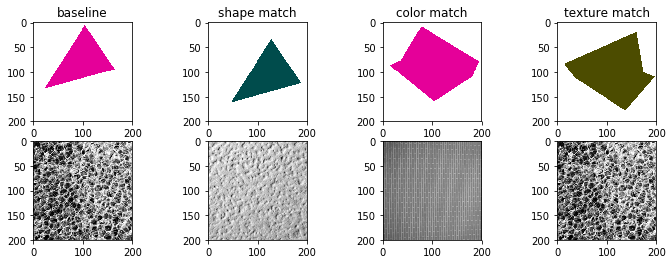

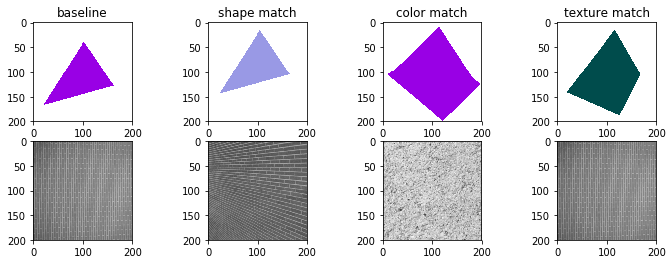

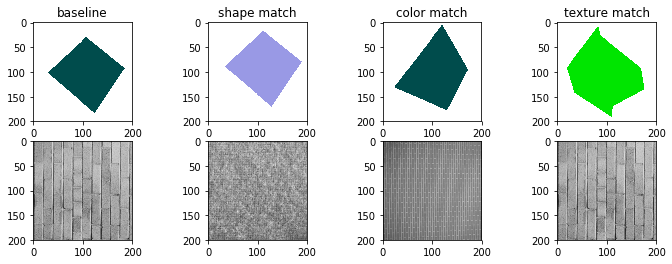

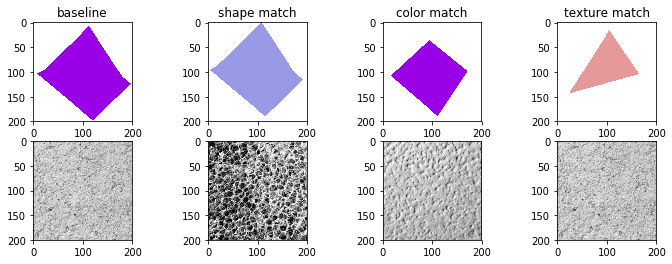

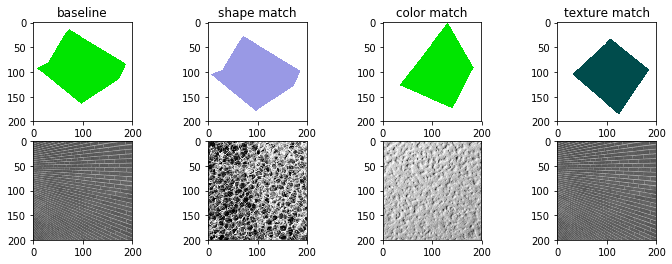

In [78]:
visualize_trials(X_test_o2, 5)

In [79]:
X_test_o1, X_test_o2 = get_test_data(1000, shift_scale=0)

In [80]:
model = cnn3(
    input_shape=X_train.shape[1:], 
    nb_classes=Y_train.shape[-1]
)
perc_shape, perc_color, perc_texture = evaluate_generalization1(
    model, X_test_o2, layer_num=-4,
    batch_size=128
)
print('shape score: %0.3f' % perc_shape)
print('color score: %0.3f' % perc_color)
print('texture score: %0.3f' % perc_texture)

shape score: 0.563
color score: 0.310
texture score: 0.127


In [71]:
model = cnn3(
    input_shape=X_train.shape[1:], 
    nb_classes=Y_train.shape[-1]
)
perc_shape, perc_color, perc_texture = evaluate_generalization1(
    model, X_test_o2, layer_num=-4,
    batch_size=128
)
print('shape score: %0.3f' % perc_shape)
print('color score: %0.3f' % perc_color)
print('texture score: %0.3f' % perc_texture)

shape score: 0.557
color score: 0.286
texture score: 0.157


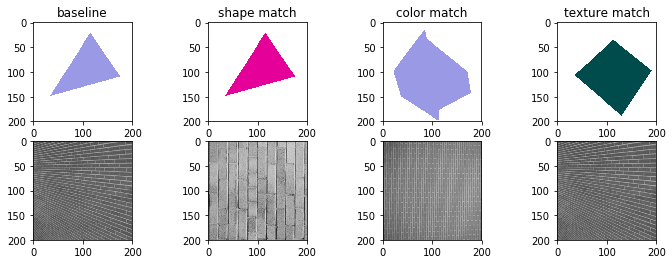

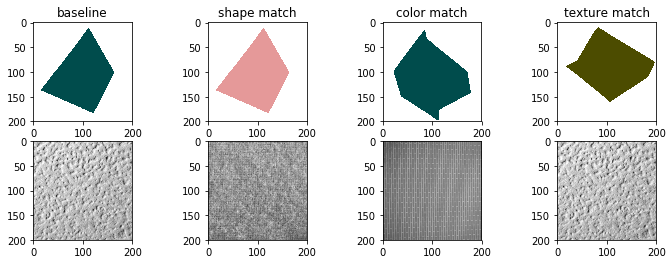

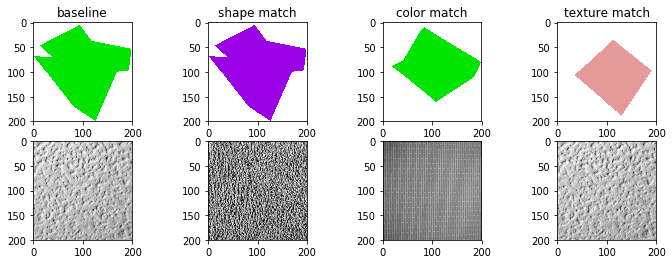

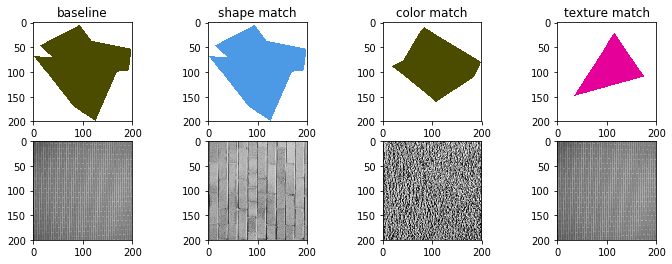

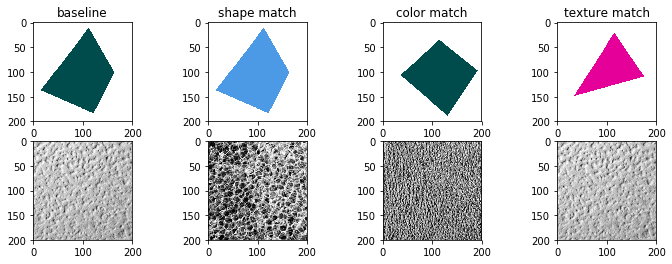

In [75]:
visualize_trials(X_test_o2, 5)

In [81]:
X_test_o1, X_test_o2 = get_test_data(1000, shift_scale=10)

In [82]:
model = cnn3(
    input_shape=X_train.shape[1:], 
    nb_classes=Y_train.shape[-1]
)
perc_shape, perc_color, perc_texture = evaluate_generalization1(
    model, X_test_o2, layer_num=-4,
    batch_size=128
)
print('shape score: %0.3f' % perc_shape)
print('color score: %0.3f' % perc_color)
print('texture score: %0.3f' % perc_texture)

shape score: 0.446
color score: 0.352
texture score: 0.202


## So we should really use shift=20. It is the best way to ensure no shape bias at the beginning.

# Let's see how much noise is due to training set shift vs. model initialization

In [83]:
def model_trial1(
    model_fn, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=5, nb_epoch=100, burn_period=20
):
    scores_o1 = np.zeros(nb_runs)
    scores_o2 = np.zeros(nb_runs)
    X_train_shifted = shift_images(X_train)
    for i in range(nb_runs):
        print('Trial #%i' % (i+1))
        model = model_fn(
            input_shape=X_train.shape[1:], 
            nb_classes=Y_train.shape[-1]
        )
        weights_file = '../data/temp.h5'
        if os.path.isfile(weights_file):
            os.remove(weights_file)
        checkpoint = ModelCheckpoint(
            weights_file,
            monitor='loss',
            save_best_only=True,
            save_weights_only=True,
            period=2
        )
        #X_train_shifted = shift_images(X_train)
        train_model(
            model, X_train_shifted, Y_train, epochs=nb_epoch,
            validation_data=None, batch_size=32,
            checkpoint=checkpoint, burn_period=burn_period
        )
        model.load_weights(weights_file)
        score_o1 = evaluate_generalization(
            model, X_test_o1, layer_num=-4,
            batch_size=128
        )
        score_o2 = evaluate_generalization(
            model, X_test_o2, layer_num=-4,
            batch_size=128
        )
        print('\nScore O1: %0.4f' % score_o1)
        print('Score O2: %0.4f\n' % score_o2)
        scores_o1[i] = score_o1
        scores_o2[i] = score_o2
    
    print('\nScore O1 avg: %0.4f' % scores_o1.mean())
    print('Score O2 avg: %0.4f' % scores_o2.mean())
    return scores_o1, scores_o2

In [84]:
X_train, Y_train = get_train_data(nb_categories, nb_exemplars)
X_test_o1, X_test_o2 = get_test_data(2000, shift_scale=20)

In [93]:
scores_o1, scores_o2 = model_trial(
    cnn3, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 5s 202ms/step - loss: 3.4546 - acc: 0.0800
Epoch 2/50
25/25 [==============================] - 0s 859us/step - loss: 3.2506 - acc: 0.2000
Epoch 3/50
25/25 [==============================] - 0s 841us/step - loss: 3.2109 - acc: 0.1600
Epoch 4/50
25/25 [==============================] - 0s 895us/step - loss: 3.0285 - acc: 0.4800
Epoch 5/50
25/25 [==============================] - 0s 917us/step - loss: 3.0433 - acc: 0.3600
Epoch 6/50
25/25 [==============================] - 0s 833us/step - loss: 2.9871 - acc: 0.2800
Epoch 7/50
25/25 [==============================] - 0s 822us/step - loss: 2.9658 - acc: 0.2800
Epoch 8/50
25/25 [==============================] - 0s 844us/step - loss: 3.0782 - acc: 0.1600
Epoch 9/50
25/25 [==============================] - 0s 851us/step - loss: 3.0014 - acc: 0.3200
Epoch 10/50
25/25 [==============================] - 0s 815us/step - loss: 2.9799 - acc: 0.2400
Epoch 11/50
25/25 [=====================

Epoch 37/150
25/25 [==============================] - 0s 771us/step - loss: 1.1263 - acc: 0.9200
Epoch 38/150
25/25 [==============================] - 0s 773us/step - loss: 1.2514 - acc: 0.7600
Epoch 39/150
25/25 [==============================] - 0s 770us/step - loss: 1.3097 - acc: 0.8000
Epoch 40/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1425 - acc: 0.9200
Epoch 41/150
25/25 [==============================] - 0s 782us/step - loss: 1.1197 - acc: 0.9600
Epoch 42/150
25/25 [==============================] - 0s 1ms/step - loss: 0.9877 - acc: 0.9600
Epoch 43/150
25/25 [==============================] - 0s 753us/step - loss: 1.0492 - acc: 0.9600
Epoch 44/150
25/25 [==============================] - 0s 740us/step - loss: 1.0405 - acc: 0.9200
Epoch 45/150
25/25 [==============================] - 0s 762us/step - loss: 1.0373 - acc: 0.9600
Epoch 46/150
25/25 [==============================] - 0s 731us/step - loss: 1.0617 - acc: 0.9200
Epoch 47/150
25/25 [==============

Epoch 122/150
25/25 [==============================] - 0s 764us/step - loss: 0.7612 - acc: 0.9600
Epoch 123/150
25/25 [==============================] - 0s 797us/step - loss: 0.6900 - acc: 0.9600
Epoch 124/150
25/25 [==============================] - 0s 796us/step - loss: 0.7006 - acc: 0.9600
Epoch 125/150
25/25 [==============================] - 0s 803us/step - loss: 0.6491 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 762us/step - loss: 0.6644 - acc: 0.9600
Epoch 127/150
25/25 [==============================] - 0s 803us/step - loss: 0.6231 - acc: 1.0000
Epoch 128/150
25/25 [==============================] - 0s 3ms/step - loss: 0.6046 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 774us/step - loss: 0.6002 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 779us/step - loss: 0.7856 - acc: 0.8400
Epoch 131/150
25/25 [==============================] - 0s 761us/step - loss: 0.7063 - acc: 0.9600
Epoch 132/150
25/25 [=

Epoch 7/150
25/25 [==============================] - 0s 834us/step - loss: 1.3889 - acc: 0.7600
Epoch 8/150
25/25 [==============================] - 0s 832us/step - loss: 1.5695 - acc: 0.6800
Epoch 9/150
25/25 [==============================] - 0s 860us/step - loss: 1.3093 - acc: 0.8800
Epoch 10/150
25/25 [==============================] - 0s 809us/step - loss: 1.4201 - acc: 0.7600
Epoch 11/150
25/25 [==============================] - 0s 763us/step - loss: 1.3754 - acc: 0.8000
Epoch 12/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1675 - acc: 0.8800
Epoch 13/150
25/25 [==============================] - 0s 847us/step - loss: 1.1964 - acc: 0.8800
Epoch 14/150
25/25 [==============================] - 0s 809us/step - loss: 1.2324 - acc: 0.7600
Epoch 15/150
25/25 [==============================] - 0s 892us/step - loss: 1.1631 - acc: 0.9600
Epoch 16/150
25/25 [==============================] - 0s 808us/step - loss: 1.3212 - acc: 0.7600
Epoch 17/150
25/25 [===============

Epoch 92/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6601 - acc: 0.9600
Epoch 93/150
25/25 [==============================] - 0s 835us/step - loss: 0.7161 - acc: 0.9200
Epoch 94/150
25/25 [==============================] - 0s 797us/step - loss: 0.7545 - acc: 0.9200
Epoch 95/150
25/25 [==============================] - 0s 787us/step - loss: 0.7710 - acc: 0.9200
Epoch 96/150
25/25 [==============================] - 0s 836us/step - loss: 0.8918 - acc: 0.9200
Epoch 97/150
25/25 [==============================] - 0s 793us/step - loss: 0.7418 - acc: 0.9600
Epoch 98/150
25/25 [==============================] - 0s 772us/step - loss: 0.6841 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 806us/step - loss: 0.6022 - acc: 1.0000
Epoch 100/150
25/25 [==============================] - 0s 778us/step - loss: 0.6746 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 770us/step - loss: 0.7357 - acc: 0.9200
Epoch 102/150
25/25 [=========

Epoch 26/50
25/25 [==============================] - 0s 728us/step - loss: 2.1868 - acc: 0.4800
Epoch 27/50
25/25 [==============================] - 0s 753us/step - loss: 2.1602 - acc: 0.7200
Epoch 28/50
25/25 [==============================] - 0s 857us/step - loss: 1.9526 - acc: 0.7200
Epoch 29/50
25/25 [==============================] - 0s 809us/step - loss: 2.0635 - acc: 0.5600
Epoch 30/50
25/25 [==============================] - 0s 794us/step - loss: 2.0886 - acc: 0.7200
Epoch 31/50
25/25 [==============================] - 0s 822us/step - loss: 1.9511 - acc: 0.7600
Epoch 32/50
25/25 [==============================] - 0s 848us/step - loss: 1.9637 - acc: 0.6800
Epoch 33/50
25/25 [==============================] - 0s 767us/step - loss: 2.0003 - acc: 0.7200
Epoch 34/50
25/25 [==============================] - 0s 801us/step - loss: 1.9650 - acc: 0.7600
Epoch 35/50
25/25 [==============================] - 0s 725us/step - loss: 1.8753 - acc: 0.7600
Epoch 36/50
25/25 [=====================

25/25 [==============================] - 0s 727us/step - loss: 0.9506 - acc: 0.9200
Epoch 62/150
25/25 [==============================] - 0s 787us/step - loss: 0.8857 - acc: 0.8800
Epoch 63/150
25/25 [==============================] - 0s 729us/step - loss: 0.8609 - acc: 0.9600
Epoch 64/150
25/25 [==============================] - 0s 757us/step - loss: 0.8618 - acc: 0.9200
Epoch 65/150
25/25 [==============================] - 0s 784us/step - loss: 0.9000 - acc: 0.9200
Epoch 66/150
25/25 [==============================] - 0s 786us/step - loss: 1.1442 - acc: 0.9600
Epoch 67/150
25/25 [==============================] - 0s 766us/step - loss: 0.9790 - acc: 0.9600
Epoch 68/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8354 - acc: 0.9600
Epoch 69/150
25/25 [==============================] - 0s 835us/step - loss: 0.8151 - acc: 0.9600
Epoch 70/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8285 - acc: 1.0000
Epoch 71/150
25/25 [===========================

Epoch 146/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5544 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 860us/step - loss: 0.7129 - acc: 0.9600
Epoch 148/150
25/25 [==============================] - 0s 823us/step - loss: 0.5884 - acc: 1.0000
Epoch 149/150
25/25 [==============================] - 0s 781us/step - loss: 0.6317 - acc: 0.9200
Epoch 150/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5320 - acc: 1.0000

Score O1: 0.7490
Score O2: 0.4385

Trial #4
Epoch 1/50
25/25 [==============================] - 4s 165ms/step - loss: 3.9963 - acc: 0.2000
Epoch 2/50
25/25 [==============================] - 0s 858us/step - loss: 3.2683 - acc: 0.2800
Epoch 3/50
25/25 [==============================] - 0s 805us/step - loss: 3.4001 - acc: 0.1200
Epoch 4/50
25/25 [==============================] - 0s 824us/step - loss: 3.1161 - acc: 0.3200
Epoch 5/50
25/25 [==============================] - 0s 724us/step - loss: 3.1974 - acc: 0

Epoch 31/150
25/25 [==============================] - 0s 774us/step - loss: 1.4237 - acc: 0.8400
Epoch 32/150
25/25 [==============================] - 0s 786us/step - loss: 1.3984 - acc: 0.8800
Epoch 33/150
25/25 [==============================] - 0s 833us/step - loss: 1.7986 - acc: 0.6400
Epoch 34/150
25/25 [==============================] - 0s 849us/step - loss: 1.5239 - acc: 0.7200
Epoch 35/150
25/25 [==============================] - 0s 815us/step - loss: 1.4105 - acc: 0.7200
Epoch 36/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2556 - acc: 0.9200
Epoch 37/150
25/25 [==============================] - 0s 857us/step - loss: 1.3496 - acc: 0.7600
Epoch 38/150
25/25 [==============================] - 0s 860us/step - loss: 1.4630 - acc: 0.7600
Epoch 39/150
25/25 [==============================] - 0s 826us/step - loss: 1.4390 - acc: 0.8000
Epoch 40/150
25/25 [==============================] - 0s 848us/step - loss: 1.2741 - acc: 0.8800
Epoch 41/150
25/25 [============

Epoch 116/150
25/25 [==============================] - 0s 810us/step - loss: 0.8241 - acc: 0.9600
Epoch 117/150
25/25 [==============================] - 0s 878us/step - loss: 0.8258 - acc: 0.8800
Epoch 118/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7395 - acc: 0.9600
Epoch 119/150
25/25 [==============================] - 0s 843us/step - loss: 0.8960 - acc: 0.8800
Epoch 120/150
25/25 [==============================] - 0s 799us/step - loss: 0.7895 - acc: 0.9600
Epoch 121/150
25/25 [==============================] - 0s 743us/step - loss: 0.7484 - acc: 1.0000
Epoch 122/150
25/25 [==============================] - 0s 831us/step - loss: 0.8090 - acc: 0.9200
Epoch 123/150
25/25 [==============================] - 0s 724us/step - loss: 0.8103 - acc: 0.9600
Epoch 124/150
25/25 [==============================] - 0s 797us/step - loss: 0.7584 - acc: 0.9600
Epoch 125/150
25/25 [==============================] - 0s 792us/step - loss: 0.7799 - acc: 0.9600
Epoch 126/150
25/25 [=

Epoch 1/150
25/25 [==============================] - 0s 773us/step - loss: 1.9719 - acc: 0.5600
Epoch 2/150
25/25 [==============================] - 2s 63ms/step - loss: 1.9911 - acc: 0.6000
Epoch 3/150
25/25 [==============================] - 0s 806us/step - loss: 1.9420 - acc: 0.6000
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 1.7271 - acc: 0.6400
Epoch 5/150
25/25 [==============================] - 0s 720us/step - loss: 1.5909 - acc: 0.8000
Epoch 6/150
25/25 [==============================] - 0s 787us/step - loss: 1.7303 - acc: 0.6800
Epoch 7/150
25/25 [==============================] - 0s 766us/step - loss: 1.8111 - acc: 0.7200
Epoch 8/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6982 - acc: 0.7200
Epoch 9/150
25/25 [==============================] - 0s 766us/step - loss: 1.6673 - acc: 0.7200
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6669 - acc: 0.6000
Epoch 11/150
25/25 [==========================

Epoch 86/150
25/25 [==============================] - 0s 760us/step - loss: 0.9572 - acc: 0.8800
Epoch 87/150
25/25 [==============================] - 0s 752us/step - loss: 0.9792 - acc: 0.8800
Epoch 88/150
25/25 [==============================] - 0s 765us/step - loss: 0.8715 - acc: 0.9600
Epoch 89/150
25/25 [==============================] - 0s 770us/step - loss: 0.9776 - acc: 0.9600
Epoch 90/150
25/25 [==============================] - 0s 742us/step - loss: 0.9421 - acc: 0.8800
Epoch 91/150
25/25 [==============================] - 0s 801us/step - loss: 1.0387 - acc: 0.8800
Epoch 92/150
25/25 [==============================] - 0s 796us/step - loss: 1.1109 - acc: 0.8400
Epoch 93/150
25/25 [==============================] - 0s 757us/step - loss: 0.9719 - acc: 0.8400
Epoch 94/150
25/25 [==============================] - 0s 757us/step - loss: 0.8482 - acc: 0.9200
Epoch 95/150
25/25 [==============================] - 0s 740us/step - loss: 0.9258 - acc: 0.9200
Epoch 96/150
25/25 [==========

Epoch 20/50
25/25 [==============================] - 0s 768us/step - loss: 2.8267 - acc: 0.3200
Epoch 21/50
25/25 [==============================] - 0s 787us/step - loss: 2.7303 - acc: 0.3600
Epoch 22/50
25/25 [==============================] - 0s 752us/step - loss: 2.7555 - acc: 0.2000
Epoch 23/50
25/25 [==============================] - 0s 744us/step - loss: 2.7575 - acc: 0.3600
Epoch 24/50
25/25 [==============================] - 0s 803us/step - loss: 2.6728 - acc: 0.4000
Epoch 25/50
25/25 [==============================] - 0s 695us/step - loss: 2.6860 - acc: 0.4400
Epoch 26/50
25/25 [==============================] - 0s 777us/step - loss: 2.6766 - acc: 0.2800
Epoch 27/50
25/25 [==============================] - 0s 764us/step - loss: 2.5985 - acc: 0.4800
Epoch 28/50
25/25 [==============================] - 0s 747us/step - loss: 2.6435 - acc: 0.4000
Epoch 29/50
25/25 [==============================] - 0s 831us/step - loss: 2.6186 - acc: 0.4000
Epoch 30/50
25/25 [=====================

25/25 [==============================] - 0s 765us/step - loss: 1.4585 - acc: 0.8000
Epoch 56/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2654 - acc: 0.8800
Epoch 57/150
25/25 [==============================] - 0s 798us/step - loss: 1.4309 - acc: 0.6800
Epoch 58/150
25/25 [==============================] - 0s 795us/step - loss: 1.2976 - acc: 0.8800
Epoch 59/150
25/25 [==============================] - 0s 802us/step - loss: 1.3509 - acc: 0.8800
Epoch 60/150
25/25 [==============================] - 0s 750us/step - loss: 1.3319 - acc: 0.8800
Epoch 61/150
25/25 [==============================] - 0s 774us/step - loss: 1.2972 - acc: 0.9200
Epoch 62/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1125 - acc: 0.8800
Epoch 63/150
25/25 [==============================] - 0s 829us/step - loss: 1.3628 - acc: 0.7600
Epoch 64/150
25/25 [==============================] - 0s 821us/step - loss: 1.4080 - acc: 0.8000
Epoch 65/150
25/25 [===========================

Epoch 140/150
25/25 [==============================] - 0s 825us/step - loss: 0.8584 - acc: 0.9200
Epoch 141/150
25/25 [==============================] - 0s 818us/step - loss: 0.7428 - acc: 1.0000
Epoch 142/150
25/25 [==============================] - 0s 755us/step - loss: 0.8202 - acc: 0.9200
Epoch 143/150
25/25 [==============================] - 0s 771us/step - loss: 0.7709 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 0s 837us/step - loss: 0.8063 - acc: 0.9600
Epoch 145/150
25/25 [==============================] - 0s 833us/step - loss: 0.8681 - acc: 0.8800
Epoch 146/150
25/25 [==============================] - 0s 761us/step - loss: 0.8855 - acc: 0.8800
Epoch 147/150
25/25 [==============================] - 0s 758us/step - loss: 0.7423 - acc: 1.0000
Epoch 148/150
25/25 [==============================] - 0s 752us/step - loss: 0.9442 - acc: 0.8400
Epoch 149/150
25/25 [==============================] - 0s 814us/step - loss: 0.7847 - acc: 0.9600
Epoch 150/150
25/25 

Epoch 25/150
25/25 [==============================] - 0s 779us/step - loss: 1.4154 - acc: 0.8000
Epoch 26/150
25/25 [==============================] - 0s 725us/step - loss: 1.3082 - acc: 0.7600
Epoch 27/150
25/25 [==============================] - 0s 767us/step - loss: 1.2045 - acc: 0.9200
Epoch 28/150
25/25 [==============================] - 0s 770us/step - loss: 1.2704 - acc: 0.9200
Epoch 29/150
25/25 [==============================] - 0s 738us/step - loss: 1.1711 - acc: 0.9200
Epoch 30/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2479 - acc: 0.9200
Epoch 31/150
25/25 [==============================] - 0s 833us/step - loss: 1.1569 - acc: 1.0000
Epoch 32/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1423 - acc: 0.8800
Epoch 33/150
25/25 [==============================] - 0s 758us/step - loss: 1.2885 - acc: 0.7600
Epoch 34/150
25/25 [==============================] - 0s 834us/step - loss: 1.2673 - acc: 0.8800
Epoch 35/150
25/25 [==============

Epoch 110/150
25/25 [==============================] - 0s 742us/step - loss: 0.7251 - acc: 0.9600
Epoch 111/150
25/25 [==============================] - 0s 770us/step - loss: 0.6315 - acc: 1.0000
Epoch 112/150
25/25 [==============================] - 0s 731us/step - loss: 0.6709 - acc: 1.0000
Epoch 113/150
25/25 [==============================] - 0s 726us/step - loss: 0.6610 - acc: 1.0000
Epoch 114/150
25/25 [==============================] - 0s 693us/step - loss: 0.7529 - acc: 0.9600
Epoch 115/150
25/25 [==============================] - 0s 721us/step - loss: 0.6300 - acc: 1.0000
Epoch 116/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6592 - acc: 0.9600
Epoch 117/150
25/25 [==============================] - 0s 750us/step - loss: 0.7738 - acc: 0.9200
Epoch 118/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5796 - acc: 1.0000
Epoch 119/150
25/25 [==============================] - 0s 751us/step - loss: 0.6011 - acc: 1.0000
Epoch 120/150
25/25 [===

Epoch 45/50
25/25 [==============================] - 0s 693us/step - loss: 2.1473 - acc: 0.4400
Epoch 46/50
25/25 [==============================] - 0s 699us/step - loss: 2.2583 - acc: 0.4400
Epoch 47/50
25/25 [==============================] - 0s 785us/step - loss: 2.0789 - acc: 0.5600
Epoch 48/50
25/25 [==============================] - 0s 696us/step - loss: 1.9639 - acc: 0.7200
Epoch 49/50
25/25 [==============================] - 0s 752us/step - loss: 2.1149 - acc: 0.4800
Epoch 50/50
25/25 [==============================] - 0s 871us/step - loss: 2.1036 - acc: 0.5600
Epoch 1/150
25/25 [==============================] - 0s 798us/step - loss: 1.9274 - acc: 0.6000
Epoch 2/150
25/25 [==============================] - 2s 78ms/step - loss: 2.2851 - acc: 0.3600
Epoch 3/150
25/25 [==============================] - 0s 2ms/step - loss: 1.9016 - acc: 0.6800
Epoch 4/150
25/25 [==============================] - 0s 2ms/step - loss: 1.9576 - acc: 0.5600
Epoch 5/150
25/25 [==========================

Epoch 80/150
25/25 [==============================] - 0s 805us/step - loss: 1.0992 - acc: 0.8800
Epoch 81/150
25/25 [==============================] - 0s 859us/step - loss: 1.2786 - acc: 0.7200
Epoch 82/150
25/25 [==============================] - 0s 840us/step - loss: 1.0361 - acc: 0.8800
Epoch 83/150
25/25 [==============================] - 0s 771us/step - loss: 0.9282 - acc: 0.9600
Epoch 84/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9992 - acc: 0.9600
Epoch 85/150
25/25 [==============================] - 0s 879us/step - loss: 1.1783 - acc: 0.8000
Epoch 86/150
25/25 [==============================] - 0s 921us/step - loss: 1.1195 - acc: 0.8000
Epoch 87/150
25/25 [==============================] - 0s 848us/step - loss: 0.9626 - acc: 0.8800
Epoch 88/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9878 - acc: 0.8800
Epoch 89/150
25/25 [==============================] - 0s 919us/step - loss: 1.1814 - acc: 0.7200
Epoch 90/150
25/25 [==============

Epoch 14/50
25/25 [==============================] - 0s 790us/step - loss: 2.7809 - acc: 0.2800
Epoch 15/50
25/25 [==============================] - 0s 803us/step - loss: 2.7486 - acc: 0.4000
Epoch 16/50
25/25 [==============================] - 0s 815us/step - loss: 2.7030 - acc: 0.3600
Epoch 17/50
25/25 [==============================] - 0s 792us/step - loss: 2.6170 - acc: 0.3600
Epoch 18/50
25/25 [==============================] - 0s 782us/step - loss: 2.6710 - acc: 0.3200
Epoch 19/50
25/25 [==============================] - 0s 808us/step - loss: 2.6699 - acc: 0.4400
Epoch 20/50
25/25 [==============================] - 0s 802us/step - loss: 2.7007 - acc: 0.2800
Epoch 21/50
25/25 [==============================] - 0s 821us/step - loss: 2.6681 - acc: 0.5200
Epoch 22/50
25/25 [==============================] - 0s 817us/step - loss: 2.6479 - acc: 0.3600
Epoch 23/50
25/25 [==============================] - 0s 827us/step - loss: 2.6207 - acc: 0.3600
Epoch 24/50
25/25 [=====================

Epoch 50/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3634 - acc: 0.7600
Epoch 51/150
25/25 [==============================] - 0s 826us/step - loss: 1.1575 - acc: 0.9600
Epoch 52/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1691 - acc: 0.8800
Epoch 53/150
25/25 [==============================] - 0s 777us/step - loss: 1.3288 - acc: 0.8000
Epoch 54/150
25/25 [==============================] - 0s 777us/step - loss: 1.3339 - acc: 0.7600
Epoch 55/150
25/25 [==============================] - 0s 776us/step - loss: 1.4178 - acc: 0.6400
Epoch 56/150
25/25 [==============================] - 0s 775us/step - loss: 1.2316 - acc: 0.8000
Epoch 57/150
25/25 [==============================] - 0s 790us/step - loss: 1.1497 - acc: 0.8400
Epoch 58/150
25/25 [==============================] - 0s 1ms/step - loss: 1.1096 - acc: 0.8000
Epoch 59/150
25/25 [==============================] - 0s 818us/step - loss: 1.0727 - acc: 0.8800
Epoch 60/150
25/25 [================

Epoch 135/150
25/25 [==============================] - 0s 812us/step - loss: 0.8630 - acc: 0.9200
Epoch 136/150
25/25 [==============================] - 0s 853us/step - loss: 0.7217 - acc: 0.9600
Epoch 137/150
25/25 [==============================] - 0s 871us/step - loss: 0.6614 - acc: 1.0000
Epoch 138/150
25/25 [==============================] - 0s 883us/step - loss: 0.7440 - acc: 0.9200
Epoch 139/150
25/25 [==============================] - 0s 925us/step - loss: 0.7176 - acc: 0.9600
Epoch 140/150
25/25 [==============================] - 0s 878us/step - loss: 0.7466 - acc: 0.9200
Epoch 141/150
25/25 [==============================] - 0s 846us/step - loss: 0.7464 - acc: 0.9600
Epoch 142/150
25/25 [==============================] - 0s 828us/step - loss: 0.7001 - acc: 0.9600
Epoch 143/150
25/25 [==============================] - 0s 852us/step - loss: 0.6572 - acc: 0.9600
Epoch 144/150
25/25 [==============================] - 0s 867us/step - loss: 0.7017 - acc: 0.9600
Epoch 145/150
25/25 

Epoch 20/150
25/25 [==============================] - 0s 2ms/step - loss: 1.6726 - acc: 0.6800
Epoch 21/150
25/25 [==============================] - 0s 820us/step - loss: 1.8451 - acc: 0.6400
Epoch 22/150
25/25 [==============================] - 0s 870us/step - loss: 1.8140 - acc: 0.5200
Epoch 23/150
25/25 [==============================] - 0s 845us/step - loss: 1.7807 - acc: 0.5600
Epoch 24/150
25/25 [==============================] - 0s 850us/step - loss: 1.8088 - acc: 0.5600
Epoch 25/150
25/25 [==============================] - 0s 821us/step - loss: 1.7969 - acc: 0.4800
Epoch 26/150
25/25 [==============================] - 0s 2ms/step - loss: 1.6091 - acc: 0.6000
Epoch 27/150
25/25 [==============================] - 0s 787us/step - loss: 1.4544 - acc: 0.7600
Epoch 28/150
25/25 [==============================] - 0s 821us/step - loss: 1.6684 - acc: 0.6000
Epoch 29/150
25/25 [==============================] - 0s 822us/step - loss: 1.4508 - acc: 0.8400
Epoch 30/150
25/25 [==============

Epoch 105/150
25/25 [==============================] - 0s 934us/step - loss: 0.9382 - acc: 0.8800
Epoch 106/150
25/25 [==============================] - 0s 847us/step - loss: 0.9771 - acc: 0.8000
Epoch 107/150
25/25 [==============================] - 0s 889us/step - loss: 0.8115 - acc: 0.9600
Epoch 108/150
25/25 [==============================] - 0s 927us/step - loss: 0.9159 - acc: 0.8800
Epoch 109/150
25/25 [==============================] - 0s 905us/step - loss: 0.8497 - acc: 0.9200
Epoch 110/150
25/25 [==============================] - 0s 851us/step - loss: 0.8607 - acc: 0.8800
Epoch 111/150
25/25 [==============================] - 0s 856us/step - loss: 0.8790 - acc: 0.9600
Epoch 112/150
25/25 [==============================] - 0s 833us/step - loss: 1.0092 - acc: 0.8000
Epoch 113/150
25/25 [==============================] - 0s 830us/step - loss: 1.0114 - acc: 0.8400
Epoch 114/150
25/25 [==============================] - 0s 851us/step - loss: 0.9908 - acc: 0.8000
Epoch 115/150
25/25 

In [94]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.8262
Score O2 avg: 0.4681
Score O2 std: 0.0708


In [95]:
scores_o1, scores_o2 = model_trial1(
    cnn3, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 5s 191ms/step - loss: 4.4562 - acc: 0.2400
Epoch 2/50
25/25 [==============================] - 0s 1ms/step - loss: 3.5135 - acc: 0.1600
Epoch 3/50
25/25 [==============================] - 0s 818us/step - loss: 3.2595 - acc: 0.2400
Epoch 4/50
25/25 [==============================] - 0s 839us/step - loss: 3.0939 - acc: 0.3600
Epoch 5/50
25/25 [==============================] - 0s 835us/step - loss: 3.0910 - acc: 0.2800
Epoch 6/50
25/25 [==============================] - 0s 784us/step - loss: 3.1955 - acc: 0.2000
Epoch 7/50
25/25 [==============================] - 0s 789us/step - loss: 3.3113 - acc: 0.0400
Epoch 8/50
25/25 [==============================] - 0s 793us/step - loss: 3.1834 - acc: 0.2800
Epoch 9/50
25/25 [==============================] - 0s 784us/step - loss: 3.0937 - acc: 0.1200
Epoch 10/50
25/25 [==============================] - 0s 750us/step - loss: 3.1036 - acc: 0.2000
Epoch 11/50
25/25 [=======================

Epoch 37/150
25/25 [==============================] - 0s 794us/step - loss: 1.3199 - acc: 0.8800
Epoch 38/150
25/25 [==============================] - 0s 785us/step - loss: 1.5272 - acc: 0.7600
Epoch 39/150
25/25 [==============================] - 0s 767us/step - loss: 1.2540 - acc: 0.8800
Epoch 40/150
25/25 [==============================] - 0s 756us/step - loss: 1.5121 - acc: 0.7600
Epoch 41/150
25/25 [==============================] - 0s 768us/step - loss: 1.5593 - acc: 0.6800
Epoch 42/150
25/25 [==============================] - 0s 803us/step - loss: 1.6223 - acc: 0.6400
Epoch 43/150
25/25 [==============================] - 0s 794us/step - loss: 1.3634 - acc: 0.8800
Epoch 44/150
25/25 [==============================] - 0s 1ms/step - loss: 1.3205 - acc: 0.9600
Epoch 45/150
25/25 [==============================] - 0s 736us/step - loss: 1.3771 - acc: 0.8400
Epoch 46/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2497 - acc: 0.8400
Epoch 47/150
25/25 [==============

Epoch 122/150
25/25 [==============================] - 0s 754us/step - loss: 0.8016 - acc: 0.8800
Epoch 123/150
25/25 [==============================] - 0s 798us/step - loss: 0.8543 - acc: 0.8800
Epoch 124/150
25/25 [==============================] - 0s 731us/step - loss: 0.7437 - acc: 0.9600
Epoch 125/150
25/25 [==============================] - 0s 773us/step - loss: 0.7488 - acc: 0.9600
Epoch 126/150
25/25 [==============================] - 0s 754us/step - loss: 0.7870 - acc: 0.9200
Epoch 127/150
25/25 [==============================] - 0s 770us/step - loss: 0.7674 - acc: 0.9200
Epoch 128/150
25/25 [==============================] - 0s 768us/step - loss: 0.7506 - acc: 0.9600
Epoch 129/150
25/25 [==============================] - 0s 784us/step - loss: 0.6856 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 790us/step - loss: 0.7566 - acc: 0.9600
Epoch 131/150
25/25 [==============================] - 0s 761us/step - loss: 0.7129 - acc: 1.0000
Epoch 132/150
25/25 

Epoch 7/150
25/25 [==============================] - 0s 726us/step - loss: 1.5998 - acc: 0.6800
Epoch 8/150
25/25 [==============================] - 0s 1ms/step - loss: 1.6036 - acc: 0.6800
Epoch 9/150
25/25 [==============================] - 0s 712us/step - loss: 1.4933 - acc: 0.8000
Epoch 10/150
25/25 [==============================] - 0s 780us/step - loss: 1.6916 - acc: 0.5600
Epoch 11/150
25/25 [==============================] - 0s 717us/step - loss: 1.4985 - acc: 0.6800
Epoch 12/150
25/25 [==============================] - 0s 1ms/step - loss: 1.4008 - acc: 0.8800
Epoch 13/150
25/25 [==============================] - 0s 759us/step - loss: 1.4007 - acc: 0.8000
Epoch 14/150
25/25 [==============================] - 0s 682us/step - loss: 1.6125 - acc: 0.6400
Epoch 15/150
25/25 [==============================] - 0s 713us/step - loss: 1.3565 - acc: 0.8400
Epoch 16/150
25/25 [==============================] - 0s 719us/step - loss: 1.4684 - acc: 0.7600
Epoch 17/150
25/25 [=================

Epoch 92/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6278 - acc: 1.0000
Epoch 93/150
25/25 [==============================] - 0s 802us/step - loss: 0.7245 - acc: 0.9600
Epoch 94/150
25/25 [==============================] - 0s 748us/step - loss: 0.6597 - acc: 1.0000
Epoch 95/150
25/25 [==============================] - 0s 804us/step - loss: 0.7062 - acc: 0.9600
Epoch 96/150
25/25 [==============================] - 0s 861us/step - loss: 0.7172 - acc: 0.8800
Epoch 97/150
25/25 [==============================] - 0s 875us/step - loss: 0.9983 - acc: 0.8000
Epoch 98/150
25/25 [==============================] - 0s 856us/step - loss: 0.7498 - acc: 0.9200
Epoch 99/150
25/25 [==============================] - 0s 855us/step - loss: 0.7974 - acc: 0.9200
Epoch 100/150
25/25 [==============================] - 0s 859us/step - loss: 0.8040 - acc: 0.8800
Epoch 101/150
25/25 [==============================] - 0s 840us/step - loss: 0.7985 - acc: 0.9600
Epoch 102/150
25/25 [=========

25/25 [==============================] - 0s 760us/step - loss: 2.3306 - acc: 0.5200
Epoch 27/50
25/25 [==============================] - 0s 739us/step - loss: 2.4867 - acc: 0.4400
Epoch 28/50
25/25 [==============================] - 0s 759us/step - loss: 2.3856 - acc: 0.4400
Epoch 29/50
25/25 [==============================] - 0s 784us/step - loss: 2.2386 - acc: 0.6000
Epoch 30/50
25/25 [==============================] - 0s 759us/step - loss: 2.4558 - acc: 0.3600
Epoch 31/50
25/25 [==============================] - 0s 721us/step - loss: 2.2491 - acc: 0.5200
Epoch 32/50
25/25 [==============================] - 0s 741us/step - loss: 2.2464 - acc: 0.5600
Epoch 33/50
25/25 [==============================] - 0s 771us/step - loss: 2.2496 - acc: 0.6400
Epoch 34/50
25/25 [==============================] - 0s 748us/step - loss: 2.1646 - acc: 0.6000
Epoch 35/50
25/25 [==============================] - 0s 755us/step - loss: 2.0621 - acc: 0.5200
Epoch 36/50
25/25 [==============================] -

25/25 [==============================] - 0s 905us/step - loss: 1.1902 - acc: 0.7600
Epoch 62/150
25/25 [==============================] - 0s 882us/step - loss: 1.0660 - acc: 0.8400
Epoch 63/150
25/25 [==============================] - 0s 890us/step - loss: 0.9838 - acc: 0.9600
Epoch 64/150
25/25 [==============================] - 0s 880us/step - loss: 1.2139 - acc: 0.8000
Epoch 65/150
25/25 [==============================] - 0s 859us/step - loss: 1.0781 - acc: 0.9200
Epoch 66/150
25/25 [==============================] - 0s 839us/step - loss: 1.0827 - acc: 0.8800
Epoch 67/150
25/25 [==============================] - 0s 850us/step - loss: 0.9484 - acc: 0.9600
Epoch 68/150
25/25 [==============================] - 0s 829us/step - loss: 1.0744 - acc: 0.8800
Epoch 69/150
25/25 [==============================] - 0s 825us/step - loss: 0.9035 - acc: 1.0000
Epoch 70/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0036 - acc: 0.9600
Epoch 71/150
25/25 [=========================

Epoch 146/150
25/25 [==============================] - 0s 919us/step - loss: 0.7216 - acc: 0.9600
Epoch 147/150
25/25 [==============================] - 0s 923us/step - loss: 0.7133 - acc: 0.9600
Epoch 148/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6777 - acc: 0.9600
Epoch 149/150
25/25 [==============================] - 0s 857us/step - loss: 0.6902 - acc: 1.0000
Epoch 150/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6400 - acc: 1.0000

Score O1: 0.8875
Score O2: 0.5570

Trial #4
Epoch 1/50
25/25 [==============================] - 6s 226ms/step - loss: 3.3982 - acc: 0.2800
Epoch 2/50
25/25 [==============================] - 0s 913us/step - loss: 3.4625 - acc: 0.1600
Epoch 3/50
25/25 [==============================] - 0s 863us/step - loss: 3.2207 - acc: 0.2800
Epoch 4/50
25/25 [==============================] - 0s 834us/step - loss: 3.2053 - acc: 0.1600
Epoch 5/50
25/25 [==============================] - 0s 825us/step - loss: 2.9559 - acc: 0

Epoch 31/150
25/25 [==============================] - 0s 774us/step - loss: 1.2275 - acc: 0.9200
Epoch 32/150
25/25 [==============================] - 0s 785us/step - loss: 1.4976 - acc: 0.6800
Epoch 33/150
25/25 [==============================] - 0s 815us/step - loss: 1.3592 - acc: 0.8400
Epoch 34/150
25/25 [==============================] - 0s 831us/step - loss: 1.3137 - acc: 0.8800
Epoch 35/150
25/25 [==============================] - 0s 838us/step - loss: 1.3969 - acc: 0.8400
Epoch 36/150
25/25 [==============================] - 0s 802us/step - loss: 1.2656 - acc: 0.8800
Epoch 37/150
25/25 [==============================] - 0s 764us/step - loss: 1.4802 - acc: 0.6800
Epoch 38/150
25/25 [==============================] - 0s 758us/step - loss: 1.5345 - acc: 0.6400
Epoch 39/150
25/25 [==============================] - 0s 786us/step - loss: 1.1813 - acc: 0.9600
Epoch 40/150
25/25 [==============================] - 0s 802us/step - loss: 1.3426 - acc: 0.8800
Epoch 41/150
25/25 [==========

Epoch 116/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7403 - acc: 1.0000
Epoch 117/150
25/25 [==============================] - 0s 752us/step - loss: 0.7606 - acc: 0.9600
Epoch 118/150
25/25 [==============================] - 0s 802us/step - loss: 0.8532 - acc: 0.9600
Epoch 119/150
25/25 [==============================] - 0s 752us/step - loss: 0.9433 - acc: 0.8800
Epoch 120/150
25/25 [==============================] - 0s 766us/step - loss: 0.7410 - acc: 0.9600
Epoch 121/150
25/25 [==============================] - 0s 763us/step - loss: 0.7912 - acc: 0.9600
Epoch 122/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6623 - acc: 1.0000
Epoch 123/150
25/25 [==============================] - 0s 737us/step - loss: 0.9129 - acc: 0.8400
Epoch 124/150
25/25 [==============================] - 0s 799us/step - loss: 0.7066 - acc: 0.9600
Epoch 125/150
25/25 [==============================] - 0s 722us/step - loss: 0.8212 - acc: 0.9200
Epoch 126/150
25/25 [===

Epoch 1/150
25/25 [==============================] - 0s 823us/step - loss: 1.8875 - acc: 0.6000
Epoch 2/150
25/25 [==============================] - 2s 67ms/step - loss: 1.7642 - acc: 0.6800
Epoch 3/150
25/25 [==============================] - 0s 805us/step - loss: 1.7680 - acc: 0.6400
Epoch 4/150
25/25 [==============================] - 0s 744us/step - loss: 2.0198 - acc: 0.5600
Epoch 5/150
25/25 [==============================] - 0s 763us/step - loss: 1.8657 - acc: 0.7200
Epoch 6/150
25/25 [==============================] - 0s 770us/step - loss: 1.8532 - acc: 0.4400
Epoch 7/150
25/25 [==============================] - 0s 851us/step - loss: 1.7355 - acc: 0.6800
Epoch 8/150
25/25 [==============================] - 0s 772us/step - loss: 1.7836 - acc: 0.6000
Epoch 9/150
25/25 [==============================] - 0s 776us/step - loss: 1.7459 - acc: 0.6800
Epoch 10/150
25/25 [==============================] - 0s 2ms/step - loss: 1.6082 - acc: 0.7200
Epoch 11/150
25/25 [======================

Epoch 86/150
25/25 [==============================] - 0s 726us/step - loss: 0.8465 - acc: 0.8800
Epoch 87/150
25/25 [==============================] - 0s 775us/step - loss: 0.7474 - acc: 0.9200
Epoch 88/150
25/25 [==============================] - 0s 720us/step - loss: 0.6561 - acc: 1.0000
Epoch 89/150
25/25 [==============================] - 0s 777us/step - loss: 0.6367 - acc: 1.0000
Epoch 90/150
25/25 [==============================] - 0s 739us/step - loss: 0.6374 - acc: 0.9600
Epoch 91/150
25/25 [==============================] - 0s 770us/step - loss: 0.7540 - acc: 0.9600
Epoch 92/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5973 - acc: 0.9600
Epoch 93/150
25/25 [==============================] - 0s 751us/step - loss: 0.6237 - acc: 0.9600
Epoch 94/150
25/25 [==============================] - 0s 756us/step - loss: 0.6571 - acc: 0.9600
Epoch 95/150
25/25 [==============================] - 0s 752us/step - loss: 0.6762 - acc: 0.9200
Epoch 96/150
25/25 [============

Epoch 20/50
25/25 [==============================] - 0s 755us/step - loss: 2.6058 - acc: 0.4400
Epoch 21/50
25/25 [==============================] - 0s 732us/step - loss: 2.6136 - acc: 0.4000
Epoch 22/50
25/25 [==============================] - 0s 779us/step - loss: 2.6375 - acc: 0.3200
Epoch 23/50
25/25 [==============================] - 0s 761us/step - loss: 2.5804 - acc: 0.4000
Epoch 24/50
25/25 [==============================] - 0s 712us/step - loss: 2.6250 - acc: 0.3600
Epoch 25/50
25/25 [==============================] - 0s 780us/step - loss: 2.4836 - acc: 0.5200
Epoch 26/50
25/25 [==============================] - 0s 725us/step - loss: 2.5117 - acc: 0.5200
Epoch 27/50
25/25 [==============================] - 0s 778us/step - loss: 2.4314 - acc: 0.4800
Epoch 28/50
25/25 [==============================] - 0s 780us/step - loss: 2.4362 - acc: 0.5200
Epoch 29/50
25/25 [==============================] - 0s 779us/step - loss: 2.3824 - acc: 0.5600
Epoch 30/50
25/25 [=====================

25/25 [==============================] - 0s 711us/step - loss: 1.1892 - acc: 0.8000
Epoch 56/150
25/25 [==============================] - 0s 790us/step - loss: 1.0662 - acc: 0.8000
Epoch 57/150
25/25 [==============================] - 0s 714us/step - loss: 1.1448 - acc: 0.7200
Epoch 58/150
25/25 [==============================] - 0s 732us/step - loss: 1.0836 - acc: 0.9200
Epoch 59/150
25/25 [==============================] - 0s 781us/step - loss: 1.0835 - acc: 0.8000
Epoch 60/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9641 - acc: 0.9600
Epoch 61/150
25/25 [==============================] - 0s 791us/step - loss: 1.0077 - acc: 0.9200
Epoch 62/150
25/25 [==============================] - 0s 734us/step - loss: 1.1081 - acc: 0.8400
Epoch 63/150
25/25 [==============================] - 0s 772us/step - loss: 0.9500 - acc: 0.9200
Epoch 64/150
25/25 [==============================] - 0s 768us/step - loss: 1.1640 - acc: 0.8000
Epoch 65/150
25/25 [=========================

Epoch 140/150
25/25 [==============================] - 0s 797us/step - loss: 0.6916 - acc: 0.9600
Epoch 141/150
25/25 [==============================] - 0s 742us/step - loss: 0.6909 - acc: 0.9600
Epoch 142/150
25/25 [==============================] - 0s 798us/step - loss: 0.6605 - acc: 0.9600
Epoch 143/150
25/25 [==============================] - 0s 773us/step - loss: 0.6038 - acc: 0.9600
Epoch 144/150
25/25 [==============================] - 0s 791us/step - loss: 0.7101 - acc: 0.9600
Epoch 145/150
25/25 [==============================] - 0s 764us/step - loss: 0.6045 - acc: 1.0000
Epoch 146/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5786 - acc: 1.0000
Epoch 147/150
25/25 [==============================] - 0s 794us/step - loss: 0.7287 - acc: 0.9200
Epoch 148/150
25/25 [==============================] - 0s 789us/step - loss: 0.8590 - acc: 0.8400
Epoch 149/150
25/25 [==============================] - 0s 787us/step - loss: 0.5966 - acc: 1.0000
Epoch 150/150
25/25 [=

Epoch 25/150
25/25 [==============================] - 0s 813us/step - loss: 1.6385 - acc: 0.6400
Epoch 26/150
25/25 [==============================] - 0s 797us/step - loss: 1.5561 - acc: 0.7200
Epoch 27/150
25/25 [==============================] - 0s 830us/step - loss: 1.7178 - acc: 0.6400
Epoch 28/150
25/25 [==============================] - 0s 2ms/step - loss: 1.4792 - acc: 0.7200
Epoch 29/150
25/25 [==============================] - 0s 758us/step - loss: 1.8148 - acc: 0.6400
Epoch 30/150
25/25 [==============================] - 0s 2ms/step - loss: 1.4626 - acc: 0.8000
Epoch 31/150
25/25 [==============================] - 0s 803us/step - loss: 1.7676 - acc: 0.6400
Epoch 32/150
25/25 [==============================] - 0s 799us/step - loss: 1.5064 - acc: 0.8800
Epoch 33/150
25/25 [==============================] - 0s 816us/step - loss: 1.3803 - acc: 0.8400
Epoch 34/150
25/25 [==============================] - 0s 854us/step - loss: 1.4801 - acc: 0.7600
Epoch 35/150
25/25 [==============

Epoch 110/150
25/25 [==============================] - 0s 880us/step - loss: 0.8312 - acc: 0.9600
Epoch 111/150
25/25 [==============================] - 0s 798us/step - loss: 0.7917 - acc: 0.9200
Epoch 112/150
25/25 [==============================] - 0s 3ms/step - loss: 0.7525 - acc: 0.9200
Epoch 113/150
25/25 [==============================] - 0s 837us/step - loss: 0.7705 - acc: 0.9600
Epoch 114/150
25/25 [==============================] - 0s 854us/step - loss: 1.0070 - acc: 0.8400
Epoch 115/150
25/25 [==============================] - 0s 786us/step - loss: 0.9306 - acc: 0.8800
Epoch 116/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7095 - acc: 1.0000
Epoch 117/150
25/25 [==============================] - 0s 848us/step - loss: 0.7905 - acc: 1.0000
Epoch 118/150
25/25 [==============================] - 0s 838us/step - loss: 0.9404 - acc: 0.8400
Epoch 119/150
25/25 [==============================] - 0s 829us/step - loss: 0.9128 - acc: 0.8800
Epoch 120/150
25/25 [===

Epoch 45/50
25/25 [==============================] - 0s 811us/step - loss: 1.8630 - acc: 0.8000
Epoch 46/50
25/25 [==============================] - 0s 882us/step - loss: 2.1836 - acc: 0.4800
Epoch 47/50
25/25 [==============================] - 0s 832us/step - loss: 1.9801 - acc: 0.6800
Epoch 48/50
25/25 [==============================] - 0s 825us/step - loss: 1.9763 - acc: 0.6800
Epoch 49/50
25/25 [==============================] - 0s 836us/step - loss: 1.9313 - acc: 0.6400
Epoch 50/50
25/25 [==============================] - 0s 836us/step - loss: 1.8419 - acc: 0.6800
Epoch 1/150
25/25 [==============================] - 0s 839us/step - loss: 1.8348 - acc: 0.6400
Epoch 2/150
25/25 [==============================] - 2s 87ms/step - loss: 1.8347 - acc: 0.7200
Epoch 3/150
25/25 [==============================] - 0s 845us/step - loss: 2.0529 - acc: 0.6400
Epoch 4/150
25/25 [==============================] - 0s 2ms/step - loss: 1.7967 - acc: 0.7600
Epoch 5/150
25/25 [========================

Epoch 80/150
25/25 [==============================] - 0s 830us/step - loss: 1.0475 - acc: 0.9200
Epoch 81/150
25/25 [==============================] - 0s 803us/step - loss: 1.0314 - acc: 0.8800
Epoch 82/150
25/25 [==============================] - 0s 796us/step - loss: 1.1356 - acc: 0.9200
Epoch 83/150
25/25 [==============================] - 0s 720us/step - loss: 1.2858 - acc: 0.8400
Epoch 84/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0339 - acc: 0.8800
Epoch 85/150
25/25 [==============================] - 0s 798us/step - loss: 0.9773 - acc: 1.0000
Epoch 86/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9363 - acc: 0.9600
Epoch 87/150
25/25 [==============================] - 0s 726us/step - loss: 0.9257 - acc: 0.9600
Epoch 88/150
25/25 [==============================] - 0s 798us/step - loss: 1.0830 - acc: 0.8800
Epoch 89/150
25/25 [==============================] - 0s 683us/step - loss: 1.0967 - acc: 0.9200
Epoch 90/150
25/25 [==============

Epoch 14/50
25/25 [==============================] - 0s 739us/step - loss: 2.8328 - acc: 0.2000
Epoch 15/50
25/25 [==============================] - 0s 797us/step - loss: 2.9651 - acc: 0.1600
Epoch 16/50
25/25 [==============================] - 0s 777us/step - loss: 2.7866 - acc: 0.3200
Epoch 17/50
25/25 [==============================] - 0s 738us/step - loss: 2.8058 - acc: 0.3200
Epoch 18/50
25/25 [==============================] - 0s 756us/step - loss: 2.7960 - acc: 0.1600
Epoch 19/50
25/25 [==============================] - 0s 785us/step - loss: 2.6263 - acc: 0.3600
Epoch 20/50
25/25 [==============================] - 0s 759us/step - loss: 2.6918 - acc: 0.3600
Epoch 21/50
25/25 [==============================] - 0s 749us/step - loss: 2.5576 - acc: 0.4400
Epoch 22/50
25/25 [==============================] - 0s 754us/step - loss: 2.6771 - acc: 0.2800
Epoch 23/50
25/25 [==============================] - 0s 888us/step - loss: 2.5808 - acc: 0.3600
Epoch 24/50
25/25 [=====================

Epoch 50/150
25/25 [==============================] - 0s 782us/step - loss: 1.3503 - acc: 0.7200
Epoch 51/150
25/25 [==============================] - 0s 768us/step - loss: 1.2187 - acc: 0.7200
Epoch 52/150
25/25 [==============================] - 0s 713us/step - loss: 1.3300 - acc: 0.6800
Epoch 53/150
25/25 [==============================] - 0s 796us/step - loss: 1.1561 - acc: 0.8400
Epoch 54/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0961 - acc: 0.8000
Epoch 55/150
25/25 [==============================] - 0s 875us/step - loss: 1.1337 - acc: 0.8000
Epoch 56/150
25/25 [==============================] - 0s 867us/step - loss: 1.1427 - acc: 0.7600
Epoch 57/150
25/25 [==============================] - 0s 825us/step - loss: 1.4119 - acc: 0.6400
Epoch 58/150
25/25 [==============================] - 0s 831us/step - loss: 1.2244 - acc: 0.7600
Epoch 59/150
25/25 [==============================] - 0s 827us/step - loss: 1.1720 - acc: 0.8400
Epoch 60/150
25/25 [============

Epoch 135/150
25/25 [==============================] - 0s 881us/step - loss: 0.6159 - acc: 0.9600
Epoch 136/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5894 - acc: 0.9600
Epoch 137/150
25/25 [==============================] - 0s 855us/step - loss: 0.5882 - acc: 0.9200
Epoch 138/150
25/25 [==============================] - 0s 838us/step - loss: 0.5948 - acc: 0.9600
Epoch 139/150
25/25 [==============================] - 0s 780us/step - loss: 0.6695 - acc: 0.9200
Epoch 140/150
25/25 [==============================] - 0s 780us/step - loss: 0.6729 - acc: 0.9200
Epoch 141/150
25/25 [==============================] - 0s 751us/step - loss: 0.6957 - acc: 0.9200
Epoch 142/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5840 - acc: 1.0000
Epoch 143/150
25/25 [==============================] - 0s 757us/step - loss: 0.5351 - acc: 1.0000
Epoch 144/150
25/25 [==============================] - 0s 735us/step - loss: 0.6978 - acc: 0.9600
Epoch 145/150
25/25 [===

Epoch 20/150
25/25 [==============================] - 0s 1ms/step - loss: 1.8679 - acc: 0.7200
Epoch 21/150
25/25 [==============================] - 0s 815us/step - loss: 1.9780 - acc: 0.6000
Epoch 22/150
25/25 [==============================] - 0s 756us/step - loss: 1.9464 - acc: 0.6800
Epoch 23/150
25/25 [==============================] - 0s 770us/step - loss: 1.8017 - acc: 0.6800
Epoch 24/150
25/25 [==============================] - 0s 771us/step - loss: 2.0807 - acc: 0.6400
Epoch 25/150
25/25 [==============================] - 0s 790us/step - loss: 1.8840 - acc: 0.6400
Epoch 26/150
25/25 [==============================] - 0s 2ms/step - loss: 1.8608 - acc: 0.6400
Epoch 27/150
25/25 [==============================] - 0s 825us/step - loss: 1.9128 - acc: 0.6000
Epoch 28/150
25/25 [==============================] - 0s 2ms/step - loss: 1.8437 - acc: 0.7200
Epoch 29/150
25/25 [==============================] - 0s 832us/step - loss: 1.8226 - acc: 0.8000
Epoch 30/150
25/25 [================

Epoch 105/150
25/25 [==============================] - 0s 803us/step - loss: 1.0941 - acc: 0.9200
Epoch 106/150
25/25 [==============================] - 0s 792us/step - loss: 1.0905 - acc: 0.9200
Epoch 107/150
25/25 [==============================] - 0s 791us/step - loss: 1.0099 - acc: 0.9600
Epoch 108/150
25/25 [==============================] - 0s 831us/step - loss: 1.0880 - acc: 0.8800
Epoch 109/150
25/25 [==============================] - 0s 844us/step - loss: 0.9484 - acc: 0.9200
Epoch 110/150
25/25 [==============================] - 0s 858us/step - loss: 1.0253 - acc: 0.9200
Epoch 111/150
25/25 [==============================] - 0s 907us/step - loss: 0.9795 - acc: 0.9200
Epoch 112/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9122 - acc: 0.9600
Epoch 113/150
25/25 [==============================] - 0s 836us/step - loss: 1.0927 - acc: 0.8800
Epoch 114/150
25/25 [==============================] - 0s 881us/step - loss: 1.0180 - acc: 0.8800
Epoch 115/150
25/25 [=

In [96]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.8711
Score O2 avg: 0.4817
Score O2 std: 0.0731


In [ ]:
# Now try with model 5

In [ ]:
scores_o1_1, scores_o2_1 = model_trial(
    cnn5, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 6s 224ms/step - loss: 2.2869 - acc: 0.1200
Epoch 2/50
25/25 [==============================] - 0s 876us/step - loss: 2.2419 - acc: 0.1600
Epoch 3/50
25/25 [==============================] - 0s 874us/step - loss: 2.1252 - acc: 0.2800
Epoch 4/50
25/25 [==============================] - 0s 961us/step - loss: 2.1675 - acc: 0.1600
Epoch 5/50
25/25 [==============================] - 0s 921us/step - loss: 2.1663 - acc: 0.0800
Epoch 6/50
25/25 [==============================] - 0s 925us/step - loss: 2.0209 - acc: 0.4400
Epoch 7/50
25/25 [==============================] - 0s 930us/step - loss: 2.0783 - acc: 0.3200
Epoch 8/50
25/25 [==============================] - 0s 936us/step - loss: 2.0630 - acc: 0.3600
Epoch 9/50
25/25 [==============================] - 0s 856us/step - loss: 2.0254 - acc: 0.4400
Epoch 10/50
25/25 [==============================] - 0s 860us/step - loss: 2.1198 - acc: 0.1600
Epoch 11/50
25/25 [=====================

Epoch 37/150
25/25 [==============================] - 0s 897us/step - loss: 1.3040 - acc: 0.7200
Epoch 38/150
25/25 [==============================] - 0s 907us/step - loss: 1.3762 - acc: 0.5600
Epoch 39/150
25/25 [==============================] - 0s 869us/step - loss: 1.2006 - acc: 0.6400
Epoch 40/150
25/25 [==============================] - 0s 5ms/step - loss: 1.1967 - acc: 0.7200
Epoch 41/150
25/25 [==============================] - 0s 920us/step - loss: 1.3116 - acc: 0.5600
Epoch 42/150
25/25 [==============================] - 0s 900us/step - loss: 1.2098 - acc: 0.8000
Epoch 43/150
25/25 [==============================] - 0s 856us/step - loss: 1.0604 - acc: 0.7600
Epoch 44/150
25/25 [==============================] - 0s 889us/step - loss: 1.3090 - acc: 0.6800
Epoch 45/150
25/25 [==============================] - 0s 908us/step - loss: 1.2249 - acc: 0.6000
Epoch 46/150
25/25 [==============================] - 0s 840us/step - loss: 1.1970 - acc: 0.6000
Epoch 47/150
25/25 [============

Epoch 122/150
25/25 [==============================] - 0s 783us/step - loss: 0.7654 - acc: 0.9200
Epoch 123/150
25/25 [==============================] - 0s 812us/step - loss: 0.8403 - acc: 0.8000
Epoch 124/150
25/25 [==============================] - 0s 5ms/step - loss: 0.6530 - acc: 0.9200
Epoch 125/150
25/25 [==============================] - 0s 799us/step - loss: 0.6347 - acc: 0.9200
Epoch 126/150
25/25 [==============================] - 0s 794us/step - loss: 0.6768 - acc: 0.8800
Epoch 127/150
25/25 [==============================] - 0s 778us/step - loss: 0.6811 - acc: 0.8000
Epoch 128/150
25/25 [==============================] - 0s 796us/step - loss: 0.8400 - acc: 0.7600
Epoch 129/150
25/25 [==============================] - 0s 797us/step - loss: 0.7930 - acc: 0.8400
Epoch 130/150
25/25 [==============================] - 0s 764us/step - loss: 0.6600 - acc: 0.9200
Epoch 131/150
25/25 [==============================] - 0s 735us/step - loss: 0.6573 - acc: 0.9600
Epoch 132/150
25/25 [=

Epoch 7/150
25/25 [==============================] - 0s 795us/step - loss: 1.4645 - acc: 0.6400
Epoch 8/150
25/25 [==============================] - 0s 859us/step - loss: 1.4093 - acc: 0.4800
Epoch 9/150
25/25 [==============================] - 0s 828us/step - loss: 1.3775 - acc: 0.6000
Epoch 10/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2729 - acc: 0.7200
Epoch 11/150
25/25 [==============================] - 0s 763us/step - loss: 1.2778 - acc: 0.6400
Epoch 12/150
25/25 [==============================] - 0s 868us/step - loss: 1.6903 - acc: 0.4400
Epoch 13/150
25/25 [==============================] - 0s 847us/step - loss: 1.4484 - acc: 0.5600
Epoch 14/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2656 - acc: 0.6800
Epoch 15/150


In [101]:
print('Score O1 avg: %0.4f' % scores_o1_1.mean())
print('Score O1 std: %0.4f' % scores_o1_1.std())
print('\nScore O2 avg: %0.4f' % scores_o2_1.mean())
print('Score O2 std: %0.4f' % scores_o2_1.std())

Score O1 avg: 0.8156
Score O1 std: 0.0795

Score O2 avg: 0.4640
Score O2 std: 0.0658


In [ ]:
scores_o1_2, scores_o2_2 = model_trial1(
    cnn5, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

In [102]:
print('Score O1 avg: %0.4f' % scores_o1_2.mean())
print('Score O1 std: %0.4f' % scores_o1_2.std())
print('\nScore O2 avg: %0.4f' % scores_o2_2.mean())
print('Score O2 std: %0.4f' % scores_o2_2.std())

Score O1 avg: 0.7095
Score O1 std: 0.0740

Score O2 avg: 0.4479
Score O2 std: 0.1108


In [105]:
scores_o1, scores_o2 = model_trial1(
    cnn5, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=3, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 7s 267ms/step - loss: 2.6470 - acc: 0.1600
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 1.8718 - acc: 0.1200
Epoch 3/50
25/25 [==============================] - 0s 839us/step - loss: 1.7425 - acc: 0.2800
Epoch 4/50
25/25 [==============================] - 0s 827us/step - loss: 1.7718 - acc: 0.2000
Epoch 5/50
25/25 [==============================] - 0s 1ms/step - loss: 1.6954 - acc: 0.2000
Epoch 6/50
25/25 [==============================] - 0s 1ms/step - loss: 1.7255 - acc: 0.2000
Epoch 7/50
25/25 [==============================] - 0s 943us/step - loss: 1.7107 - acc: 0.3600
Epoch 8/50
25/25 [==============================] - 0s 907us/step - loss: 1.6271 - acc: 0.2000
Epoch 9/50
25/25 [==============================] - 0s 900us/step - loss: 1.6490 - acc: 0.2400
Epoch 10/50
25/25 [==============================] - 0s 1ms/step - loss: 1.5954 - acc: 0.4000
Epoch 11/50
25/25 [=============================

Epoch 37/150
25/25 [==============================] - 0s 783us/step - loss: 0.7807 - acc: 0.7600
Epoch 38/150
25/25 [==============================] - 0s 806us/step - loss: 0.7744 - acc: 0.7600
Epoch 39/150
25/25 [==============================] - 0s 752us/step - loss: 0.7097 - acc: 0.7600
Epoch 40/150
25/25 [==============================] - 0s 867us/step - loss: 0.6936 - acc: 0.8400
Epoch 41/150
25/25 [==============================] - 0s 892us/step - loss: 0.7166 - acc: 0.7600
Epoch 42/150
25/25 [==============================] - 0s 862us/step - loss: 0.7449 - acc: 0.7200
Epoch 43/150
25/25 [==============================] - 0s 837us/step - loss: 0.7331 - acc: 0.8800
Epoch 44/150
25/25 [==============================] - 0s 846us/step - loss: 0.7338 - acc: 0.7200
Epoch 45/150
25/25 [==============================] - 0s 828us/step - loss: 1.0978 - acc: 0.6800
Epoch 46/150
25/25 [==============================] - 0s 895us/step - loss: 0.7697 - acc: 0.8000
Epoch 47/150
25/25 [==========

Epoch 122/150
25/25 [==============================] - 0s 731us/step - loss: 0.4993 - acc: 0.8000
Epoch 123/150
25/25 [==============================] - 0s 766us/step - loss: 0.4134 - acc: 0.8800
Epoch 124/150
25/25 [==============================] - 0s 754us/step - loss: 0.3478 - acc: 0.9200
Epoch 125/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3511 - acc: 0.9200
Epoch 126/150
25/25 [==============================] - 0s 939us/step - loss: 0.5306 - acc: 0.8000
Epoch 127/150
25/25 [==============================] - 0s 858us/step - loss: 0.3190 - acc: 0.9200
Epoch 128/150
25/25 [==============================] - 0s 886us/step - loss: 0.5219 - acc: 0.8000
Epoch 129/150
25/25 [==============================] - 0s 866us/step - loss: 0.4645 - acc: 0.8800
Epoch 130/150
25/25 [==============================] - 0s 857us/step - loss: 0.4385 - acc: 0.8000
Epoch 131/150
25/25 [==============================] - 0s 798us/step - loss: 0.4715 - acc: 0.8800
Epoch 132/150
25/25 [=

Epoch 7/150
25/25 [==============================] - 0s 783us/step - loss: 0.8334 - acc: 0.7600
Epoch 8/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7467 - acc: 0.8000
Epoch 9/150
25/25 [==============================] - 0s 761us/step - loss: 0.6991 - acc: 0.7600
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5992 - acc: 0.9200
Epoch 11/150
25/25 [==============================] - 0s 749us/step - loss: 0.7993 - acc: 0.7600
Epoch 12/150
25/25 [==============================] - 0s 762us/step - loss: 0.6687 - acc: 0.8400
Epoch 13/150
25/25 [==============================] - 0s 745us/step - loss: 0.8193 - acc: 0.6800
Epoch 14/150
25/25 [==============================] - 0s 727us/step - loss: 0.7093 - acc: 0.7200
Epoch 15/150
25/25 [==============================] - 0s 777us/step - loss: 0.8802 - acc: 0.7200
Epoch 16/150
25/25 [==============================] - 0s 735us/step - loss: 0.8760 - acc: 0.6400
Epoch 17/150
25/25 [=================

Epoch 92/150
25/25 [==============================] - 0s 752us/step - loss: 0.3496 - acc: 0.9200
Epoch 93/150
25/25 [==============================] - 0s 753us/step - loss: 0.3665 - acc: 0.9200
Epoch 94/150
25/25 [==============================] - 0s 762us/step - loss: 0.4301 - acc: 0.8400
Epoch 95/150
25/25 [==============================] - 0s 789us/step - loss: 0.3295 - acc: 0.8800
Epoch 96/150
25/25 [==============================] - 0s 768us/step - loss: 0.4363 - acc: 0.8400
Epoch 97/150
25/25 [==============================] - 0s 792us/step - loss: 0.2705 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2162 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 795us/step - loss: 0.3286 - acc: 0.9200
Epoch 100/150
25/25 [==============================] - 0s 827us/step - loss: 0.2389 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 797us/step - loss: 0.2474 - acc: 0.9600
Epoch 102/150
25/25 [=========

Epoch 26/50
25/25 [==============================] - 0s 802us/step - loss: 1.4243 - acc: 0.4000
Epoch 27/50
25/25 [==============================] - 0s 755us/step - loss: 1.5410 - acc: 0.2800
Epoch 28/50
25/25 [==============================] - 0s 777us/step - loss: 1.3753 - acc: 0.4000
Epoch 29/50
25/25 [==============================] - 0s 887us/step - loss: 1.4308 - acc: 0.4400
Epoch 30/50
25/25 [==============================] - 0s 823us/step - loss: 1.2737 - acc: 0.6400
Epoch 31/50
25/25 [==============================] - 0s 782us/step - loss: 1.2642 - acc: 0.5200
Epoch 32/50
25/25 [==============================] - 0s 712us/step - loss: 1.3601 - acc: 0.5600
Epoch 33/50
25/25 [==============================] - 0s 726us/step - loss: 1.2613 - acc: 0.6400
Epoch 34/50
25/25 [==============================] - 0s 783us/step - loss: 1.1599 - acc: 0.6800
Epoch 35/50
25/25 [==============================] - 0s 768us/step - loss: 1.3354 - acc: 0.4800
Epoch 36/50
25/25 [=====================

25/25 [==============================] - 0s 763us/step - loss: 0.4599 - acc: 0.9200
Epoch 62/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5053 - acc: 0.8400
Epoch 63/150
25/25 [==============================] - 0s 858us/step - loss: 0.5866 - acc: 0.8000
Epoch 64/150
25/25 [==============================] - 0s 808us/step - loss: 0.5321 - acc: 0.9600
Epoch 65/150
25/25 [==============================] - 0s 860us/step - loss: 0.3984 - acc: 0.8800
Epoch 66/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4527 - acc: 0.9200
Epoch 67/150
25/25 [==============================] - 0s 769us/step - loss: 0.5265 - acc: 0.9200
Epoch 68/150
25/25 [==============================] - 0s 756us/step - loss: 0.5775 - acc: 0.8800
Epoch 69/150
25/25 [==============================] - 0s 801us/step - loss: 0.7043 - acc: 0.8000
Epoch 70/150
25/25 [==============================] - 0s 1ms/step - loss: 0.4154 - acc: 1.0000
Epoch 71/150
25/25 [=============================

Epoch 146/150
25/25 [==============================] - 0s 837us/step - loss: 0.4573 - acc: 0.9200
Epoch 147/150
25/25 [==============================] - 0s 863us/step - loss: 0.4478 - acc: 0.8000
Epoch 148/150
25/25 [==============================] - 0s 829us/step - loss: 0.3160 - acc: 0.9200
Epoch 149/150
25/25 [==============================] - 0s 764us/step - loss: 0.3505 - acc: 0.8800
Epoch 150/150
25/25 [==============================] - 0s 826us/step - loss: 0.3871 - acc: 0.9200

Score O1: 0.6925
Score O2: 0.6335


Score O1 avg: 0.6785
Score O2 avg: 0.5333


In [107]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O1 std: %0.4f' % scores_o1.std())
print('\nScore O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.6785
Score O1 std: 0.0276

Score O2 avg: 0.5333
Score O2 std: 0.0924


In [108]:
scores_o1, scores_o2 = model_trial(
    cnn2, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=5, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
25/25 [==============================] - 7s 296ms/step - loss: 29.6541 - acc: 0.2400
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 29.0207 - acc: 0.2000
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 23.2865 - acc: 0.2000
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 20.0303 - acc: 0.2400
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 18.2153 - acc: 0.4000
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 16.7001 - acc: 0.3200
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 15.6354 - acc: 0.2400
Epoch 8/50
25/25 [==============================] - 0s 2ms/step - loss: 15.0749 - acc: 0.2400
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 13.5082 - acc: 0.3200
Epoch 10/50
25/25 [==============================] - 0s 2ms/step - loss: 12.5831 - acc: 0.4000
Epoch 11/50
25/25 [=============================

Epoch 38/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6245 - acc: 0.9600
Epoch 39/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6139 - acc: 1.0000
Epoch 40/150
25/25 [==============================] - 1s 23ms/step - loss: 0.5621 - acc: 1.0000
Epoch 41/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5827 - acc: 1.0000
Epoch 42/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6719 - acc: 0.9200
Epoch 43/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8807 - acc: 0.8800
Epoch 44/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6388 - acc: 1.0000
Epoch 45/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5518 - acc: 1.0000
Epoch 46/150
25/25 [==============================] - 1s 22ms/step - loss: 0.5314 - acc: 1.0000
Epoch 47/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5079 - acc: 1.0000
Epoch 48/150
25/25 [============================

Epoch 124/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3458 - acc: 1.0000
Epoch 125/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3384 - acc: 1.0000
Epoch 126/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3404 - acc: 1.0000
Epoch 127/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3267 - acc: 1.0000
Epoch 128/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3235 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3242 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3653 - acc: 0.9600
Epoch 131/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3262 - acc: 1.0000
Epoch 132/150
25/25 [==============================] - 1s 21ms/step - loss: 0.3212 - acc: 1.0000
Epoch 133/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3287 - acc: 1.0000
Epoch 134/150
25/25 [=================

Epoch 10/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1985 - acc: 0.9200
Epoch 11/150
25/25 [==============================] - 0s 2ms/step - loss: 1.3689 - acc: 0.8000
Epoch 12/150
25/25 [==============================] - 0s 2ms/step - loss: 1.5880 - acc: 0.8000
Epoch 13/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2025 - acc: 0.9600
Epoch 14/150
25/25 [==============================] - 1s 22ms/step - loss: 0.9627 - acc: 1.0000
Epoch 15/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9360 - acc: 1.0000
Epoch 16/150
25/25 [==============================] - 1s 21ms/step - loss: 0.8594 - acc: 1.0000
Epoch 17/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8329 - acc: 1.0000
Epoch 18/150
25/25 [==============================] - 1s 22ms/step - loss: 0.8028 - acc: 1.0000
Epoch 19/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7819 - acc: 1.0000
Epoch 20/150
25/25 [===========================

25/25 [==============================] - 1s 21ms/step - loss: 0.3134 - acc: 1.0000
Epoch 97/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3073 - acc: 1.0000
Epoch 98/150
25/25 [==============================] - 1s 21ms/step - loss: 0.2976 - acc: 1.0000
Epoch 99/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2897 - acc: 1.0000
Epoch 100/150
25/25 [==============================] - 1s 54ms/step - loss: 0.2817 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3428 - acc: 0.9600
Epoch 102/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6663 - acc: 0.8400
Epoch 103/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8317 - acc: 0.8400
Epoch 104/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9841 - acc: 0.8400
Epoch 105/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5285 - acc: 0.9200
Epoch 106/150
25/25 [==============================] -

Epoch 32/50
25/25 [==============================] - 0s 2ms/step - loss: 4.4789 - acc: 0.6800
Epoch 33/50
25/25 [==============================] - 0s 2ms/step - loss: 3.9437 - acc: 0.8800
Epoch 34/50
25/25 [==============================] - 0s 2ms/step - loss: 3.7019 - acc: 0.9600
Epoch 35/50
25/25 [==============================] - 0s 2ms/step - loss: 3.6456 - acc: 0.8000
Epoch 36/50
25/25 [==============================] - 0s 2ms/step - loss: 3.5358 - acc: 0.8800
Epoch 37/50
25/25 [==============================] - 0s 2ms/step - loss: 3.3955 - acc: 0.8000
Epoch 38/50
25/25 [==============================] - 0s 2ms/step - loss: 3.0568 - acc: 0.9600
Epoch 39/50
25/25 [==============================] - 0s 2ms/step - loss: 2.8781 - acc: 0.9600
Epoch 40/50
25/25 [==============================] - 0s 2ms/step - loss: 2.7340 - acc: 0.9600
Epoch 41/50
25/25 [==============================] - 0s 2ms/step - loss: 2.8394 - acc: 0.8400
Epoch 42/50
25/25 [==============================] - 0s 2ms/

Epoch 69/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6837 - acc: 0.9200
Epoch 70/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4913 - acc: 1.0000
Epoch 71/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4902 - acc: 1.0000
Epoch 72/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4458 - acc: 1.0000
Epoch 73/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4457 - acc: 1.0000
Epoch 74/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4121 - acc: 1.0000
Epoch 75/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4117 - acc: 1.0000
Epoch 76/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3905 - acc: 1.0000
Epoch 77/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3842 - acc: 1.0000
Epoch 78/150
25/25 [==============================] - 1s 22ms/step - loss: 0.3789 - acc: 1.0000
Epoch 79/150
25/25 [=============================

Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 18.6328 - acc: 0.4000
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 16.9217 - acc: 0.5200
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 15.4647 - acc: 0.5600
Epoch 8/50
25/25 [==============================] - 0s 2ms/step - loss: 14.7602 - acc: 0.4400
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 13.7347 - acc: 0.3600
Epoch 10/50
25/25 [==============================] - 0s 2ms/step - loss: 12.6336 - acc: 0.5600
Epoch 11/50
25/25 [==============================] - 0s 2ms/step - loss: 11.6045 - acc: 0.6400
Epoch 12/50
25/25 [==============================] - 0s 2ms/step - loss: 10.6175 - acc: 0.6800
Epoch 13/50
25/25 [==============================] - 0s 2ms/step - loss: 9.6364 - acc: 0.8000
Epoch 14/50
25/25 [==============================] - 0s 2ms/step - loss: 9.3513 - acc: 0.6000
Epoch 15/50
25/25 [==============================] - 0s 2

Epoch 42/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5133 - acc: 1.0000
Epoch 43/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4955 - acc: 1.0000
Epoch 44/150
25/25 [==============================] - 1s 23ms/step - loss: 0.4904 - acc: 1.0000
Epoch 45/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4724 - acc: 1.0000
Epoch 46/150
25/25 [==============================] - 1s 22ms/step - loss: 0.4558 - acc: 1.0000
Epoch 47/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4500 - acc: 1.0000
Epoch 48/150
25/25 [==============================] - 1s 22ms/step - loss: 0.4346 - acc: 1.0000
Epoch 49/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4248 - acc: 1.0000
Epoch 50/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4420 - acc: 1.0000
Epoch 51/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4625 - acc: 0.9600
Epoch 52/150
25/25 [===========================

Epoch 128/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2858 - acc: 1.0000
Epoch 129/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2897 - acc: 1.0000
Epoch 130/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3988 - acc: 0.9200
Epoch 131/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6405 - acc: 0.9200
Epoch 132/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4187 - acc: 1.0000
Epoch 133/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3895 - acc: 0.9600
Epoch 134/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3458 - acc: 1.0000
Epoch 135/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3264 - acc: 1.0000
Epoch 136/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3095 - acc: 1.0000
Epoch 137/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3029 - acc: 1.0000
Epoch 138/150
25/25 [===================

Epoch 14/150
25/25 [==============================] - 1s 22ms/step - loss: 0.7460 - acc: 1.0000
Epoch 15/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7775 - acc: 0.9600
Epoch 16/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7959 - acc: 0.9600
Epoch 17/150
25/25 [==============================] - 0s 2ms/step - loss: 1.3762 - acc: 0.7600
Epoch 18/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0856 - acc: 0.8800
Epoch 19/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7969 - acc: 1.0000
Epoch 20/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7644 - acc: 0.9600
Epoch 21/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6894 - acc: 1.0000
Epoch 22/150
25/25 [==============================] - 1s 23ms/step - loss: 0.6361 - acc: 1.0000
Epoch 23/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6051 - acc: 1.0000
Epoch 24/150
25/25 [============================

25/25 [==============================] - 0s 2ms/step - loss: 0.3153 - acc: 1.0000
Epoch 101/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3089 - acc: 1.0000
Epoch 102/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2962 - acc: 1.0000
Epoch 103/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2885 - acc: 1.0000
Epoch 104/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3027 - acc: 1.0000
Epoch 105/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5082 - acc: 0.9200
Epoch 106/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8923 - acc: 0.7600
Epoch 107/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7025 - acc: 0.9200
Epoch 108/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3662 - acc: 1.0000
Epoch 109/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3495 - acc: 1.0000
Epoch 110/150
25/25 [==============================] 

In [109]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O1 std: %0.4f' % scores_o1.std())
print('\nScore O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.7107
Score O1 std: 0.0622

Score O2 avg: 0.5134
Score O2 std: 0.1116


# None of the models seem to learn that effectively with this small of a dataset. Better approach: determine the smallest model that can effectively learn from larger data

In [111]:
nb_categories = 10
nb_exemplars = 10

In [112]:
X_train, Y_train = get_train_data(nb_categories, nb_exemplars)

In [113]:
scores_o1, scores_o2 = model_trial(
    cnn2, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=5, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
100/100 [==============================] - 7s 66ms/step - loss: 28.8781 - acc: 0.1100
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 18.3580 - acc: 0.1100
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 13.9000 - acc: 0.1000
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 10.8935 - acc: 0.1500
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 8.9361 - acc: 0.2000
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 7.1766 - acc: 0.2300
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 5.9045 - acc: 0.3200
Epoch 8/50
100/100 [==============================] - 0s 2ms/step - loss: 5.0400 - acc: 0.3400
Epoch 9/50
100/100 [==============================] - 0s 2ms/step - loss: 4.5363 - acc: 0.3000
Epoch 10/50
100/100 [==============================] - 0s 2ms/step - loss: 3.8979 - acc: 0.4500
Epoch 11/50
100/100 [==============

Epoch 36/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5465 - acc: 0.9300
Epoch 37/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6842 - acc: 0.9200
Epoch 38/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5815 - acc: 0.9600
Epoch 39/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5353 - acc: 0.9600
Epoch 40/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5389 - acc: 0.9600
Epoch 41/150
100/100 [==============================] - 0s 2ms/step - loss: 0.7086 - acc: 0.9100
Epoch 42/150
100/100 [==============================] - 1s 7ms/step - loss: 0.4840 - acc: 1.0000
Epoch 43/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4508 - acc: 1.0000
Epoch 44/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5931 - acc: 0.9300
Epoch 45/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4520 - acc: 1.0000
Epoch 46/150
100/100 [========

100/100 [==============================] - 0s 2ms/step - loss: 0.3513 - acc: 1.0000
Epoch 121/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3474 - acc: 0.9900
Epoch 122/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5351 - acc: 0.9300
Epoch 123/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3723 - acc: 1.0000
Epoch 124/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5680 - acc: 0.9100
Epoch 125/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4169 - acc: 0.9800
Epoch 126/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3658 - acc: 0.9900
Epoch 127/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4172 - acc: 0.9500
Epoch 128/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4524 - acc: 0.9700
Epoch 129/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3689 - acc: 0.9900
Epoch 130/150
100/100 [===========

100/100 [==============================] - 0s 2ms/step - loss: 1.1249 - acc: 0.8300
Epoch 5/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6808 - acc: 1.0000
Epoch 6/150
100/100 [==============================] - 1s 7ms/step - loss: 0.6674 - acc: 0.9800
Epoch 7/150
100/100 [==============================] - 0s 2ms/step - loss: 0.9693 - acc: 0.8500
Epoch 8/150
100/100 [==============================] - 0s 2ms/step - loss: 0.8283 - acc: 0.9100
Epoch 9/150
100/100 [==============================] - 0s 2ms/step - loss: 0.7132 - acc: 0.9800
Epoch 10/150
100/100 [==============================] - 0s 2ms/step - loss: 0.7386 - acc: 0.9500
Epoch 11/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6415 - acc: 0.9600
Epoch 12/150
100/100 [==============================] - 0s 2ms/step - loss: 1.2400 - acc: 0.8800
Epoch 13/150
100/100 [==============================] - 0s 2ms/step - loss: 0.7020 - acc: 0.9800
Epoch 14/150
100/100 [==========================

100/100 [==============================] - 0s 2ms/step - loss: 0.6495 - acc: 0.9100
Epoch 89/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4424 - acc: 0.9800
Epoch 90/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5098 - acc: 0.9300
Epoch 91/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4171 - acc: 0.9900
Epoch 92/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6832 - acc: 0.9000
Epoch 93/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6307 - acc: 0.9200
Epoch 94/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4610 - acc: 0.9900
Epoch 95/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5712 - acc: 0.9500
Epoch 96/150
100/100 [==============================] - 1s 7ms/step - loss: 0.4159 - acc: 1.0000
Epoch 97/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4058 - acc: 0.9800
Epoch 98/150
100/100 [=====================

100/100 [==============================] - 0s 2ms/step - loss: 1.6256 - acc: 0.7800
Epoch 22/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4349 - acc: 0.8000
Epoch 23/50
100/100 [==============================] - 0s 2ms/step - loss: 1.7011 - acc: 0.7700
Epoch 24/50
100/100 [==============================] - 0s 2ms/step - loss: 1.3940 - acc: 0.8500
Epoch 25/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4470 - acc: 0.8300
Epoch 26/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4288 - acc: 0.8000
Epoch 27/50
100/100 [==============================] - 0s 2ms/step - loss: 1.1990 - acc: 0.9000
Epoch 28/50
100/100 [==============================] - 0s 2ms/step - loss: 1.1171 - acc: 0.8900
Epoch 29/50
100/100 [==============================] - 0s 2ms/step - loss: 1.6120 - acc: 0.7000
Epoch 30/50
100/100 [==============================] - 0s 2ms/step - loss: 1.2934 - acc: 0.8500
Epoch 31/50
100/100 [==============================]

Epoch 56/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4585 - acc: 0.9800
Epoch 57/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5092 - acc: 0.9800
Epoch 58/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4949 - acc: 0.9800
Epoch 59/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4378 - acc: 1.0000
Epoch 60/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4607 - acc: 0.9800
Epoch 61/150
100/100 [==============================] - 0s 2ms/step - loss: 0.9124 - acc: 0.8900
Epoch 62/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4560 - acc: 0.9900
Epoch 63/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5107 - acc: 0.9800
Epoch 64/150
100/100 [==============================] - 1s 7ms/step - loss: 0.4014 - acc: 1.0000
Epoch 65/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4911 - acc: 0.9600
Epoch 66/150
100/100 [========

100/100 [==============================] - 0s 2ms/step - loss: 0.3683 - acc: 0.9900
Epoch 141/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3334 - acc: 0.9900
Epoch 142/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3187 - acc: 0.9900
Epoch 143/150
100/100 [==============================] - 0s 2ms/step - loss: 0.2865 - acc: 1.0000
Epoch 144/150
100/100 [==============================] - 0s 2ms/step - loss: 0.2933 - acc: 0.9900
Epoch 145/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3722 - acc: 0.9700
Epoch 146/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3456 - acc: 1.0000
Epoch 147/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3103 - acc: 1.0000
Epoch 148/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5552 - acc: 0.9300
Epoch 149/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4434 - acc: 0.9600
Epoch 150/150
100/100 [===========

100/100 [==============================] - 1s 7ms/step - loss: 0.5035 - acc: 1.0000
Epoch 25/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6540 - acc: 0.9300
Epoch 26/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6191 - acc: 0.9600
Epoch 27/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6229 - acc: 0.9500
Epoch 28/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5164 - acc: 1.0000
Epoch 29/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5750 - acc: 0.9500
Epoch 30/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6691 - acc: 0.9400
Epoch 31/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5707 - acc: 0.9700
Epoch 32/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5839 - acc: 0.9500
Epoch 33/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4982 - acc: 0.9800
Epoch 34/150
100/100 [=====================

100/100 [==============================] - 0s 2ms/step - loss: 0.3854 - acc: 0.9900
Epoch 109/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3337 - acc: 1.0000
Epoch 110/150
100/100 [==============================] - 2s 16ms/step - loss: 0.3089 - acc: 1.0000
Epoch 111/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6131 - acc: 0.8900
Epoch 112/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4402 - acc: 0.9800
Epoch 113/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3570 - acc: 1.0000
Epoch 114/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3224 - acc: 1.0000
Epoch 115/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3140 - acc: 0.9900
Epoch 116/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3133 - acc: 1.0000
Epoch 117/150
100/100 [==============================] - 0s 2ms/step - loss: 0.3448 - acc: 0.9700
Epoch 118/150
100/100 [==========

100/100 [==============================] - 0s 2ms/step - loss: 0.8923 - acc: 0.9200
Epoch 43/50
100/100 [==============================] - 0s 2ms/step - loss: 0.9095 - acc: 0.8700
Epoch 44/50
100/100 [==============================] - 0s 2ms/step - loss: 0.8030 - acc: 0.9400
Epoch 45/50
100/100 [==============================] - 0s 2ms/step - loss: 0.7655 - acc: 0.9400
Epoch 46/50
100/100 [==============================] - 0s 2ms/step - loss: 0.7635 - acc: 0.9600
Epoch 47/50
100/100 [==============================] - 0s 2ms/step - loss: 0.8509 - acc: 0.9100
Epoch 48/50
100/100 [==============================] - 0s 2ms/step - loss: 0.8161 - acc: 0.9200
Epoch 49/50
100/100 [==============================] - 0s 2ms/step - loss: 1.0261 - acc: 0.8600
Epoch 50/50
100/100 [==============================] - 0s 2ms/step - loss: 0.7506 - acc: 0.9300
Epoch 1/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6643 - acc: 0.9600
Epoch 2/150
100/100 [==============================]

100/100 [==============================] - 0s 2ms/step - loss: 0.5665 - acc: 0.9400
Epoch 77/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4303 - acc: 0.9800
Epoch 78/150
100/100 [==============================] - 1s 6ms/step - loss: 0.3907 - acc: 0.9900
Epoch 79/150
100/100 [==============================] - 0s 2ms/step - loss: 0.6154 - acc: 0.9100
Epoch 80/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4910 - acc: 0.9600
Epoch 81/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4194 - acc: 0.9900
Epoch 82/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4552 - acc: 0.9900
Epoch 83/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4311 - acc: 0.9800
Epoch 84/150
100/100 [==============================] - 0s 2ms/step - loss: 0.5525 - acc: 0.9700
Epoch 85/150
100/100 [==============================] - 0s 2ms/step - loss: 0.4478 - acc: 0.9800
Epoch 86/150
100/100 [=====================

In [114]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O1 std: %0.4f' % scores_o1.std())
print('\nScore O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.8478
Score O1 std: 0.0410

Score O2 avg: 0.8496
Score O2 std: 0.0303


In [115]:
scores_o1, scores_o2 = model_trial(
    cnn4, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=5, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
100/100 [==============================] - 6s 60ms/step - loss: 4.1121 - acc: 0.1200
Epoch 2/50
100/100 [==============================] - 0s 875us/step - loss: 3.7557 - acc: 0.1300
Epoch 3/50
100/100 [==============================] - 0s 822us/step - loss: 3.6542 - acc: 0.1600
Epoch 4/50
100/100 [==============================] - 0s 793us/step - loss: 3.5637 - acc: 0.1200
Epoch 5/50
100/100 [==============================] - 0s 799us/step - loss: 3.4954 - acc: 0.1100
Epoch 6/50
100/100 [==============================] - 0s 794us/step - loss: 3.3815 - acc: 0.2100
Epoch 7/50
100/100 [==============================] - 0s 792us/step - loss: 3.3713 - acc: 0.1900
Epoch 8/50
100/100 [==============================] - 0s 785us/step - loss: 3.2329 - acc: 0.2300
Epoch 9/50
100/100 [==============================] - 0s 780us/step - loss: 3.1758 - acc: 0.1800
Epoch 10/50
100/100 [==============================] - 0s 780us/step - loss: 3.0870 - acc: 0.2600
Epoch 11/50
100/100 [

100/100 [==============================] - 0s 1ms/step - loss: 0.5495 - acc: 0.9600
Epoch 35/150
100/100 [==============================] - 0s 785us/step - loss: 0.4836 - acc: 0.9900
Epoch 36/150
100/100 [==============================] - 0s 786us/step - loss: 0.5585 - acc: 0.9700
Epoch 37/150
100/100 [==============================] - 0s 792us/step - loss: 0.5856 - acc: 0.9500
Epoch 38/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5271 - acc: 0.9700
Epoch 39/150
100/100 [==============================] - 0s 859us/step - loss: 0.5389 - acc: 0.9500
Epoch 40/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5257 - acc: 0.9600
Epoch 41/150
100/100 [==============================] - 0s 824us/step - loss: 0.5707 - acc: 0.9400
Epoch 42/150
100/100 [==============================] - 0s 821us/step - loss: 0.5766 - acc: 0.9400
Epoch 43/150
100/100 [==============================] - 0s 811us/step - loss: 0.5437 - acc: 0.9500
Epoch 44/150
100/100 [=======

100/100 [==============================] - 0s 953us/step - loss: 0.2653 - acc: 0.9900
Epoch 117/150
100/100 [==============================] - 0s 853us/step - loss: 0.2679 - acc: 1.0000
Epoch 118/150
100/100 [==============================] - 0s 968us/step - loss: 0.2799 - acc: 0.9900
Epoch 119/150
100/100 [==============================] - 0s 786us/step - loss: 0.3438 - acc: 0.9600
Epoch 120/150
100/100 [==============================] - 0s 1ms/step - loss: 0.2765 - acc: 0.9800
Epoch 121/150
100/100 [==============================] - 0s 829us/step - loss: 0.2787 - acc: 0.9800
Epoch 122/150
100/100 [==============================] - 0s 806us/step - loss: 0.3005 - acc: 0.9800
Epoch 123/150
100/100 [==============================] - 0s 767us/step - loss: 0.2619 - acc: 1.0000
Epoch 124/150
100/100 [==============================] - 0s 3ms/step - loss: 0.2597 - acc: 1.0000
Epoch 125/150
100/100 [==============================] - 0s 941us/step - loss: 0.2627 - acc: 1.0000
Epoch 126/150
100/

100/100 [==============================] - 0s 822us/step - loss: 1.3122 - acc: 0.7600
Epoch 49/50
100/100 [==============================] - 0s 783us/step - loss: 1.2564 - acc: 0.8300
Epoch 50/50
100/100 [==============================] - 0s 783us/step - loss: 1.2370 - acc: 0.8000
Epoch 1/150
100/100 [==============================] - 0s 782us/step - loss: 1.1596 - acc: 0.8100
Epoch 2/150
100/100 [==============================] - 2s 23ms/step - loss: 1.1880 - acc: 0.8200
Epoch 3/150
100/100 [==============================] - 0s 796us/step - loss: 1.2404 - acc: 0.8000
Epoch 4/150
100/100 [==============================] - 0s 1ms/step - loss: 1.0480 - acc: 0.8600
Epoch 5/150
100/100 [==============================] - 0s 897us/step - loss: 1.0455 - acc: 0.9000
Epoch 6/150
100/100 [==============================] - 0s 864us/step - loss: 1.0925 - acc: 0.8800
Epoch 7/150
100/100 [==============================] - 0s 838us/step - loss: 1.0578 - acc: 0.8300
Epoch 8/150
100/100 [==============

100/100 [==============================] - 0s 808us/step - loss: 0.4352 - acc: 0.9600
Epoch 82/150
100/100 [==============================] - 0s 795us/step - loss: 0.4549 - acc: 0.9800
Epoch 83/150
100/100 [==============================] - 0s 786us/step - loss: 0.3886 - acc: 1.0000
Epoch 84/150
100/100 [==============================] - 0s 975us/step - loss: 0.3867 - acc: 0.9900
Epoch 85/150
100/100 [==============================] - 0s 802us/step - loss: 0.3911 - acc: 0.9900
Epoch 86/150
100/100 [==============================] - 0s 980us/step - loss: 0.3809 - acc: 0.9900
Epoch 87/150
100/100 [==============================] - 0s 795us/step - loss: 0.3933 - acc: 0.9900
Epoch 88/150
100/100 [==============================] - 0s 792us/step - loss: 0.4626 - acc: 0.9700
Epoch 89/150
100/100 [==============================] - 0s 792us/step - loss: 0.4328 - acc: 0.9700
Epoch 90/150
100/100 [==============================] - 0s 801us/step - loss: 0.4035 - acc: 0.9800
Epoch 91/150
100/100 [=

100/100 [==============================] - 0s 793us/step - loss: 2.7123 - acc: 0.3700
Epoch 13/50
100/100 [==============================] - 0s 792us/step - loss: 2.7604 - acc: 0.3800
Epoch 14/50
100/100 [==============================] - 0s 789us/step - loss: 2.5317 - acc: 0.4800
Epoch 15/50
100/100 [==============================] - 0s 791us/step - loss: 2.6447 - acc: 0.3700
Epoch 16/50
100/100 [==============================] - 0s 784us/step - loss: 2.5376 - acc: 0.4400
Epoch 17/50
100/100 [==============================] - 0s 792us/step - loss: 2.3650 - acc: 0.5100
Epoch 18/50
100/100 [==============================] - 0s 786us/step - loss: 2.4041 - acc: 0.4600
Epoch 19/50
100/100 [==============================] - 0s 781us/step - loss: 2.2617 - acc: 0.5700
Epoch 20/50
100/100 [==============================] - 0s 794us/step - loss: 2.3021 - acc: 0.4800
Epoch 21/50
100/100 [==============================] - 0s 789us/step - loss: 2.0925 - acc: 0.5900
Epoch 22/50
100/100 [===========

100/100 [==============================] - 0s 795us/step - loss: 0.7042 - acc: 0.9300
Epoch 46/150
100/100 [==============================] - 0s 792us/step - loss: 0.6652 - acc: 0.9600
Epoch 47/150
100/100 [==============================] - 0s 792us/step - loss: 0.7388 - acc: 0.9500
Epoch 48/150
100/100 [==============================] - 0s 785us/step - loss: 0.7174 - acc: 0.9300
Epoch 49/150
100/100 [==============================] - 0s 790us/step - loss: 0.7699 - acc: 0.9100
Epoch 50/150
100/100 [==============================] - 0s 773us/step - loss: 0.7569 - acc: 0.9300
Epoch 51/150
100/100 [==============================] - 0s 796us/step - loss: 0.6373 - acc: 0.9700
Epoch 52/150
100/100 [==============================] - 0s 946us/step - loss: 0.5748 - acc: 0.9900
Epoch 53/150
100/100 [==============================] - 0s 798us/step - loss: 0.7943 - acc: 0.9100
Epoch 54/150
100/100 [==============================] - 0s 793us/step - loss: 0.5881 - acc: 0.9900
Epoch 55/150
100/100 [=

100/100 [==============================] - 0s 804us/step - loss: 0.3432 - acc: 1.0000
Epoch 128/150
100/100 [==============================] - 0s 799us/step - loss: 0.4414 - acc: 0.9400
Epoch 129/150
100/100 [==============================] - 0s 790us/step - loss: 0.3620 - acc: 0.9900
Epoch 130/150
100/100 [==============================] - 0s 795us/step - loss: 0.3805 - acc: 0.9800
Epoch 131/150
100/100 [==============================] - 0s 793us/step - loss: 0.3463 - acc: 0.9800
Epoch 132/150
100/100 [==============================] - 0s 940us/step - loss: 0.3335 - acc: 1.0000
Epoch 133/150
100/100 [==============================] - 0s 801us/step - loss: 0.3174 - acc: 1.0000
Epoch 134/150
100/100 [==============================] - 0s 793us/step - loss: 0.3527 - acc: 0.9800
Epoch 135/150
100/100 [==============================] - 0s 796us/step - loss: 0.7075 - acc: 0.8700
Epoch 136/150
100/100 [==============================] - 0s 787us/step - loss: 0.3768 - acc: 0.9700
Epoch 137/150


100/100 [==============================] - 0s 788us/step - loss: 1.1069 - acc: 0.8400
Epoch 10/150
100/100 [==============================] - 0s 967us/step - loss: 1.1146 - acc: 0.8400
Epoch 11/150
100/100 [==============================] - 0s 795us/step - loss: 1.1417 - acc: 0.8100
Epoch 12/150
100/100 [==============================] - 0s 984us/step - loss: 0.9677 - acc: 0.8700
Epoch 13/150
100/100 [==============================] - 0s 801us/step - loss: 0.9780 - acc: 0.8800
Epoch 14/150
100/100 [==============================] - 0s 800us/step - loss: 1.1133 - acc: 0.8100
Epoch 15/150
100/100 [==============================] - 0s 795us/step - loss: 1.0945 - acc: 0.8200
Epoch 16/150
100/100 [==============================] - 0s 980us/step - loss: 0.9674 - acc: 0.9100
Epoch 17/150
100/100 [==============================] - 0s 794us/step - loss: 0.8633 - acc: 0.9000
Epoch 18/150
100/100 [==============================] - 0s 787us/step - loss: 0.9682 - acc: 0.8900
Epoch 19/150
100/100 [=

100/100 [==============================] - 0s 790us/step - loss: 0.4397 - acc: 0.9700
Epoch 92/150
100/100 [==============================] - 0s 1ms/step - loss: 0.3614 - acc: 0.9900
Epoch 93/150
100/100 [==============================] - 0s 838us/step - loss: 0.5095 - acc: 0.9400
Epoch 94/150
100/100 [==============================] - 0s 1ms/step - loss: 0.3569 - acc: 1.0000
Epoch 95/150
100/100 [==============================] - 0s 805us/step - loss: 0.3689 - acc: 0.9900
Epoch 96/150
100/100 [==============================] - 0s 798us/step - loss: 0.3654 - acc: 0.9800
Epoch 97/150
100/100 [==============================] - 0s 792us/step - loss: 0.3619 - acc: 1.0000
Epoch 98/150
100/100 [==============================] - 0s 788us/step - loss: 0.3577 - acc: 0.9900
Epoch 99/150
100/100 [==============================] - 0s 797us/step - loss: 0.4271 - acc: 0.9600
Epoch 100/150
100/100 [==============================] - 0s 965us/step - loss: 0.3387 - acc: 1.0000
Epoch 101/150
100/100 [===

100/100 [==============================] - 0s 787us/step - loss: 1.8147 - acc: 0.6800
Epoch 24/50
100/100 [==============================] - 0s 790us/step - loss: 1.6838 - acc: 0.7300
Epoch 25/50
100/100 [==============================] - 0s 789us/step - loss: 1.7003 - acc: 0.6900
Epoch 26/50
100/100 [==============================] - 0s 801us/step - loss: 1.5892 - acc: 0.7300
Epoch 27/50
100/100 [==============================] - 0s 780us/step - loss: 1.6382 - acc: 0.7000
Epoch 28/50
100/100 [==============================] - 0s 789us/step - loss: 1.4948 - acc: 0.7500
Epoch 29/50
100/100 [==============================] - 0s 792us/step - loss: 1.4102 - acc: 0.7900
Epoch 30/50
100/100 [==============================] - 0s 776us/step - loss: 1.5481 - acc: 0.7400
Epoch 31/50
100/100 [==============================] - 0s 782us/step - loss: 1.4121 - acc: 0.8000
Epoch 32/50
100/100 [==============================] - 0s 790us/step - loss: 1.4454 - acc: 0.7400
Epoch 33/50
100/100 [===========

100/100 [==============================] - 0s 772us/step - loss: 0.6433 - acc: 0.9500
Epoch 57/150
100/100 [==============================] - 0s 797us/step - loss: 0.4906 - acc: 0.9700
Epoch 58/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4728 - acc: 1.0000
Epoch 59/150
100/100 [==============================] - 0s 892us/step - loss: 0.5000 - acc: 0.9600
Epoch 60/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4393 - acc: 0.9900
Epoch 61/150
100/100 [==============================] - 0s 828us/step - loss: 0.5094 - acc: 0.9700
Epoch 62/150
100/100 [==============================] - 0s 822us/step - loss: 0.5003 - acc: 0.9500
Epoch 63/150
100/100 [==============================] - 0s 797us/step - loss: 0.4824 - acc: 0.9700
Epoch 64/150
100/100 [==============================] - 0s 801us/step - loss: 0.4477 - acc: 0.9900
Epoch 65/150
100/100 [==============================] - 0s 794us/step - loss: 0.4485 - acc: 0.9900
Epoch 66/150
100/100 [=====

100/100 [==============================] - 0s 785us/step - loss: 0.2862 - acc: 0.9900
Epoch 139/150
100/100 [==============================] - 0s 789us/step - loss: 0.2885 - acc: 0.9900
Epoch 140/150
100/100 [==============================] - 0s 1ms/step - loss: 0.2572 - acc: 1.0000
Epoch 141/150
100/100 [==============================] - 0s 842us/step - loss: 0.2709 - acc: 1.0000
Epoch 142/150
100/100 [==============================] - 0s 825us/step - loss: 0.3167 - acc: 0.9700
Epoch 143/150
100/100 [==============================] - 0s 803us/step - loss: 0.2745 - acc: 0.9900
Epoch 144/150
100/100 [==============================] - 0s 782us/step - loss: 0.3067 - acc: 0.9700
Epoch 145/150
100/100 [==============================] - 0s 797us/step - loss: 0.2979 - acc: 0.9900
Epoch 146/150
100/100 [==============================] - 0s 793us/step - loss: 0.2643 - acc: 0.9900
Epoch 147/150
100/100 [==============================] - 0s 790us/step - loss: 0.2781 - acc: 0.9800
Epoch 148/150
10

In [116]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O1 std: %0.4f' % scores_o1.std())
print('\nScore O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.8427
Score O1 std: 0.0272

Score O2 avg: 0.8508
Score O2 std: 0.0284


In [118]:
scores_o1, scores_o2 = model_trial(
    cnn5, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=5, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
100/100 [==============================] - 8s 80ms/step - loss: 2.9457 - acc: 0.1100
Epoch 2/50
100/100 [==============================] - 0s 927us/step - loss: 2.8678 - acc: 0.1000
Epoch 3/50
100/100 [==============================] - 0s 1ms/step - loss: 2.8013 - acc: 0.1600
Epoch 4/50
100/100 [==============================] - 0s 947us/step - loss: 2.7656 - acc: 0.1200
Epoch 5/50
100/100 [==============================] - 0s 908us/step - loss: 2.7521 - acc: 0.0900
Epoch 6/50
100/100 [==============================] - ETA: 0s - loss: 2.7479 - acc: 0.104 - 0s 1ms/step - loss: 2.7430 - acc: 0.1200
Epoch 7/50
100/100 [==============================] - 0s 939us/step - loss: 2.7136 - acc: 0.0800
Epoch 8/50
100/100 [==============================] - 0s 966us/step - loss: 2.6880 - acc: 0.1100
Epoch 9/50
100/100 [==============================] - 0s 1ms/step - loss: 2.6833 - acc: 0.0600
Epoch 10/50
100/100 [==============================] - 0s 881us/step - loss: 2.6427 - a

100/100 [==============================] - 0s 882us/step - loss: 1.1718 - acc: 0.6600
Epoch 34/150
100/100 [==============================] - 0s 3ms/step - loss: 1.0404 - acc: 0.7300
Epoch 35/150
100/100 [==============================] - 0s 930us/step - loss: 1.1375 - acc: 0.6500
Epoch 36/150
100/100 [==============================] - 0s 879us/step - loss: 1.2009 - acc: 0.6300
Epoch 37/150
100/100 [==============================] - 0s 858us/step - loss: 1.1404 - acc: 0.6700
Epoch 38/150
100/100 [==============================] - 0s 841us/step - loss: 1.0663 - acc: 0.6700
Epoch 39/150
100/100 [==============================] - 0s 799us/step - loss: 1.0549 - acc: 0.7100
Epoch 40/150
100/100 [==============================] - 0s 787us/step - loss: 1.0592 - acc: 0.7500
Epoch 41/150
100/100 [==============================] - 0s 775us/step - loss: 1.0826 - acc: 0.6900
Epoch 42/150
100/100 [==============================] - 0s 1ms/step - loss: 1.0146 - acc: 0.7200
Epoch 43/150
100/100 [=====

100/100 [==============================] - 0s 818us/step - loss: 0.6307 - acc: 0.8700
Epoch 116/150
100/100 [==============================] - 0s 814us/step - loss: 0.6923 - acc: 0.8100
Epoch 117/150
100/100 [==============================] - 0s 819us/step - loss: 0.5956 - acc: 0.8600
Epoch 118/150
100/100 [==============================] - 0s 997us/step - loss: 0.5140 - acc: 0.9100
Epoch 119/150
100/100 [==============================] - 0s 825us/step - loss: 0.7155 - acc: 0.8300
Epoch 120/150
100/100 [==============================] - 0s 815us/step - loss: 0.6656 - acc: 0.8200
Epoch 121/150
100/100 [==============================] - 0s 864us/step - loss: 0.5467 - acc: 0.8800
Epoch 122/150
100/100 [==============================] - 0s 850us/step - loss: 0.5779 - acc: 0.8900
Epoch 123/150
100/100 [==============================] - 0s 843us/step - loss: 0.5323 - acc: 0.9200
Epoch 124/150
100/100 [==============================] - 0s 912us/step - loss: 0.6865 - acc: 0.8300
Epoch 125/150


100/100 [==============================] - 0s 829us/step - loss: 1.4642 - acc: 0.5800
Epoch 48/50
100/100 [==============================] - 0s 795us/step - loss: 1.4048 - acc: 0.5500
Epoch 49/50
100/100 [==============================] - 0s 783us/step - loss: 1.4249 - acc: 0.5800
Epoch 50/50
100/100 [==============================] - 0s 768us/step - loss: 1.4815 - acc: 0.5600
Epoch 1/150
100/100 [==============================] - 0s 914us/step - loss: 1.4844 - acc: 0.6100
Epoch 2/150
100/100 [==============================] - 3s 29ms/step - loss: 1.4050 - acc: 0.6300
Epoch 3/150
100/100 [==============================] - 0s 1ms/step - loss: 1.6136 - acc: 0.5500
Epoch 4/150
100/100 [==============================] - 0s 1ms/step - loss: 1.3675 - acc: 0.5700
Epoch 5/150
100/100 [==============================] - 0s 823us/step - loss: 1.1863 - acc: 0.7300
Epoch 6/150
100/100 [==============================] - 0s 1ms/step - loss: 1.2781 - acc: 0.6600
Epoch 7/150
100/100 [==================

100/100 [==============================] - 0s 898us/step - loss: 0.7192 - acc: 0.8500
Epoch 81/150
100/100 [==============================] - 0s 880us/step - loss: 0.7059 - acc: 0.8300
Epoch 82/150
100/100 [==============================] - 0s 852us/step - loss: 0.9401 - acc: 0.8000
Epoch 83/150
100/100 [==============================] - 0s 827us/step - loss: 0.8851 - acc: 0.7700
Epoch 84/150
100/100 [==============================] - 0s 945us/step - loss: 0.7310 - acc: 0.8200
Epoch 85/150
100/100 [==============================] - 0s 805us/step - loss: 0.6604 - acc: 0.8900
Epoch 86/150
100/100 [==============================] - 0s 948us/step - loss: 0.6468 - acc: 0.8900
Epoch 87/150
100/100 [==============================] - 0s 802us/step - loss: 0.5899 - acc: 0.8900
Epoch 88/150
100/100 [==============================] - 0s 795us/step - loss: 0.7142 - acc: 0.8100
Epoch 89/150
100/100 [==============================] - 0s 809us/step - loss: 0.6473 - acc: 0.8900
Epoch 90/150
100/100 [=

100/100 [==============================] - 0s 842us/step - loss: 2.5358 - acc: 0.1800
Epoch 13/50
100/100 [==============================] - 0s 867us/step - loss: 2.5290 - acc: 0.1600
Epoch 14/50
100/100 [==============================] - 0s 869us/step - loss: 2.4755 - acc: 0.2000
Epoch 15/50
100/100 [==============================] - 0s 811us/step - loss: 2.4627 - acc: 0.3100
Epoch 16/50
100/100 [==============================] - 0s 806us/step - loss: 2.5058 - acc: 0.2400
Epoch 17/50
100/100 [==============================] - 0s 801us/step - loss: 2.4430 - acc: 0.2400
Epoch 18/50
100/100 [==============================] - 0s 797us/step - loss: 2.3446 - acc: 0.2600
Epoch 19/50
100/100 [==============================] - 0s 779us/step - loss: 2.3306 - acc: 0.2900
Epoch 20/50
100/100 [==============================] - 0s 782us/step - loss: 2.2904 - acc: 0.3000
Epoch 21/50
100/100 [==============================] - 0s 795us/step - loss: 2.2281 - acc: 0.3900
Epoch 22/50
100/100 [===========

100/100 [==============================] - 0s 782us/step - loss: 0.7580 - acc: 0.8400
Epoch 46/150
100/100 [==============================] - 0s 796us/step - loss: 0.8604 - acc: 0.7900
Epoch 47/150
100/100 [==============================] - 0s 803us/step - loss: 0.7262 - acc: 0.8500
Epoch 48/150
100/100 [==============================] - 0s 801us/step - loss: 0.7553 - acc: 0.8400
Epoch 49/150
100/100 [==============================] - 0s 809us/step - loss: 0.7450 - acc: 0.8600
Epoch 50/150
100/100 [==============================] - 0s 763us/step - loss: 0.6980 - acc: 0.8500
Epoch 51/150
100/100 [==============================] - 0s 800us/step - loss: 0.6189 - acc: 0.8800
Epoch 52/150
100/100 [==============================] - 0s 796us/step - loss: 0.9447 - acc: 0.8200
Epoch 53/150
100/100 [==============================] - 0s 881us/step - loss: 0.7336 - acc: 0.8300
Epoch 54/150
100/100 [==============================] - 0s 812us/step - loss: 0.7063 - acc: 0.8600
Epoch 55/150
100/100 [=

100/100 [==============================] - 0s 785us/step - loss: 0.6116 - acc: 0.8700
Epoch 128/150
100/100 [==============================] - 0s 955us/step - loss: 0.4620 - acc: 0.9300
Epoch 129/150
100/100 [==============================] - 0s 794us/step - loss: 0.5051 - acc: 0.9200
Epoch 130/150
100/100 [==============================] - 0s 782us/step - loss: 0.5012 - acc: 0.9100
Epoch 131/150
100/100 [==============================] - 0s 905us/step - loss: 0.4406 - acc: 0.9400
Epoch 132/150
100/100 [==============================] - 0s 886us/step - loss: 0.5779 - acc: 0.8700
Epoch 133/150
100/100 [==============================] - 0s 833us/step - loss: 0.6107 - acc: 0.8900
Epoch 134/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4301 - acc: 0.9300
Epoch 135/150
100/100 [==============================] - 0s 808us/step - loss: 0.5348 - acc: 0.9100
Epoch 136/150
100/100 [==============================] - 0s 817us/step - loss: 0.5189 - acc: 0.8900
Epoch 137/150
10

Epoch 10/150
100/100 [==============================] - 0s 785us/step - loss: 1.2707 - acc: 0.6500
Epoch 11/150
100/100 [==============================] - 0s 798us/step - loss: 1.4486 - acc: 0.5900
Epoch 12/150
100/100 [==============================] - 0s 785us/step - loss: 1.3427 - acc: 0.6400
Epoch 13/150
100/100 [==============================] - 0s 798us/step - loss: 1.3286 - acc: 0.6400
Epoch 14/150
100/100 [==============================] - 0s 963us/step - loss: 1.2592 - acc: 0.6600
Epoch 15/150
100/100 [==============================] - 0s 776us/step - loss: 1.1912 - acc: 0.6700
Epoch 16/150
100/100 [==============================] - 0s 790us/step - loss: 1.2663 - acc: 0.6700
Epoch 17/150
100/100 [==============================] - 0s 795us/step - loss: 1.1430 - acc: 0.6700
Epoch 18/150
100/100 [==============================] - 0s 957us/step - loss: 1.1177 - acc: 0.6900
Epoch 19/150
100/100 [==============================] - 0s 790us/step - loss: 1.1662 - acc: 0.7100
Epoch 20/1

100/100 [==============================] - 0s 767us/step - loss: 0.7191 - acc: 0.8400
Epoch 93/150
100/100 [==============================] - 0s 796us/step - loss: 0.6110 - acc: 0.9000
Epoch 94/150
100/100 [==============================] - 0s 789us/step - loss: 0.7499 - acc: 0.8200
Epoch 95/150
100/100 [==============================] - 0s 778us/step - loss: 0.7686 - acc: 0.8200
Epoch 96/150
100/100 [==============================] - 0s 791us/step - loss: 0.6592 - acc: 0.8700
Epoch 97/150
100/100 [==============================] - 0s 925us/step - loss: 0.7395 - acc: 0.8400
Epoch 98/150
100/100 [==============================] - 0s 920us/step - loss: 0.6862 - acc: 0.8700
Epoch 99/150
100/100 [==============================] - 0s 825us/step - loss: 0.5890 - acc: 0.9100
Epoch 100/150
100/100 [==============================] - 0s 807us/step - loss: 0.6646 - acc: 0.8600
Epoch 101/150
100/100 [==============================] - 0s 792us/step - loss: 0.7360 - acc: 0.8800
Epoch 102/150
100/100

100/100 [==============================] - 0s 780us/step - loss: 2.3020 - acc: 0.2400
Epoch 25/50
100/100 [==============================] - 0s 783us/step - loss: 2.3560 - acc: 0.3000
Epoch 26/50
100/100 [==============================] - 0s 802us/step - loss: 2.2484 - acc: 0.2600
Epoch 27/50
100/100 [==============================] - 0s 800us/step - loss: 2.2332 - acc: 0.3100
Epoch 28/50
100/100 [==============================] - 0s 782us/step - loss: 2.2111 - acc: 0.3200
Epoch 29/50
100/100 [==============================] - 0s 821us/step - loss: 2.1963 - acc: 0.3300
Epoch 30/50
100/100 [==============================] - 0s 792us/step - loss: 2.2299 - acc: 0.3400
Epoch 31/50
100/100 [==============================] - 0s 782us/step - loss: 2.1209 - acc: 0.4000
Epoch 32/50
100/100 [==============================] - 0s 779us/step - loss: 2.2180 - acc: 0.2800
Epoch 33/50
100/100 [==============================] - 0s 798us/step - loss: 2.1231 - acc: 0.4000
Epoch 34/50
100/100 [===========

100/100 [==============================] - 0s 798us/step - loss: 0.8522 - acc: 0.7700
Epoch 58/150
100/100 [==============================] - 0s 943us/step - loss: 0.8353 - acc: 0.8100
Epoch 59/150
100/100 [==============================] - 0s 792us/step - loss: 0.8823 - acc: 0.7800
Epoch 60/150
100/100 [==============================] - 0s 953us/step - loss: 0.7783 - acc: 0.8300
Epoch 61/150
100/100 [==============================] - 0s 782us/step - loss: 0.8969 - acc: 0.7700
Epoch 62/150
100/100 [==============================] - 0s 785us/step - loss: 0.8335 - acc: 0.7900
Epoch 63/150
100/100 [==============================] - 0s 774us/step - loss: 0.7692 - acc: 0.7800
Epoch 64/150
100/100 [==============================] - 0s 948us/step - loss: 0.7672 - acc: 0.8300
Epoch 65/150
100/100 [==============================] - 0s 792us/step - loss: 0.8009 - acc: 0.7800
Epoch 66/150
100/100 [==============================] - 0s 944us/step - loss: 0.7670 - acc: 0.8400
Epoch 67/150
100/100 [=

100/100 [==============================] - 0s 808us/step - loss: 0.7140 - acc: 0.8100
Epoch 140/150
100/100 [==============================] - 0s 804us/step - loss: 0.6469 - acc: 0.8400
Epoch 141/150
100/100 [==============================] - 0s 792us/step - loss: 0.7903 - acc: 0.8000
Epoch 142/150
100/100 [==============================] - 0s 765us/step - loss: 0.6919 - acc: 0.8600
Epoch 143/150
100/100 [==============================] - 0s 797us/step - loss: 0.6303 - acc: 0.8900
Epoch 144/150
100/100 [==============================] - 0s 788us/step - loss: 0.6193 - acc: 0.8400
Epoch 145/150
100/100 [==============================] - 0s 783us/step - loss: 0.5291 - acc: 0.9200
Epoch 146/150
100/100 [==============================] - 0s 801us/step - loss: 0.7237 - acc: 0.8000
Epoch 147/150
100/100 [==============================] - 0s 795us/step - loss: 0.7696 - acc: 0.7900
Epoch 148/150
100/100 [==============================] - 0s 802us/step - loss: 0.6092 - acc: 0.8500
Epoch 149/150


In [119]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O1 std: %0.4f' % scores_o1.std())
print('\nScore O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.8487
Score O1 std: 0.0293

Score O2 avg: 0.8711
Score O2 std: 0.0287


In [121]:
scores_o1, scores_o2 = model_trial(
    cnn7, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=5, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
100/100 [==============================] - 8s 78ms/step - loss: 2.8679 - acc: 0.1200
Epoch 2/50
100/100 [==============================] - 0s 903us/step - loss: 2.7725 - acc: 0.0700
Epoch 3/50
100/100 [==============================] - 0s 874us/step - loss: 2.7292 - acc: 0.1400
Epoch 4/50
100/100 [==============================] - 0s 821us/step - loss: 2.7001 - acc: 0.1400
Epoch 5/50
100/100 [==============================] - 0s 830us/step - loss: 2.6717 - acc: 0.1400
Epoch 6/50
100/100 [==============================] - 0s 801us/step - loss: 2.6455 - acc: 0.1300
Epoch 7/50
100/100 [==============================] - 0s 852us/step - loss: 2.6195 - acc: 0.1300
Epoch 8/50
100/100 [==============================] - 0s 880us/step - loss: 2.5982 - acc: 0.1200
Epoch 9/50
100/100 [==============================] - 0s 827us/step - loss: 2.5980 - acc: 0.1400
Epoch 10/50
100/100 [==============================] - 0s 813us/step - loss: 2.5805 - acc: 0.1500
Epoch 11/50
100/100 [

100/100 [==============================] - 0s 904us/step - loss: 1.7520 - acc: 0.4200
Epoch 35/150
100/100 [==============================] - 0s 827us/step - loss: 1.8104 - acc: 0.4400
Epoch 36/150
100/100 [==============================] - 0s 1ms/step - loss: 1.6335 - acc: 0.5400
Epoch 37/150
100/100 [==============================] - 0s 862us/step - loss: 1.6257 - acc: 0.4800
Epoch 38/150
100/100 [==============================] - 0s 839us/step - loss: 1.7090 - acc: 0.4700
Epoch 39/150
100/100 [==============================] - 0s 821us/step - loss: 1.6660 - acc: 0.4400
Epoch 40/150
100/100 [==============================] - 0s 878us/step - loss: 1.6846 - acc: 0.4600
Epoch 41/150
100/100 [==============================] - 0s 892us/step - loss: 1.6195 - acc: 0.4800
Epoch 42/150
100/100 [==============================] - 0s 1ms/step - loss: 1.5969 - acc: 0.5000
Epoch 43/150
100/100 [==============================] - 0s 818us/step - loss: 1.4968 - acc: 0.5600
Epoch 44/150
100/100 [=====

Epoch 117/150
100/100 [==============================] - 0s 755us/step - loss: 1.0278 - acc: 0.7100
Epoch 118/150
100/100 [==============================] - 0s 747us/step - loss: 0.9342 - acc: 0.7800
Epoch 119/150
100/100 [==============================] - 0s 739us/step - loss: 0.9477 - acc: 0.7400
Epoch 120/150
100/100 [==============================] - 0s 744us/step - loss: 0.9395 - acc: 0.7800
Epoch 121/150
100/100 [==============================] - 0s 745us/step - loss: 0.9079 - acc: 0.7500
Epoch 122/150
100/100 [==============================] - 0s 735us/step - loss: 1.0056 - acc: 0.7500
Epoch 123/150
100/100 [==============================] - 0s 742us/step - loss: 0.8383 - acc: 0.8100
Epoch 124/150
100/100 [==============================] - 0s 732us/step - loss: 0.8976 - acc: 0.7600
Epoch 125/150
100/100 [==============================] - 0s 755us/step - loss: 0.8280 - acc: 0.8100
Epoch 126/150
100/100 [==============================] - 0s 732us/step - loss: 0.8901 - acc: 0.8100


100/100 [==============================] - 0s 742us/step - loss: 1.6655 - acc: 0.4900
Epoch 50/50
100/100 [==============================] - 0s 744us/step - loss: 1.7624 - acc: 0.5100
Epoch 1/150
100/100 [==============================] - 0s 740us/step - loss: 1.7169 - acc: 0.5200
Epoch 2/150
100/100 [==============================] - 2s 24ms/step - loss: 1.6669 - acc: 0.5500
Epoch 3/150
100/100 [==============================] - 0s 738us/step - loss: 1.6557 - acc: 0.6100
Epoch 4/150
100/100 [==============================] - 0s 742us/step - loss: 1.6687 - acc: 0.6000
Epoch 5/150
100/100 [==============================] - 0s 735us/step - loss: 1.5939 - acc: 0.5800
Epoch 6/150
100/100 [==============================] - 0s 885us/step - loss: 1.5704 - acc: 0.6100
Epoch 7/150
100/100 [==============================] - 0s 713us/step - loss: 1.5931 - acc: 0.5900
Epoch 8/150
100/100 [==============================] - 0s 893us/step - loss: 1.4947 - acc: 0.5900
Epoch 9/150
100/100 [============

100/100 [==============================] - 0s 737us/step - loss: 0.8295 - acc: 0.8100
Epoch 83/150
100/100 [==============================] - 0s 728us/step - loss: 0.7858 - acc: 0.8200
Epoch 84/150
100/100 [==============================] - 0s 908us/step - loss: 0.8201 - acc: 0.8100
Epoch 85/150
100/100 [==============================] - 0s 743us/step - loss: 0.7750 - acc: 0.8300
Epoch 86/150
100/100 [==============================] - 0s 728us/step - loss: 0.8535 - acc: 0.8200
Epoch 87/150
100/100 [==============================] - 0s 859us/step - loss: 0.9092 - acc: 0.8300
Epoch 88/150
100/100 [==============================] - 0s 993us/step - loss: 0.7839 - acc: 0.8400
Epoch 89/150
100/100 [==============================] - 0s 774us/step - loss: 0.7532 - acc: 0.8600
Epoch 90/150
100/100 [==============================] - 0s 897us/step - loss: 0.7401 - acc: 0.8800
Epoch 91/150
100/100 [==============================] - 0s 740us/step - loss: 0.8595 - acc: 0.8300
Epoch 92/150
100/100 [=

100/100 [==============================] - 0s 735us/step - loss: 2.6183 - acc: 0.1900
Epoch 14/50
100/100 [==============================] - 0s 725us/step - loss: 2.5859 - acc: 0.2300
Epoch 15/50
100/100 [==============================] - 0s 736us/step - loss: 2.6264 - acc: 0.2000
Epoch 16/50
100/100 [==============================] - 0s 740us/step - loss: 2.5687 - acc: 0.2200
Epoch 17/50
100/100 [==============================] - 0s 735us/step - loss: 2.5781 - acc: 0.1800
Epoch 18/50
100/100 [==============================] - 0s 714us/step - loss: 2.5197 - acc: 0.2100
Epoch 19/50
100/100 [==============================] - 0s 730us/step - loss: 2.5517 - acc: 0.1400
Epoch 20/50
100/100 [==============================] - 0s 734us/step - loss: 2.4553 - acc: 0.2600
Epoch 21/50
100/100 [==============================] - 0s 737us/step - loss: 2.5544 - acc: 0.1300
Epoch 22/50
100/100 [==============================] - 0s 724us/step - loss: 2.5116 - acc: 0.1500
Epoch 23/50
100/100 [===========

100/100 [==============================] - 0s 907us/step - loss: 1.4914 - acc: 0.5900
Epoch 47/150
100/100 [==============================] - 0s 736us/step - loss: 1.5564 - acc: 0.5000
Epoch 48/150
100/100 [==============================] - 0s 900us/step - loss: 1.3950 - acc: 0.6300
Epoch 49/150
100/100 [==============================] - 0s 740us/step - loss: 1.4072 - acc: 0.6000
Epoch 50/150
100/100 [==============================] - 0s 888us/step - loss: 1.3723 - acc: 0.6800
Epoch 51/150
100/100 [==============================] - 0s 726us/step - loss: 1.4797 - acc: 0.6200
Epoch 52/150
100/100 [==============================] - 0s 734us/step - loss: 1.4262 - acc: 0.5700
Epoch 53/150
100/100 [==============================] - 0s 747us/step - loss: 1.4210 - acc: 0.6100
Epoch 54/150
100/100 [==============================] - 0s 744us/step - loss: 1.3982 - acc: 0.5700
Epoch 55/150
100/100 [==============================] - 0s 739us/step - loss: 1.4246 - acc: 0.5700
Epoch 56/150
100/100 [=

100/100 [==============================] - 0s 719us/step - loss: 0.8691 - acc: 0.7900
Epoch 129/150
100/100 [==============================] - 0s 736us/step - loss: 0.8598 - acc: 0.7800
Epoch 130/150
100/100 [==============================] - 0s 737us/step - loss: 0.8429 - acc: 0.7800
Epoch 131/150
100/100 [==============================] - 0s 725us/step - loss: 0.9094 - acc: 0.7700
Epoch 132/150
100/100 [==============================] - 0s 734us/step - loss: 0.9633 - acc: 0.7000
Epoch 133/150
100/100 [==============================] - 0s 733us/step - loss: 0.8352 - acc: 0.8000
Epoch 134/150
100/100 [==============================] - 0s 725us/step - loss: 0.9161 - acc: 0.7300
Epoch 135/150
100/100 [==============================] - 0s 729us/step - loss: 0.9091 - acc: 0.7700
Epoch 136/150
100/100 [==============================] - 0s 732us/step - loss: 0.9706 - acc: 0.7300
Epoch 137/150
100/100 [==============================] - 0s 722us/step - loss: 0.8100 - acc: 0.8100
Epoch 138/150


100/100 [==============================] - 0s 756us/step - loss: 1.7587 - acc: 0.4700
Epoch 12/150
100/100 [==============================] - 0s 898us/step - loss: 1.7560 - acc: 0.5100
Epoch 13/150
100/100 [==============================] - 0s 753us/step - loss: 1.8330 - acc: 0.4400
Epoch 14/150
100/100 [==============================] - 0s 745us/step - loss: 1.7879 - acc: 0.4700
Epoch 15/150
100/100 [==============================] - 0s 760us/step - loss: 1.8461 - acc: 0.4500
Epoch 16/150
100/100 [==============================] - 0s 966us/step - loss: 1.7133 - acc: 0.4900
Epoch 17/150
100/100 [==============================] - 0s 768us/step - loss: 1.8736 - acc: 0.4400
Epoch 18/150
100/100 [==============================] - 0s 751us/step - loss: 1.7794 - acc: 0.4400
Epoch 19/150
100/100 [==============================] - 0s 755us/step - loss: 1.7968 - acc: 0.4900
Epoch 20/150
100/100 [==============================] - 0s 907us/step - loss: 1.7084 - acc: 0.4700
Epoch 21/150
100/100 [=

100/100 [==============================] - 0s 754us/step - loss: 1.1591 - acc: 0.6600
Epoch 94/150
100/100 [==============================] - 0s 743us/step - loss: 1.1832 - acc: 0.6500
Epoch 95/150
100/100 [==============================] - 0s 755us/step - loss: 1.2700 - acc: 0.6300
Epoch 96/150
100/100 [==============================] - 0s 742us/step - loss: 1.2168 - acc: 0.7200
Epoch 97/150
100/100 [==============================] - 0s 753us/step - loss: 1.1413 - acc: 0.7200
Epoch 98/150
100/100 [==============================] - 0s 756us/step - loss: 1.1051 - acc: 0.7700
Epoch 99/150
100/100 [==============================] - 0s 755us/step - loss: 1.1764 - acc: 0.6500
Epoch 100/150
100/100 [==============================] - 0s 743us/step - loss: 1.1339 - acc: 0.7200
Epoch 101/150
100/100 [==============================] - 0s 754us/step - loss: 1.1720 - acc: 0.6900
Epoch 102/150
100/100 [==============================] - 0s 754us/step - loss: 1.1142 - acc: 0.7200
Epoch 103/150
100/10

100/100 [==============================] - 0s 848us/step - loss: 2.3909 - acc: 0.2100
Epoch 26/50
100/100 [==============================] - 0s 814us/step - loss: 2.4143 - acc: 0.2100
Epoch 27/50
100/100 [==============================] - 0s 800us/step - loss: 2.4184 - acc: 0.1900
Epoch 28/50
100/100 [==============================] - 0s 829us/step - loss: 2.4035 - acc: 0.2700
Epoch 29/50
100/100 [==============================] - 0s 830us/step - loss: 2.3643 - acc: 0.2300
Epoch 30/50
100/100 [==============================] - 0s 1ms/step - loss: 2.3542 - acc: 0.2300
Epoch 31/50
100/100 [==============================] - 0s 779us/step - loss: 2.3215 - acc: 0.2600
Epoch 32/50
100/100 [==============================] - 0s 756us/step - loss: 2.3492 - acc: 0.2200
Epoch 33/50
100/100 [==============================] - 0s 753us/step - loss: 2.3471 - acc: 0.1800
Epoch 34/50
100/100 [==============================] - 0s 763us/step - loss: 2.3083 - acc: 0.3200
Epoch 35/50
100/100 [=============

100/100 [==============================] - 0s 886us/step - loss: 1.3534 - acc: 0.5900
Epoch 59/150
100/100 [==============================] - 0s 728us/step - loss: 1.3920 - acc: 0.5000
Epoch 60/150
100/100 [==============================] - 0s 731us/step - loss: 1.3800 - acc: 0.5700
Epoch 61/150
100/100 [==============================] - 0s 736us/step - loss: 1.4364 - acc: 0.5600
Epoch 62/150
100/100 [==============================] - 0s 735us/step - loss: 1.5344 - acc: 0.5100
Epoch 63/150
100/100 [==============================] - 0s 733us/step - loss: 1.3847 - acc: 0.5800
Epoch 64/150
100/100 [==============================] - 0s 751us/step - loss: 1.4275 - acc: 0.5700
Epoch 65/150
100/100 [==============================] - 0s 727us/step - loss: 1.5416 - acc: 0.4900
Epoch 66/150
100/100 [==============================] - 0s 737us/step - loss: 1.3762 - acc: 0.5700
Epoch 67/150
100/100 [==============================] - 0s 740us/step - loss: 1.3836 - acc: 0.5500
Epoch 68/150
100/100 [=

100/100 [==============================] - 0s 748us/step - loss: 0.9696 - acc: 0.7500
Epoch 141/150
100/100 [==============================] - 0s 740us/step - loss: 1.0216 - acc: 0.7100
Epoch 142/150
100/100 [==============================] - 0s 737us/step - loss: 1.0399 - acc: 0.6600
Epoch 143/150
100/100 [==============================] - 0s 741us/step - loss: 1.0730 - acc: 0.6700
Epoch 144/150
100/100 [==============================] - 0s 741us/step - loss: 1.0289 - acc: 0.7100
Epoch 145/150
100/100 [==============================] - 0s 734us/step - loss: 0.8784 - acc: 0.7800
Epoch 146/150
100/100 [==============================] - 0s 729us/step - loss: 0.9520 - acc: 0.7200
Epoch 147/150
100/100 [==============================] - 0s 742us/step - loss: 0.9086 - acc: 0.7400
Epoch 148/150
100/100 [==============================] - 0s 743us/step - loss: 0.8871 - acc: 0.7600
Epoch 149/150
100/100 [==============================] - 0s 738us/step - loss: 0.9713 - acc: 0.7100
Epoch 150/150


In [122]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O1 std: %0.4f' % scores_o1.std())
print('\nScore O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.7973
Score O1 std: 0.0605

Score O2 avg: 0.8322
Score O2 std: 0.0365


In [124]:
scores_o1, scores_o2 = model_trial(
    cnn6, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=5, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
100/100 [==============================] - 8s 84ms/step - loss: 23.8716 - acc: 0.1100
Epoch 2/50
100/100 [==============================] - 0s 1ms/step - loss: 21.2486 - acc: 0.0900
Epoch 3/50
100/100 [==============================] - 0s 1ms/step - loss: 9.4714 - acc: 0.1200
Epoch 4/50
100/100 [==============================] - 0s 1ms/step - loss: 7.7511 - acc: 0.2400
Epoch 5/50
100/100 [==============================] - 0s 1ms/step - loss: 6.6706 - acc: 0.3100
Epoch 6/50
100/100 [==============================] - 0s 1ms/step - loss: 5.8600 - acc: 0.4000
Epoch 7/50
100/100 [==============================] - 0s 1ms/step - loss: 5.1782 - acc: 0.5000
Epoch 8/50
100/100 [==============================] - 0s 1ms/step - loss: 4.6575 - acc: 0.4900
Epoch 9/50
100/100 [==============================] - 0s 1ms/step - loss: 4.0487 - acc: 0.5900
Epoch 10/50
100/100 [==============================] - 0s 1ms/step - loss: 4.0042 - acc: 0.4400
Epoch 11/50
100/100 [================

100/100 [==============================] - 0s 1ms/step - loss: 0.7086 - acc: 0.9600
Epoch 37/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6638 - acc: 0.9700
Epoch 38/150
100/100 [==============================] - 1s 6ms/step - loss: 0.5380 - acc: 1.0000
Epoch 39/150
100/100 [==============================] - 0s 1ms/step - loss: 1.2350 - acc: 0.8400
Epoch 40/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7227 - acc: 0.9700
Epoch 41/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6040 - acc: 0.9700
Epoch 42/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5666 - acc: 0.9800
Epoch 43/150
100/100 [==============================] - 0s 1ms/step - loss: 1.7882 - acc: 0.7600
Epoch 44/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7832 - acc: 0.9900
Epoch 45/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6004 - acc: 1.0000
Epoch 46/150
100/100 [=====================

100/100 [==============================] - 0s 1ms/step - loss: 1.1658 - acc: 0.8000
Epoch 121/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7865 - acc: 0.9500
Epoch 122/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5449 - acc: 0.9900
Epoch 123/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4186 - acc: 1.0000
Epoch 124/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5140 - acc: 0.9800
Epoch 125/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4607 - acc: 0.9700
Epoch 126/150
100/100 [==============================] - 1s 6ms/step - loss: 0.3623 - acc: 1.0000
Epoch 127/150
100/100 [==============================] - 0s 1ms/step - loss: 0.3240 - acc: 1.0000
Epoch 128/150
100/100 [==============================] - 0s 1ms/step - loss: 0.8008 - acc: 0.9300
Epoch 129/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4522 - acc: 0.9900
Epoch 130/150
100/100 [===========

100/100 [==============================] - 0s 1ms/step - loss: 1.0168 - acc: 0.9600
Epoch 5/150
100/100 [==============================] - 0s 1ms/step - loss: 1.0122 - acc: 0.9600
Epoch 6/150
100/100 [==============================] - 1s 6ms/step - loss: 0.7914 - acc: 0.9600
Epoch 7/150
100/100 [==============================] - 0s 1ms/step - loss: 1.0230 - acc: 0.8900
Epoch 8/150
100/100 [==============================] - 1s 6ms/step - loss: 0.7701 - acc: 0.9700
Epoch 9/150
100/100 [==============================] - 0s 1ms/step - loss: 1.3168 - acc: 0.9100
Epoch 10/150
100/100 [==============================] - 0s 1ms/step - loss: 0.8638 - acc: 0.9400
Epoch 11/150
100/100 [==============================] - 0s 1ms/step - loss: 1.5158 - acc: 0.7700
Epoch 12/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9243 - acc: 0.9600
Epoch 13/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7171 - acc: 1.0000
Epoch 14/150
100/100 [==========================

100/100 [==============================] - 1s 6ms/step - loss: 0.4025 - acc: 1.0000
Epoch 89/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5649 - acc: 0.9300
Epoch 90/150
100/100 [==============================] - 0s 1ms/step - loss: 0.8068 - acc: 0.9400
Epoch 91/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4624 - acc: 1.0000
Epoch 92/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4353 - acc: 0.9800
Epoch 93/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5667 - acc: 0.9800
Epoch 94/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4080 - acc: 1.0000
Epoch 95/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5066 - acc: 0.9700
Epoch 96/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4068 - acc: 1.0000
Epoch 97/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5453 - acc: 0.9800
Epoch 98/150
100/100 [=====================

100/100 [==============================] - 0s 959us/step - loss: 2.1256 - acc: 0.5500
Epoch 22/50
100/100 [==============================] - 0s 1ms/step - loss: 1.6284 - acc: 0.8000
Epoch 23/50
100/100 [==============================] - 0s 1ms/step - loss: 1.5790 - acc: 0.8300
Epoch 24/50
100/100 [==============================] - 0s 1ms/step - loss: 2.3262 - acc: 0.6400
Epoch 25/50
100/100 [==============================] - 0s 1ms/step - loss: 1.6575 - acc: 0.7800
Epoch 26/50
100/100 [==============================] - 0s 1ms/step - loss: 1.7454 - acc: 0.7700
Epoch 27/50
100/100 [==============================] - 0s 1ms/step - loss: 1.4193 - acc: 0.8200
Epoch 28/50
100/100 [==============================] - 0s 1ms/step - loss: 2.4097 - acc: 0.5300
Epoch 29/50
100/100 [==============================] - 0s 1ms/step - loss: 1.4451 - acc: 0.8600
Epoch 30/50
100/100 [==============================] - 0s 1ms/step - loss: 1.4791 - acc: 0.8300
Epoch 31/50
100/100 [=============================

100/100 [==============================] - 0s 1ms/step - loss: 0.6624 - acc: 0.9900
Epoch 56/150
100/100 [==============================] - 1s 6ms/step - loss: 0.5876 - acc: 0.9800
Epoch 57/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7542 - acc: 0.9500
Epoch 58/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7697 - acc: 0.9500
Epoch 59/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6991 - acc: 0.9700
Epoch 60/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7599 - acc: 0.9500
Epoch 61/150
100/100 [==============================] - 0s 1ms/step - loss: 3.1377 - acc: 0.5900
Epoch 62/150
100/100 [==============================] - 0s 1ms/step - loss: 1.0617 - acc: 0.9300
Epoch 63/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7662 - acc: 0.9900
Epoch 64/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6294 - acc: 1.0000
Epoch 65/150
100/100 [=====================

100/100 [==============================] - 0s 1ms/step - loss: 0.4910 - acc: 0.9900
Epoch 139/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4344 - acc: 0.9900
Epoch 140/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7121 - acc: 0.9100
Epoch 141/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4830 - acc: 1.0000
Epoch 142/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4142 - acc: 1.0000
Epoch 143/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5221 - acc: 0.9700
Epoch 144/150
100/100 [==============================] - 0s 1ms/step - loss: 0.3975 - acc: 1.0000
Epoch 145/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4896 - acc: 0.9700
Epoch 146/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6223 - acc: 0.9300
Epoch 147/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4094 - acc: 1.0000
Epoch 148/150
100/100 [===========

100/100 [==============================] - 0s 1ms/step - loss: 0.9751 - acc: 0.9100
Epoch 23/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7035 - acc: 1.0000
Epoch 24/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6670 - acc: 0.9800
Epoch 25/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6481 - acc: 0.9500
Epoch 26/150
100/100 [==============================] - 0s 1ms/step - loss: 1.2980 - acc: 0.8400
Epoch 27/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9157 - acc: 0.9500
Epoch 28/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6831 - acc: 0.9700
Epoch 29/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6398 - acc: 0.9900
Epoch 30/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7578 - acc: 0.9600
Epoch 31/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6669 - acc: 0.9600
Epoch 32/150
100/100 [=====================

100/100 [==============================] - 0s 1ms/step - loss: 0.4040 - acc: 0.9800
Epoch 107/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5437 - acc: 0.9800
Epoch 108/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4234 - acc: 0.9900
Epoch 109/150
100/100 [==============================] - 0s 1ms/step - loss: 0.3585 - acc: 1.0000
Epoch 110/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9308 - acc: 0.8100
Epoch 111/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6374 - acc: 0.9900
Epoch 112/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4572 - acc: 1.0000
Epoch 113/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4782 - acc: 0.9700
Epoch 114/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4236 - acc: 1.0000
Epoch 115/150
100/100 [==============================] - 0s 1ms/step - loss: 0.3655 - acc: 1.0000
Epoch 116/150
100/100 [===========

100/100 [==============================] - 0s 1ms/step - loss: 1.4757 - acc: 0.8600
Epoch 41/50
100/100 [==============================] - 0s 1ms/step - loss: 1.5654 - acc: 0.8000
Epoch 42/50
100/100 [==============================] - 0s 1ms/step - loss: 1.3657 - acc: 0.8900
Epoch 43/50
100/100 [==============================] - 0s 1ms/step - loss: 1.1419 - acc: 0.8900
Epoch 44/50
100/100 [==============================] - 0s 1ms/step - loss: 1.2718 - acc: 0.8500
Epoch 45/50
100/100 [==============================] - 0s 1ms/step - loss: 1.2087 - acc: 0.9300
Epoch 46/50
100/100 [==============================] - 0s 1ms/step - loss: 1.6715 - acc: 0.8100
Epoch 47/50
100/100 [==============================] - 0s 1ms/step - loss: 1.3116 - acc: 0.8500
Epoch 48/50
100/100 [==============================] - 0s 1ms/step - loss: 1.1984 - acc: 0.9300
Epoch 49/50
100/100 [==============================] - 0s 1ms/step - loss: 1.5107 - acc: 0.7900
Epoch 50/50
100/100 [==============================]

100/100 [==============================] - 0s 1ms/step - loss: 0.7745 - acc: 0.9800
Epoch 75/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6393 - acc: 0.9800
Epoch 76/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6876 - acc: 0.9600
Epoch 77/150
100/100 [==============================] - 0s 1ms/step - loss: 0.8481 - acc: 0.9500
Epoch 78/150
100/100 [==============================] - 0s 1ms/step - loss: 1.0002 - acc: 0.9100
Epoch 79/150
100/100 [==============================] - 0s 1ms/step - loss: 0.8097 - acc: 0.9900
Epoch 80/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7918 - acc: 0.9400
Epoch 81/150
100/100 [==============================] - 0s 1ms/step - loss: 0.7868 - acc: 0.9800
Epoch 82/150
100/100 [==============================] - 2s 16ms/step - loss: 0.5779 - acc: 1.0000
Epoch 83/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9429 - acc: 0.9400
Epoch 84/150
100/100 [====================

In [125]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O1 std: %0.4f' % scores_o1.std())
print('\nScore O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.6061
Score O1 std: 0.0258

Score O2 avg: 0.5378
Score O2 std: 0.0475


In [131]:
scores_o1, scores_o2 = model_trial(
    cnn8, X_train, Y_train, X_test_o1, X_test_o2, 
    nb_runs=10, nb_epoch=200, burn_period=50
)

Trial #1
Epoch 1/50
100/100 [==============================] - 7s 66ms/step - loss: 2.7166 - acc: 0.0700
Epoch 2/50
100/100 [==============================] - 0s 929us/step - loss: 2.6174 - acc: 0.1400
Epoch 3/50
100/100 [==============================] - 0s 888us/step - loss: 2.6169 - acc: 0.0700
Epoch 4/50
100/100 [==============================] - 0s 813us/step - loss: 2.5494 - acc: 0.1300
Epoch 5/50
100/100 [==============================] - 0s 818us/step - loss: 2.5515 - acc: 0.1400
Epoch 6/50
100/100 [==============================] - 0s 798us/step - loss: 2.5571 - acc: 0.1100
Epoch 7/50
100/100 [==============================] - 0s 780us/step - loss: 2.5247 - acc: 0.1600
Epoch 8/50
100/100 [==============================] - 0s 773us/step - loss: 2.5279 - acc: 0.1200
Epoch 9/50
100/100 [==============================] - 0s 757us/step - loss: 2.5195 - acc: 0.1200
Epoch 10/50
100/100 [==============================] - 0s 774us/step - loss: 2.4833 - acc: 0.1900
Epoch 11/50
100/100 [

100/100 [==============================] - 0s 770us/step - loss: 1.7900 - acc: 0.4000
Epoch 35/150
100/100 [==============================] - 0s 775us/step - loss: 1.7520 - acc: 0.4200
Epoch 36/150
100/100 [==============================] - 0s 940us/step - loss: 1.7431 - acc: 0.3800
Epoch 37/150
100/100 [==============================] - 0s 764us/step - loss: 1.6444 - acc: 0.4900
Epoch 38/150
100/100 [==============================] - 0s 925us/step - loss: 1.5807 - acc: 0.5000
Epoch 39/150
100/100 [==============================] - 0s 762us/step - loss: 1.8466 - acc: 0.4100
Epoch 40/150
100/100 [==============================] - 0s 737us/step - loss: 1.6628 - acc: 0.4800
Epoch 41/150
100/100 [==============================] - 0s 780us/step - loss: 1.6479 - acc: 0.5300
Epoch 42/150
100/100 [==============================] - 0s 858us/step - loss: 1.5808 - acc: 0.4900
Epoch 43/150
100/100 [==============================] - 0s 855us/step - loss: 1.7167 - acc: 0.4500
Epoch 44/150
100/100 [=

100/100 [==============================] - 0s 1ms/step - loss: 0.9216 - acc: 0.7800
Epoch 117/150
100/100 [==============================] - 0s 929us/step - loss: 1.0628 - acc: 0.6700
Epoch 118/150
100/100 [==============================] - 0s 878us/step - loss: 1.1437 - acc: 0.5900
Epoch 119/150
100/100 [==============================] - 0s 850us/step - loss: 1.1639 - acc: 0.6800
Epoch 120/150
100/100 [==============================] - 0s 819us/step - loss: 1.0325 - acc: 0.6900
Epoch 121/150
100/100 [==============================] - 0s 827us/step - loss: 1.0545 - acc: 0.7500
Epoch 122/150
100/100 [==============================] - 0s 974us/step - loss: 0.8658 - acc: 0.7200
Epoch 123/150
100/100 [==============================] - 0s 836us/step - loss: 1.1140 - acc: 0.6700
Epoch 124/150
100/100 [==============================] - 0s 808us/step - loss: 1.0149 - acc: 0.6900
Epoch 125/150
100/100 [==============================] - 0s 933us/step - loss: 1.0480 - acc: 0.7000
Epoch 126/150
10

100/100 [==============================] - 0s 775us/step - loss: 1.9461 - acc: 0.2700
Epoch 49/50
100/100 [==============================] - 0s 755us/step - loss: 1.9597 - acc: 0.3400
Epoch 50/50
100/100 [==============================] - 0s 766us/step - loss: 1.9442 - acc: 0.3300
Epoch 1/150
100/100 [==============================] - 0s 765us/step - loss: 1.8550 - acc: 0.4600
Epoch 2/150
100/100 [==============================] - 3s 25ms/step - loss: 1.7417 - acc: 0.4100
Epoch 3/150
100/100 [==============================] - 0s 773us/step - loss: 1.7100 - acc: 0.4500
Epoch 4/150
100/100 [==============================] - 0s 771us/step - loss: 1.8501 - acc: 0.4100
Epoch 5/150
100/100 [==============================] - 0s 829us/step - loss: 1.6652 - acc: 0.4700
Epoch 6/150
100/100 [==============================] - 0s 1ms/step - loss: 1.5594 - acc: 0.5400
Epoch 7/150
100/100 [==============================] - 0s 819us/step - loss: 1.7648 - acc: 0.4000
Epoch 8/150
100/100 [==============

100/100 [==============================] - 0s 801us/step - loss: 0.9585 - acc: 0.6700
Epoch 82/150
100/100 [==============================] - 0s 786us/step - loss: 1.0136 - acc: 0.7700
Epoch 83/150
100/100 [==============================] - 0s 773us/step - loss: 1.0049 - acc: 0.7000
Epoch 84/150
100/100 [==============================] - 0s 944us/step - loss: 0.9415 - acc: 0.7400
Epoch 85/150
100/100 [==============================] - 0s 854us/step - loss: 1.0005 - acc: 0.6800
Epoch 86/150
100/100 [==============================] - 0s 908us/step - loss: 0.9378 - acc: 0.7300
Epoch 87/150
100/100 [==============================] - 0s 769us/step - loss: 0.8935 - acc: 0.7200
Epoch 88/150
100/100 [==============================] - 0s 791us/step - loss: 1.0945 - acc: 0.6500
Epoch 89/150
100/100 [==============================] - 0s 781us/step - loss: 0.8918 - acc: 0.7200
Epoch 90/150
100/100 [==============================] - 0s 922us/step - loss: 0.8335 - acc: 0.7900
Epoch 91/150
100/100 [=

100/100 [==============================] - 0s 933us/step - loss: 2.4609 - acc: 0.1600
Epoch 14/50
100/100 [==============================] - 0s 894us/step - loss: 2.4544 - acc: 0.1600
Epoch 15/50
100/100 [==============================] - 0s 922us/step - loss: 2.4572 - acc: 0.2000
Epoch 16/50
100/100 [==============================] - 0s 929us/step - loss: 2.4409 - acc: 0.1700
Epoch 17/50
100/100 [==============================] - 0s 940us/step - loss: 2.4192 - acc: 0.2000
Epoch 18/50
100/100 [==============================] - 0s 865us/step - loss: 2.4225 - acc: 0.1400
Epoch 19/50
100/100 [==============================] - 0s 818us/step - loss: 2.3983 - acc: 0.2200
Epoch 20/50
100/100 [==============================] - 0s 821us/step - loss: 2.4365 - acc: 0.1200
Epoch 21/50
100/100 [==============================] - 0s 843us/step - loss: 2.3500 - acc: 0.1800
Epoch 22/50
100/100 [==============================] - 0s 817us/step - loss: 2.3846 - acc: 0.1300
Epoch 23/50
100/100 [===========

100/100 [==============================] - 0s 894us/step - loss: 1.4351 - acc: 0.5500
Epoch 47/150
100/100 [==============================] - 0s 857us/step - loss: 1.4811 - acc: 0.5400
Epoch 48/150
100/100 [==============================] - 0s 806us/step - loss: 1.3856 - acc: 0.5000
Epoch 49/150
100/100 [==============================] - 0s 792us/step - loss: 1.2874 - acc: 0.5900
Epoch 50/150
100/100 [==============================] - 0s 1ms/step - loss: 1.3234 - acc: 0.6100
Epoch 51/150
100/100 [==============================] - 0s 901us/step - loss: 1.3951 - acc: 0.6200
Epoch 52/150
100/100 [==============================] - 0s 872us/step - loss: 1.3929 - acc: 0.5900
Epoch 53/150
100/100 [==============================] - 0s 853us/step - loss: 1.2640 - acc: 0.5800
Epoch 54/150
100/100 [==============================] - 0s 1ms/step - loss: 1.2113 - acc: 0.6300
Epoch 55/150
100/100 [==============================] - 0s 922us/step - loss: 1.2942 - acc: 0.6400
Epoch 56/150
100/100 [=====

Epoch 129/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9510 - acc: 0.6800
Epoch 130/150
100/100 [==============================] - 0s 859us/step - loss: 0.9513 - acc: 0.7400
Epoch 131/150
100/100 [==============================] - 0s 772us/step - loss: 0.9265 - acc: 0.7100
Epoch 132/150
100/100 [==============================] - 0s 798us/step - loss: 1.1478 - acc: 0.5500
Epoch 133/150
100/100 [==============================] - 0s 905us/step - loss: 0.9549 - acc: 0.7200
Epoch 134/150
100/100 [==============================] - 0s 880us/step - loss: 0.9629 - acc: 0.6700
Epoch 135/150
100/100 [==============================] - 0s 869us/step - loss: 0.9640 - acc: 0.6700
Epoch 136/150
100/100 [==============================] - 0s 846us/step - loss: 1.0109 - acc: 0.6700
Epoch 137/150
100/100 [==============================] - 0s 834us/step - loss: 0.8947 - acc: 0.6800
Epoch 138/150
100/100 [==============================] - 0s 782us/step - loss: 0.9905 - acc: 0.6800
Ep

100/100 [==============================] - 0s 759us/step - loss: 1.6722 - acc: 0.4600
Epoch 12/150
100/100 [==============================] - 0s 1ms/step - loss: 1.7044 - acc: 0.4500
Epoch 13/150
100/100 [==============================] - 0s 771us/step - loss: 1.8802 - acc: 0.3400
Epoch 14/150
100/100 [==============================] - 0s 864us/step - loss: 1.8216 - acc: 0.3800
Epoch 15/150
100/100 [==============================] - 0s 874us/step - loss: 1.8063 - acc: 0.3500
Epoch 16/150
100/100 [==============================] - 0s 1ms/step - loss: 1.6593 - acc: 0.4500
Epoch 17/150
100/100 [==============================] - 0s 875us/step - loss: 1.6383 - acc: 0.4500
Epoch 18/150
100/100 [==============================] - 0s 863us/step - loss: 1.7637 - acc: 0.3700
Epoch 19/150
100/100 [==============================] - 0s 832us/step - loss: 1.6704 - acc: 0.4600
Epoch 20/150
100/100 [==============================] - 0s 959us/step - loss: 1.6143 - acc: 0.4600
Epoch 21/150
100/100 [=====

100/100 [==============================] - 0s 928us/step - loss: 1.0471 - acc: 0.6500
Epoch 95/150
100/100 [==============================] - 0s 907us/step - loss: 1.1801 - acc: 0.5600
Epoch 96/150
100/100 [==============================] - 0s 911us/step - loss: 1.0461 - acc: 0.6800
Epoch 97/150
100/100 [==============================] - 0s 906us/step - loss: 1.1625 - acc: 0.5600
Epoch 98/150
100/100 [==============================] - 0s 893us/step - loss: 1.1872 - acc: 0.5600
Epoch 99/150
100/100 [==============================] - 0s 962us/step - loss: 1.0587 - acc: 0.6000
Epoch 100/150
100/100 [==============================] - 0s 906us/step - loss: 1.1694 - acc: 0.5600
Epoch 101/150
100/100 [==============================] - 0s 920us/step - loss: 1.0986 - acc: 0.6800
Epoch 102/150
100/100 [==============================] - 0s 929us/step - loss: 1.0541 - acc: 0.6800
Epoch 103/150
100/100 [==============================] - 0s 907us/step - loss: 1.1379 - acc: 0.6200
Epoch 104/150
100/1

100/100 [==============================] - 0s 805us/step - loss: 2.3489 - acc: 0.2200
Epoch 27/50
100/100 [==============================] - 0s 802us/step - loss: 2.3427 - acc: 0.1700
Epoch 28/50
100/100 [==============================] - 0s 823us/step - loss: 2.3323 - acc: 0.1500
Epoch 29/50
100/100 [==============================] - 0s 797us/step - loss: 2.2800 - acc: 0.2800
Epoch 30/50
100/100 [==============================] - 0s 777us/step - loss: 2.2814 - acc: 0.2600
Epoch 31/50
100/100 [==============================] - 0s 783us/step - loss: 2.2895 - acc: 0.2300
Epoch 32/50
100/100 [==============================] - 0s 884us/step - loss: 2.2264 - acc: 0.3000
Epoch 33/50
100/100 [==============================] - 0s 820us/step - loss: 2.2495 - acc: 0.2300
Epoch 34/50
100/100 [==============================] - 0s 796us/step - loss: 2.2719 - acc: 0.1700
Epoch 35/50
100/100 [==============================] - 0s 784us/step - loss: 2.1933 - acc: 0.3100
Epoch 36/50
100/100 [===========

100/100 [==============================] - 0s 789us/step - loss: 1.4459 - acc: 0.4900
Epoch 60/150
100/100 [==============================] - 0s 874us/step - loss: 1.6552 - acc: 0.4600
Epoch 61/150
100/100 [==============================] - 0s 878us/step - loss: 1.4575 - acc: 0.5400
Epoch 62/150
100/100 [==============================] - 0s 863us/step - loss: 1.5206 - acc: 0.5300
Epoch 63/150
100/100 [==============================] - 0s 824us/step - loss: 1.4289 - acc: 0.5500
Epoch 64/150
100/100 [==============================] - 0s 792us/step - loss: 1.5556 - acc: 0.5100
Epoch 65/150
100/100 [==============================] - 0s 789us/step - loss: 1.4718 - acc: 0.4600
Epoch 66/150
100/100 [==============================] - 0s 932us/step - loss: 1.4587 - acc: 0.4900
Epoch 67/150
100/100 [==============================] - 0s 753us/step - loss: 1.4560 - acc: 0.5200
Epoch 68/150
100/100 [==============================] - 0s 1ms/step - loss: 1.3992 - acc: 0.5100
Epoch 69/150
100/100 [===

100/100 [==============================] - 0s 881us/step - loss: 1.1612 - acc: 0.5800
Epoch 142/150
100/100 [==============================] - 0s 1ms/step - loss: 1.0150 - acc: 0.6600
Epoch 143/150
100/100 [==============================] - 0s 793us/step - loss: 1.1025 - acc: 0.6100
Epoch 144/150
100/100 [==============================] - 0s 742us/step - loss: 1.3120 - acc: 0.5700
Epoch 145/150
100/100 [==============================] - 0s 777us/step - loss: 1.1485 - acc: 0.6300
Epoch 146/150
100/100 [==============================] - 0s 866us/step - loss: 1.1155 - acc: 0.6200
Epoch 147/150
100/100 [==============================] - 0s 867us/step - loss: 1.0905 - acc: 0.6400
Epoch 148/150
100/100 [==============================] - 0s 805us/step - loss: 1.0273 - acc: 0.6900
Epoch 149/150
100/100 [==============================] - 0s 781us/step - loss: 1.1460 - acc: 0.6300
Epoch 150/150
100/100 [==============================] - 0s 805us/step - loss: 1.1118 - acc: 0.6600

Score O1: 0.829

100/100 [==============================] - 0s 1ms/step - loss: 1.4784 - acc: 0.5100
Epoch 25/150
100/100 [==============================] - 0s 860us/step - loss: 1.5034 - acc: 0.5000
Epoch 26/150
100/100 [==============================] - 0s 806us/step - loss: 1.5967 - acc: 0.5000
Epoch 27/150
100/100 [==============================] - 0s 876us/step - loss: 1.6148 - acc: 0.5000
Epoch 28/150
100/100 [==============================] - 0s 822us/step - loss: 1.5149 - acc: 0.4600
Epoch 29/150
100/100 [==============================] - 0s 877us/step - loss: 1.4207 - acc: 0.5500
Epoch 30/150
100/100 [==============================] - 0s 839us/step - loss: 1.4841 - acc: 0.5200
Epoch 31/150
100/100 [==============================] - 0s 867us/step - loss: 1.3916 - acc: 0.5400
Epoch 32/150
100/100 [==============================] - 0s 1ms/step - loss: 1.4485 - acc: 0.5500
Epoch 33/150
100/100 [==============================] - 0s 843us/step - loss: 1.4925 - acc: 0.5300
Epoch 34/150
100/100 [=====

Epoch 107/150
100/100 [==============================] - 0s 762us/step - loss: 0.8861 - acc: 0.7300
Epoch 108/150
100/100 [==============================] - 0s 764us/step - loss: 0.9275 - acc: 0.7100
Epoch 109/150
100/100 [==============================] - 0s 759us/step - loss: 1.0802 - acc: 0.6600
Epoch 110/150
100/100 [==============================] - 0s 766us/step - loss: 0.9495 - acc: 0.7200
Epoch 111/150
100/100 [==============================] - 0s 755us/step - loss: 0.9538 - acc: 0.7000
Epoch 112/150
100/100 [==============================] - 0s 771us/step - loss: 1.0578 - acc: 0.6800
Epoch 113/150
100/100 [==============================] - 0s 786us/step - loss: 0.9903 - acc: 0.6700
Epoch 114/150
100/100 [==============================] - 0s 962us/step - loss: 0.9527 - acc: 0.7000
Epoch 115/150
100/100 [==============================] - 0s 821us/step - loss: 1.1336 - acc: 0.6200
Epoch 116/150
100/100 [==============================] - 0s 786us/step - loss: 0.9844 - acc: 0.7400


100/100 [==============================] - 0s 763us/step - loss: 2.1415 - acc: 0.2800
Epoch 40/50
100/100 [==============================] - 0s 773us/step - loss: 2.0598 - acc: 0.3500
Epoch 41/50
100/100 [==============================] - 0s 777us/step - loss: 2.0728 - acc: 0.3300
Epoch 42/50
100/100 [==============================] - 0s 756us/step - loss: 2.0259 - acc: 0.3500
Epoch 43/50
100/100 [==============================] - 0s 758us/step - loss: 1.9963 - acc: 0.2900
Epoch 44/50
100/100 [==============================] - 0s 782us/step - loss: 2.0794 - acc: 0.2700
Epoch 45/50
100/100 [==============================] - 0s 793us/step - loss: 1.9585 - acc: 0.3900
Epoch 46/50
100/100 [==============================] - 0s 763us/step - loss: 1.9291 - acc: 0.3800
Epoch 47/50
100/100 [==============================] - 0s 773us/step - loss: 1.8849 - acc: 0.4000
Epoch 48/50
100/100 [==============================] - 0s 764us/step - loss: 1.9328 - acc: 0.3300
Epoch 49/50
100/100 [===========

100/100 [==============================] - 0s 881us/step - loss: 0.9995 - acc: 0.6500
Epoch 73/150
100/100 [==============================] - 0s 870us/step - loss: 0.9179 - acc: 0.7600
Epoch 74/150
100/100 [==============================] - 0s 826us/step - loss: 1.1210 - acc: 0.6600
Epoch 75/150
100/100 [==============================] - 0s 799us/step - loss: 1.1583 - acc: 0.6000
Epoch 76/150
100/100 [==============================] - 0s 796us/step - loss: 1.0419 - acc: 0.6800
Epoch 77/150
100/100 [==============================] - 0s 768us/step - loss: 1.0537 - acc: 0.6700
Epoch 78/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9054 - acc: 0.7300
Epoch 79/150
100/100 [==============================] - 0s 869us/step - loss: 1.0155 - acc: 0.7200
Epoch 80/150
100/100 [==============================] - 0s 804us/step - loss: 0.9579 - acc: 0.6600
Epoch 81/150
100/100 [==============================] - 0s 784us/step - loss: 1.0108 - acc: 0.6300
Epoch 82/150
100/100 [===

100/100 [==============================] - 0s 875us/step - loss: 2.5711 - acc: 0.0600
Epoch 5/50
100/100 [==============================] - 0s 818us/step - loss: 2.5557 - acc: 0.0800
Epoch 6/50
100/100 [==============================] - 0s 879us/step - loss: 2.5404 - acc: 0.0800
Epoch 7/50
100/100 [==============================] - 0s 824us/step - loss: 2.5217 - acc: 0.1000
Epoch 8/50
100/100 [==============================] - 0s 828us/step - loss: 2.5231 - acc: 0.0900
Epoch 9/50
100/100 [==============================] - 0s 809us/step - loss: 2.4948 - acc: 0.1400
Epoch 10/50
100/100 [==============================] - 0s 869us/step - loss: 2.4947 - acc: 0.1200
Epoch 11/50
100/100 [==============================] - 0s 801us/step - loss: 2.4688 - acc: 0.1400
Epoch 12/50
100/100 [==============================] - 0s 766us/step - loss: 2.4644 - acc: 0.0700
Epoch 13/50
100/100 [==============================] - 0s 770us/step - loss: 2.4597 - acc: 0.1800
Epoch 14/50
100/100 [================

100/100 [==============================] - 0s 770us/step - loss: 1.6538 - acc: 0.3900
Epoch 38/150
100/100 [==============================] - 0s 916us/step - loss: 1.4895 - acc: 0.4600
Epoch 39/150
100/100 [==============================] - 0s 761us/step - loss: 1.5661 - acc: 0.3900
Epoch 40/150
100/100 [==============================] - 0s 741us/step - loss: 1.6146 - acc: 0.3900
Epoch 41/150
100/100 [==============================] - 0s 756us/step - loss: 1.5629 - acc: 0.4300
Epoch 42/150
100/100 [==============================] - 0s 909us/step - loss: 1.3545 - acc: 0.5800
Epoch 43/150
100/100 [==============================] - 0s 801us/step - loss: 1.4092 - acc: 0.4700
Epoch 44/150
100/100 [==============================] - 0s 856us/step - loss: 1.4672 - acc: 0.4400
Epoch 45/150
100/100 [==============================] - 0s 821us/step - loss: 1.6630 - acc: 0.3700
Epoch 46/150
100/100 [==============================] - 0s 784us/step - loss: 1.4500 - acc: 0.5000
Epoch 47/150
100/100 [=

100/100 [==============================] - 0s 806us/step - loss: 0.8796 - acc: 0.7000
Epoch 120/150
100/100 [==============================] - 0s 936us/step - loss: 0.7698 - acc: 0.7700
Epoch 121/150
100/100 [==============================] - 0s 768us/step - loss: 0.8633 - acc: 0.7300
Epoch 122/150
100/100 [==============================] - 0s 771us/step - loss: 0.9108 - acc: 0.6900
Epoch 123/150
100/100 [==============================] - 0s 862us/step - loss: 0.8861 - acc: 0.7600
Epoch 124/150
100/100 [==============================] - 0s 875us/step - loss: 0.8442 - acc: 0.7200
Epoch 125/150
100/100 [==============================] - 0s 802us/step - loss: 0.7292 - acc: 0.7800
Epoch 126/150
100/100 [==============================] - 0s 891us/step - loss: 0.9042 - acc: 0.7100
Epoch 127/150
100/100 [==============================] - 0s 825us/step - loss: 0.6954 - acc: 0.8100
Epoch 128/150
100/100 [==============================] - 0s 873us/step - loss: 1.5081 - acc: 0.5300
Epoch 129/150


100/100 [==============================] - 0s 810us/step - loss: 2.1407 - acc: 0.2500
Epoch 2/150
100/100 [==============================] - 3s 28ms/step - loss: 2.1242 - acc: 0.2500
Epoch 3/150
100/100 [==============================] - 0s 774us/step - loss: 2.1348 - acc: 0.1600
Epoch 4/150
100/100 [==============================] - 0s 798us/step - loss: 2.1611 - acc: 0.2600
Epoch 5/150
100/100 [==============================] - 0s 793us/step - loss: 2.0667 - acc: 0.3100
Epoch 6/150
100/100 [==============================] - 0s 1ms/step - loss: 2.0637 - acc: 0.2700
Epoch 7/150
100/100 [==============================] - 0s 833us/step - loss: 2.0210 - acc: 0.3600
Epoch 8/150
100/100 [==============================] - 0s 1ms/step - loss: 1.9303 - acc: 0.4000
Epoch 9/150
100/100 [==============================] - 0s 809us/step - loss: 2.0442 - acc: 0.3600
Epoch 10/150
100/100 [==============================] - 0s 782us/step - loss: 2.0153 - acc: 0.3200
Epoch 11/150
100/100 [==============

100/100 [==============================] - 0s 806us/step - loss: 1.4707 - acc: 0.5100
Epoch 85/150
100/100 [==============================] - 0s 788us/step - loss: 1.6334 - acc: 0.4500
Epoch 86/150
100/100 [==============================] - 0s 765us/step - loss: 1.4473 - acc: 0.5300
Epoch 87/150
100/100 [==============================] - 0s 751us/step - loss: 1.4454 - acc: 0.5300
Epoch 88/150
100/100 [==============================] - 0s 767us/step - loss: 1.4836 - acc: 0.5400
Epoch 89/150
100/100 [==============================] - 0s 781us/step - loss: 1.3891 - acc: 0.5700
Epoch 90/150
100/100 [==============================] - 0s 877us/step - loss: 1.3968 - acc: 0.5600
Epoch 91/150
100/100 [==============================] - 0s 819us/step - loss: 1.3469 - acc: 0.5900
Epoch 92/150
100/100 [==============================] - 0s 799us/step - loss: 1.4745 - acc: 0.4600
Epoch 93/150
100/100 [==============================] - 0s 782us/step - loss: 1.3336 - acc: 0.5600
Epoch 94/150
100/100 [=

100/100 [==============================] - 0s 769us/step - loss: 2.4149 - acc: 0.1400
Epoch 17/50
100/100 [==============================] - 0s 749us/step - loss: 2.4061 - acc: 0.2000
Epoch 18/50
100/100 [==============================] - 0s 729us/step - loss: 2.3765 - acc: 0.1800
Epoch 19/50
100/100 [==============================] - 0s 761us/step - loss: 2.3715 - acc: 0.2100
Epoch 20/50
100/100 [==============================] - 0s 744us/step - loss: 2.3568 - acc: 0.1700
Epoch 21/50
100/100 [==============================] - 0s 762us/step - loss: 2.3189 - acc: 0.2400
Epoch 22/50
100/100 [==============================] - 0s 764us/step - loss: 2.3188 - acc: 0.1600
Epoch 23/50
100/100 [==============================] - 0s 768us/step - loss: 2.3105 - acc: 0.1900
Epoch 24/50
100/100 [==============================] - 0s 772us/step - loss: 2.3486 - acc: 0.1800
Epoch 25/50
100/100 [==============================] - 0s 816us/step - loss: 2.2571 - acc: 0.1800
Epoch 26/50
100/100 [===========

100/100 [==============================] - 0s 754us/step - loss: 1.2295 - acc: 0.6100
Epoch 50/150
100/100 [==============================] - 0s 759us/step - loss: 1.2641 - acc: 0.6000
Epoch 51/150
100/100 [==============================] - 0s 766us/step - loss: 1.1560 - acc: 0.6000
Epoch 52/150
100/100 [==============================] - 0s 774us/step - loss: 1.2919 - acc: 0.5100
Epoch 53/150
100/100 [==============================] - 0s 768us/step - loss: 1.1284 - acc: 0.5800
Epoch 54/150
100/100 [==============================] - 0s 945us/step - loss: 1.0942 - acc: 0.6600
Epoch 55/150
100/100 [==============================] - 0s 780us/step - loss: 1.1384 - acc: 0.6300
Epoch 56/150
100/100 [==============================] - 0s 761us/step - loss: 1.1632 - acc: 0.6000
Epoch 57/150
100/100 [==============================] - 0s 762us/step - loss: 1.1161 - acc: 0.6500
Epoch 58/150
100/100 [==============================] - 0s 934us/step - loss: 0.9788 - acc: 0.6700
Epoch 59/150
100/100 [=

100/100 [==============================] - 0s 768us/step - loss: 0.8705 - acc: 0.6600
Epoch 132/150
100/100 [==============================] - 0s 768us/step - loss: 0.8318 - acc: 0.7100
Epoch 133/150
100/100 [==============================] - 0s 760us/step - loss: 0.8483 - acc: 0.7300
Epoch 134/150
100/100 [==============================] - 0s 747us/step - loss: 0.8162 - acc: 0.7200
Epoch 135/150
100/100 [==============================] - 0s 772us/step - loss: 0.7714 - acc: 0.7600
Epoch 136/150
100/100 [==============================] - 0s 759us/step - loss: 0.8660 - acc: 0.7300
Epoch 137/150
100/100 [==============================] - 0s 756us/step - loss: 0.7768 - acc: 0.7200
Epoch 138/150
100/100 [==============================] - 0s 758us/step - loss: 0.8256 - acc: 0.7400
Epoch 139/150
100/100 [==============================] - 0s 820us/step - loss: 0.9477 - acc: 0.7000
Epoch 140/150
100/100 [==============================] - 0s 868us/step - loss: 0.8102 - acc: 0.7200
Epoch 141/150


In [132]:
print('Score O1 avg: %0.4f' % scores_o1.mean())
print('Score O1 std: %0.4f' % scores_o1.std())
print('\nScore O2 avg: %0.4f' % scores_o2.mean())
print('Score O2 std: %0.4f' % scores_o2.std())

Score O1 avg: 0.7731
Score O1 std: 0.0600

Score O2 avg: 0.8341
Score O2 std: 0.0372
